# Chapter 3: Linear Models and Probabilistic Programming Languages

```{admonition} This is a reference notebook for the book Bayesian Modeling and Computation in Python
:class: tip, dropdown
It's meant to accompany the textbook.

You can purchase it
[from the publisher here](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368)
or on [Amazon](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).
```

In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as np

import theano

import datetime
print(f"Last Run {datetime.datetime.now()}")

Last Run 2021-12-18 20:44:24.719911


In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300

def plot_label_resizer(axes, fontsize=14):
    """Resizes the axes labels of plots"""
    for ax in axes.ravel():
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
    return

## Comparing Two (or More) Groups

### Code 3.1

In [3]:
penguins = pd.read_csv("../data/penguins.csv")

# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)

# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

penguins.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
4       3450.0  female  2007  
5       3650.0    male  2007

In [4]:
penguins.shape

(333, 8)

### Table 3.1 and Code 3.2

In [5]:
summary_stats = (penguins.loc[:, ["species", "body_mass_g"]]
                         .groupby("species")
                         .agg(["mean", "std", "count"]))
summary_stats

body_mass_g                  
                  mean         std count
species                                 
Adelie     3706.164384  458.620135   146
Chinstrap  3733.088235  384.335081    68
Gentoo     5092.436975  501.476154   119

### Code 3.3

In [6]:
adelie_mask = (penguins["species"] == "Adelie")
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values

with pm.Model() as model_adelie_penguin_mass:
    σ = pm.HalfStudentT("σ", 100, 2000)
    μ = pm.Normal("μ", 4000, 3000)
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    prior = pm.sample_prior_predictive(samples=5000)
    trace = pm.sample(chains=4)
    inf_data_adelie_penguin_mass = az.from_pymc3(prior=prior, trace=trace)

/tmp/ipykernel_83821/2475052922.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(chains=4)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### Figure 3.1

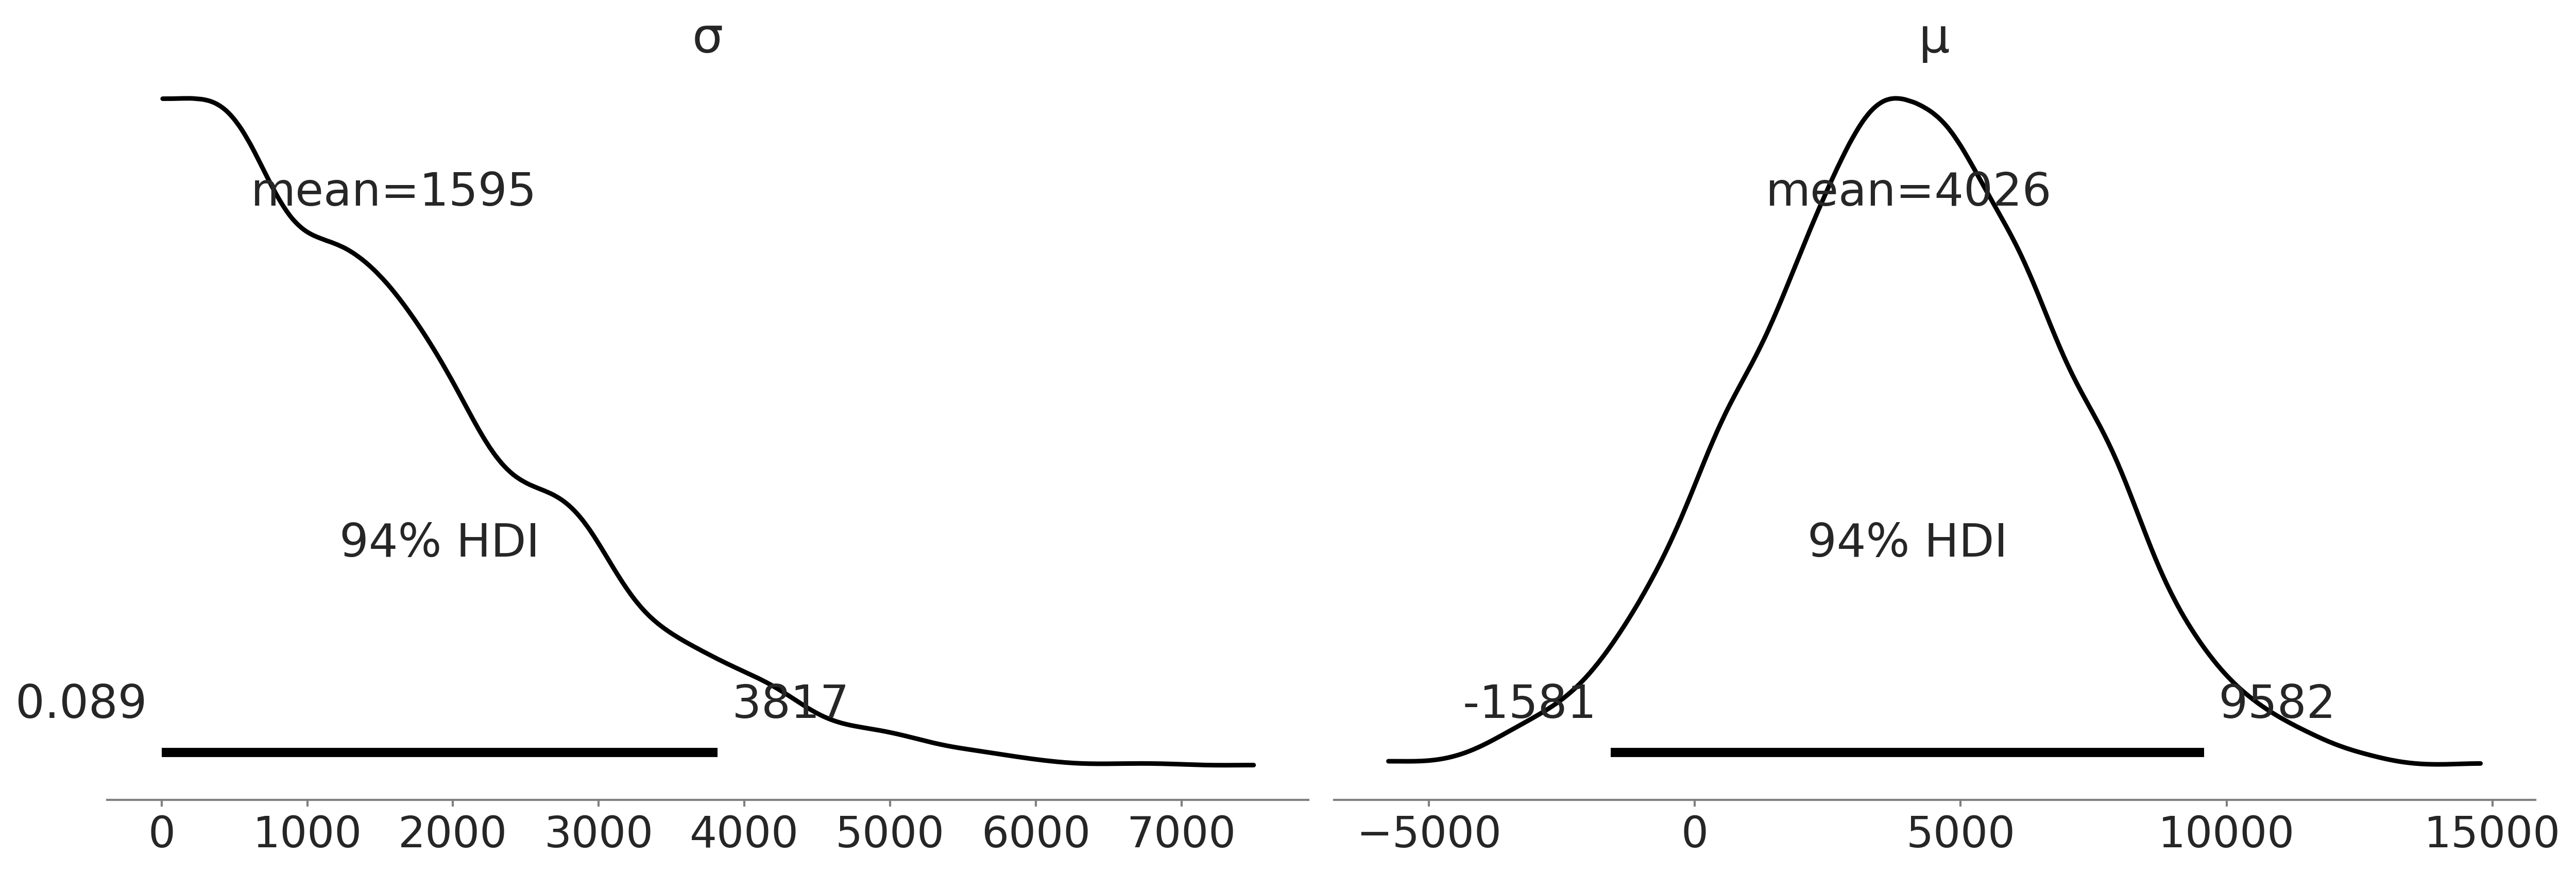

In [7]:
axes = az.plot_posterior(inf_data_adelie_penguin_mass.prior, var_names=["σ", "μ"], textsize=20)

# plt.savefig("img/SingleSpecies_Prior_Predictive.png")
plt.savefig("img/chp03/single_species_prior_predictive.png")

### Figure 3.2

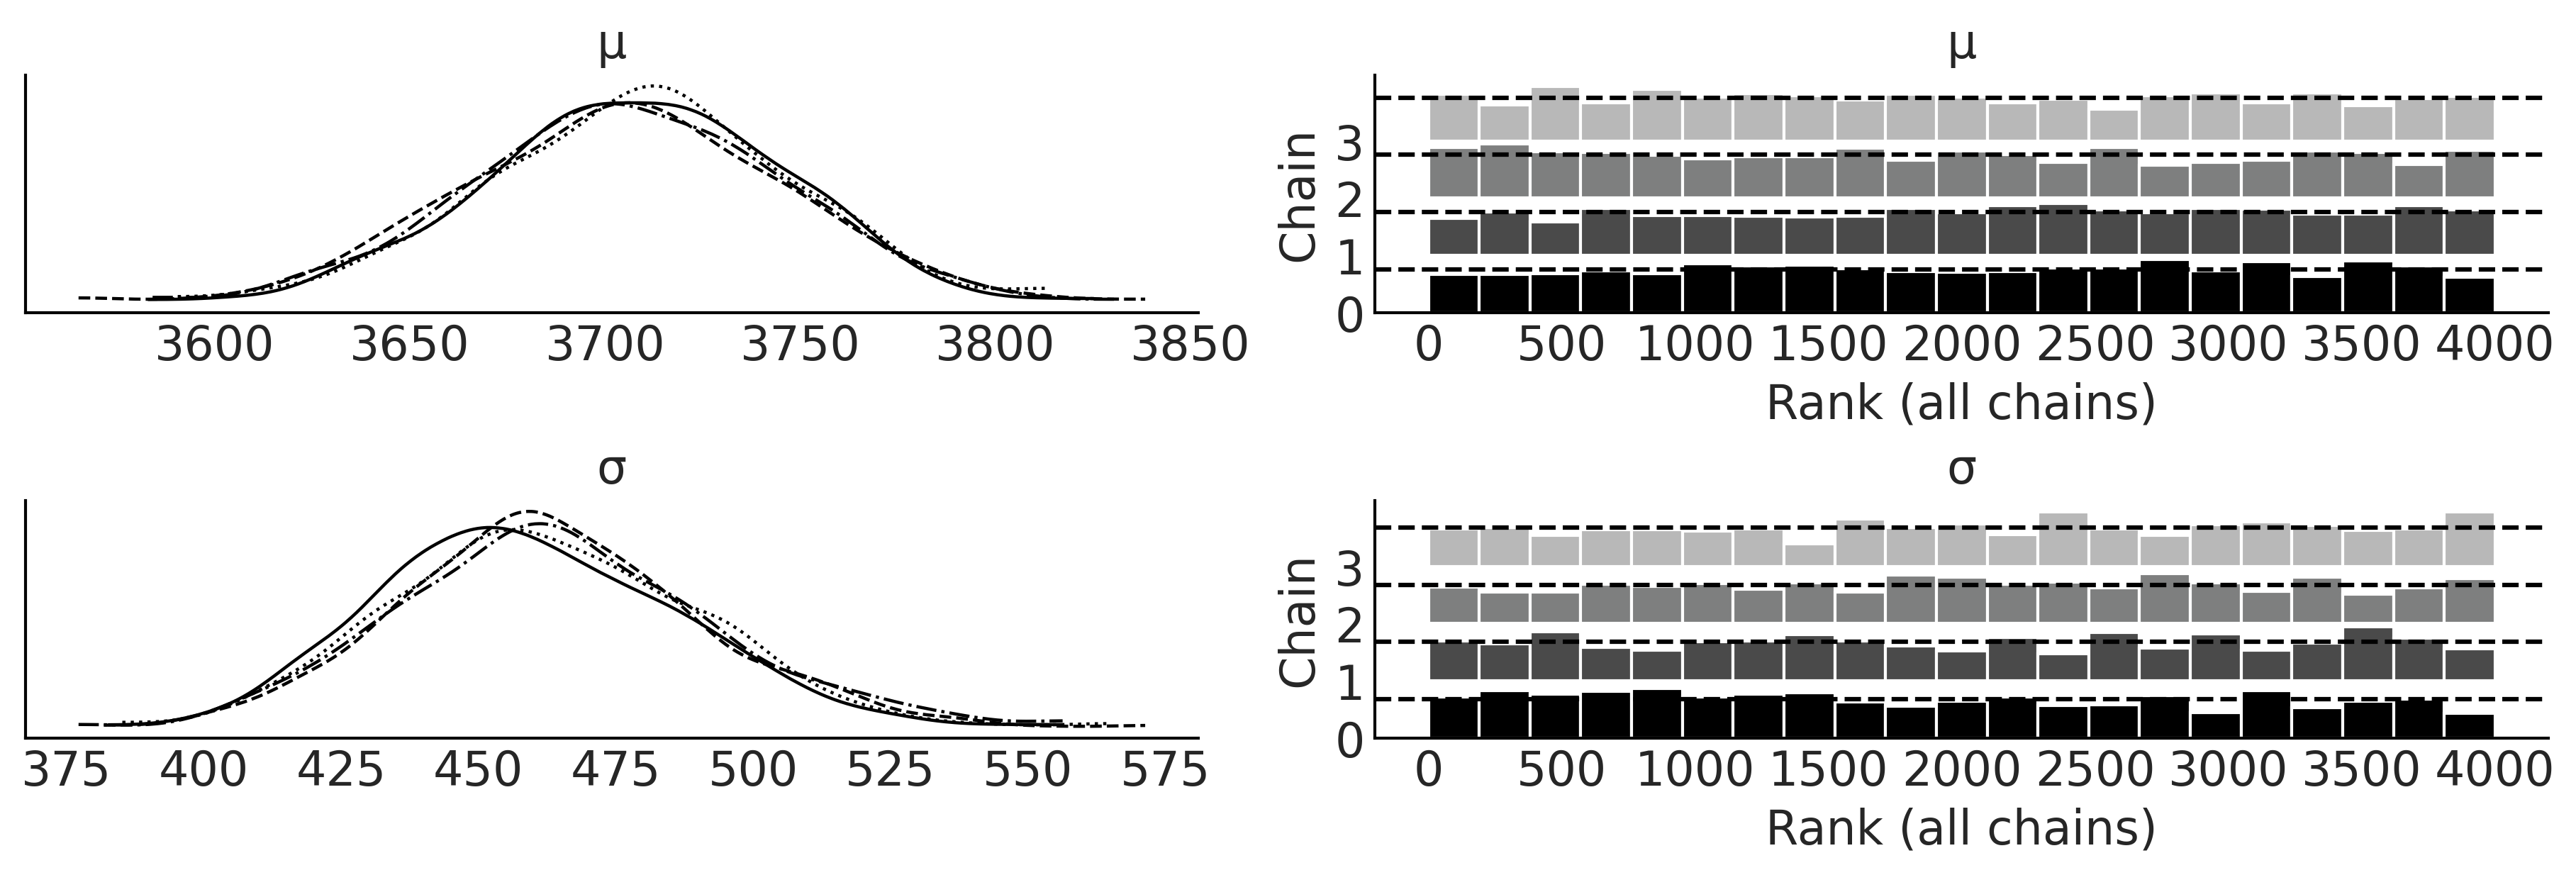

In [8]:
axes = az.plot_trace(inf_data_adelie_penguin_mass, divergences="bottom", kind="rank_bars")


plot_label_resizer(axes, fontsize=16)
# plt.savefig("img/SingleSpecies_KDE_RankPlot.png")
plt.savefig("img/chp03/single_species_KDE_rankplot.png")

### Table 3.2

In [9]:
az.summary(inf_data_adelie_penguin_mass)

mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
μ  3706.753  38.841  3627.867  3772.827      0.657    0.465    3483.0   
σ   461.989  27.456   411.883   513.950      0.482    0.341    3241.0   

   ess_tail  r_hat  
μ    2535.0    1.0  
σ    2614.0    1.0

In [10]:
print(az.summary(inf_data_adelie_penguin_mass).round(1).to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &    mean &    sd &  hdi\_3\% &  hdi\_97\% &  mcse\_mean &  mcse\_sd &  ess\_bulk &  ess\_tail &  r\_hat \\
\midrule
μ &  3706.8 &  38.8 &  3627.9 &   3772.8 &        0.7 &      0.5 &    3483.0 &    2535.0 &    1.0 \\
σ &   462.0 &  27.5 &   411.9 &    514.0 &        0.5 &      0.3 &    3241.0 &    2614.0 &    1.0 \\
\bottomrule
\end{tabular}



### Figure 3.3

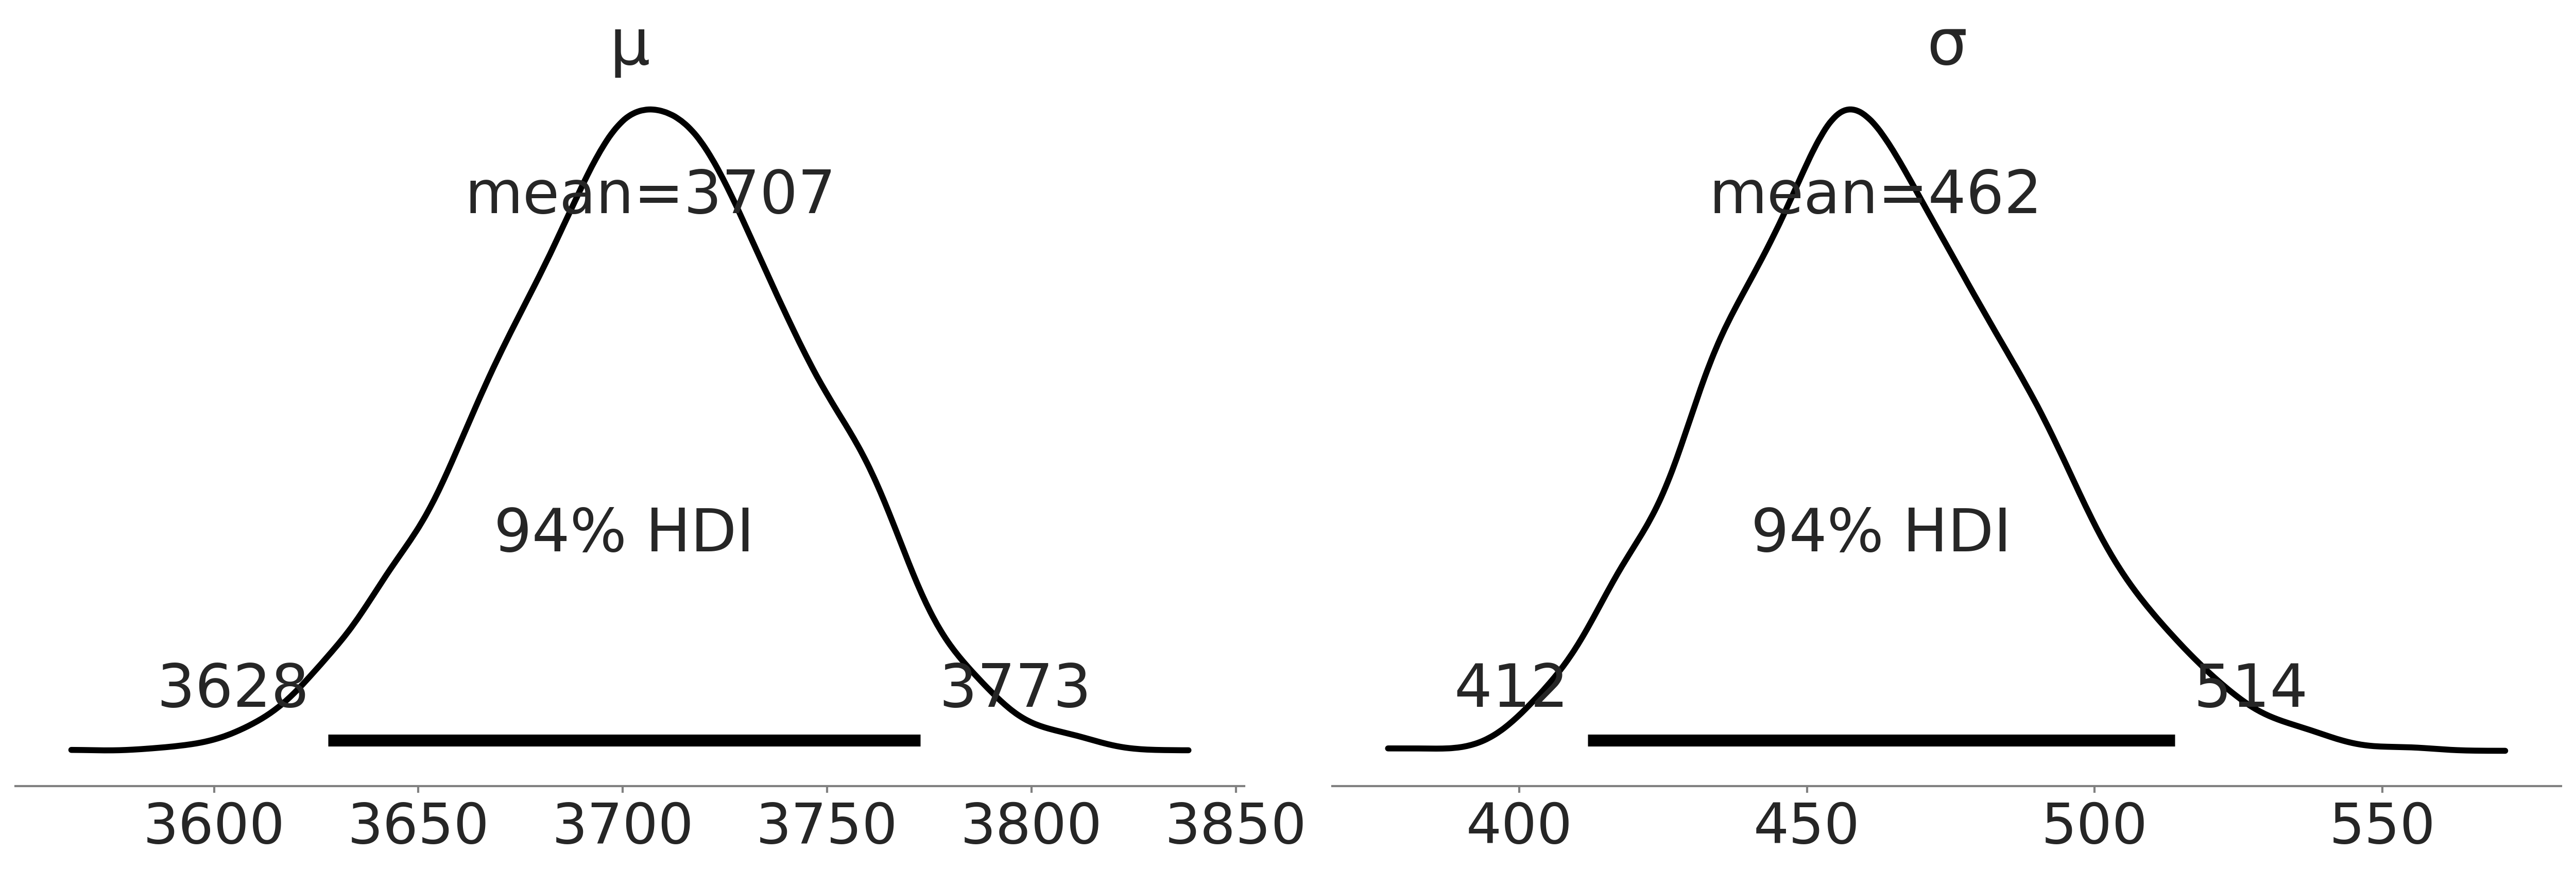

In [11]:
axes = az.plot_posterior(inf_data_adelie_penguin_mass, hdi_prob=.94, textsize=26);
# plt.savefig("img/SingleSpecies_Mass_PosteriorPlot.png")
plt.savefig("img/chp03/single_species_sass_posteriorplot.png")

### Figure 3.4

In [12]:
# pd.categorical makes it easy to index species below
all_species = pd.Categorical(penguins["species"])

with pm.Model() as model_penguin_mass_all_species:
    # Note the addition of the shape parameter
    σ = pm.HalfStudentT("σ", 100, 2000, shape=3)
    μ = pm.Normal("μ", 4000, 3000, shape=3)
    mass = pm.Normal("mass", 
                     mu=μ[all_species.codes],
                     sigma=σ[all_species.codes],
                     observed=penguins["body_mass_g"])

    trace = pm.sample()
    inf_data_model_penguin_mass_all_species = az.from_pymc3(
        trace=trace,
        coords={"μ_dim_0": all_species.categories,
                "σ_dim_0": all_species.categories})

/tmp/ipykernel_83821/3930885342.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


### Figure 3.4

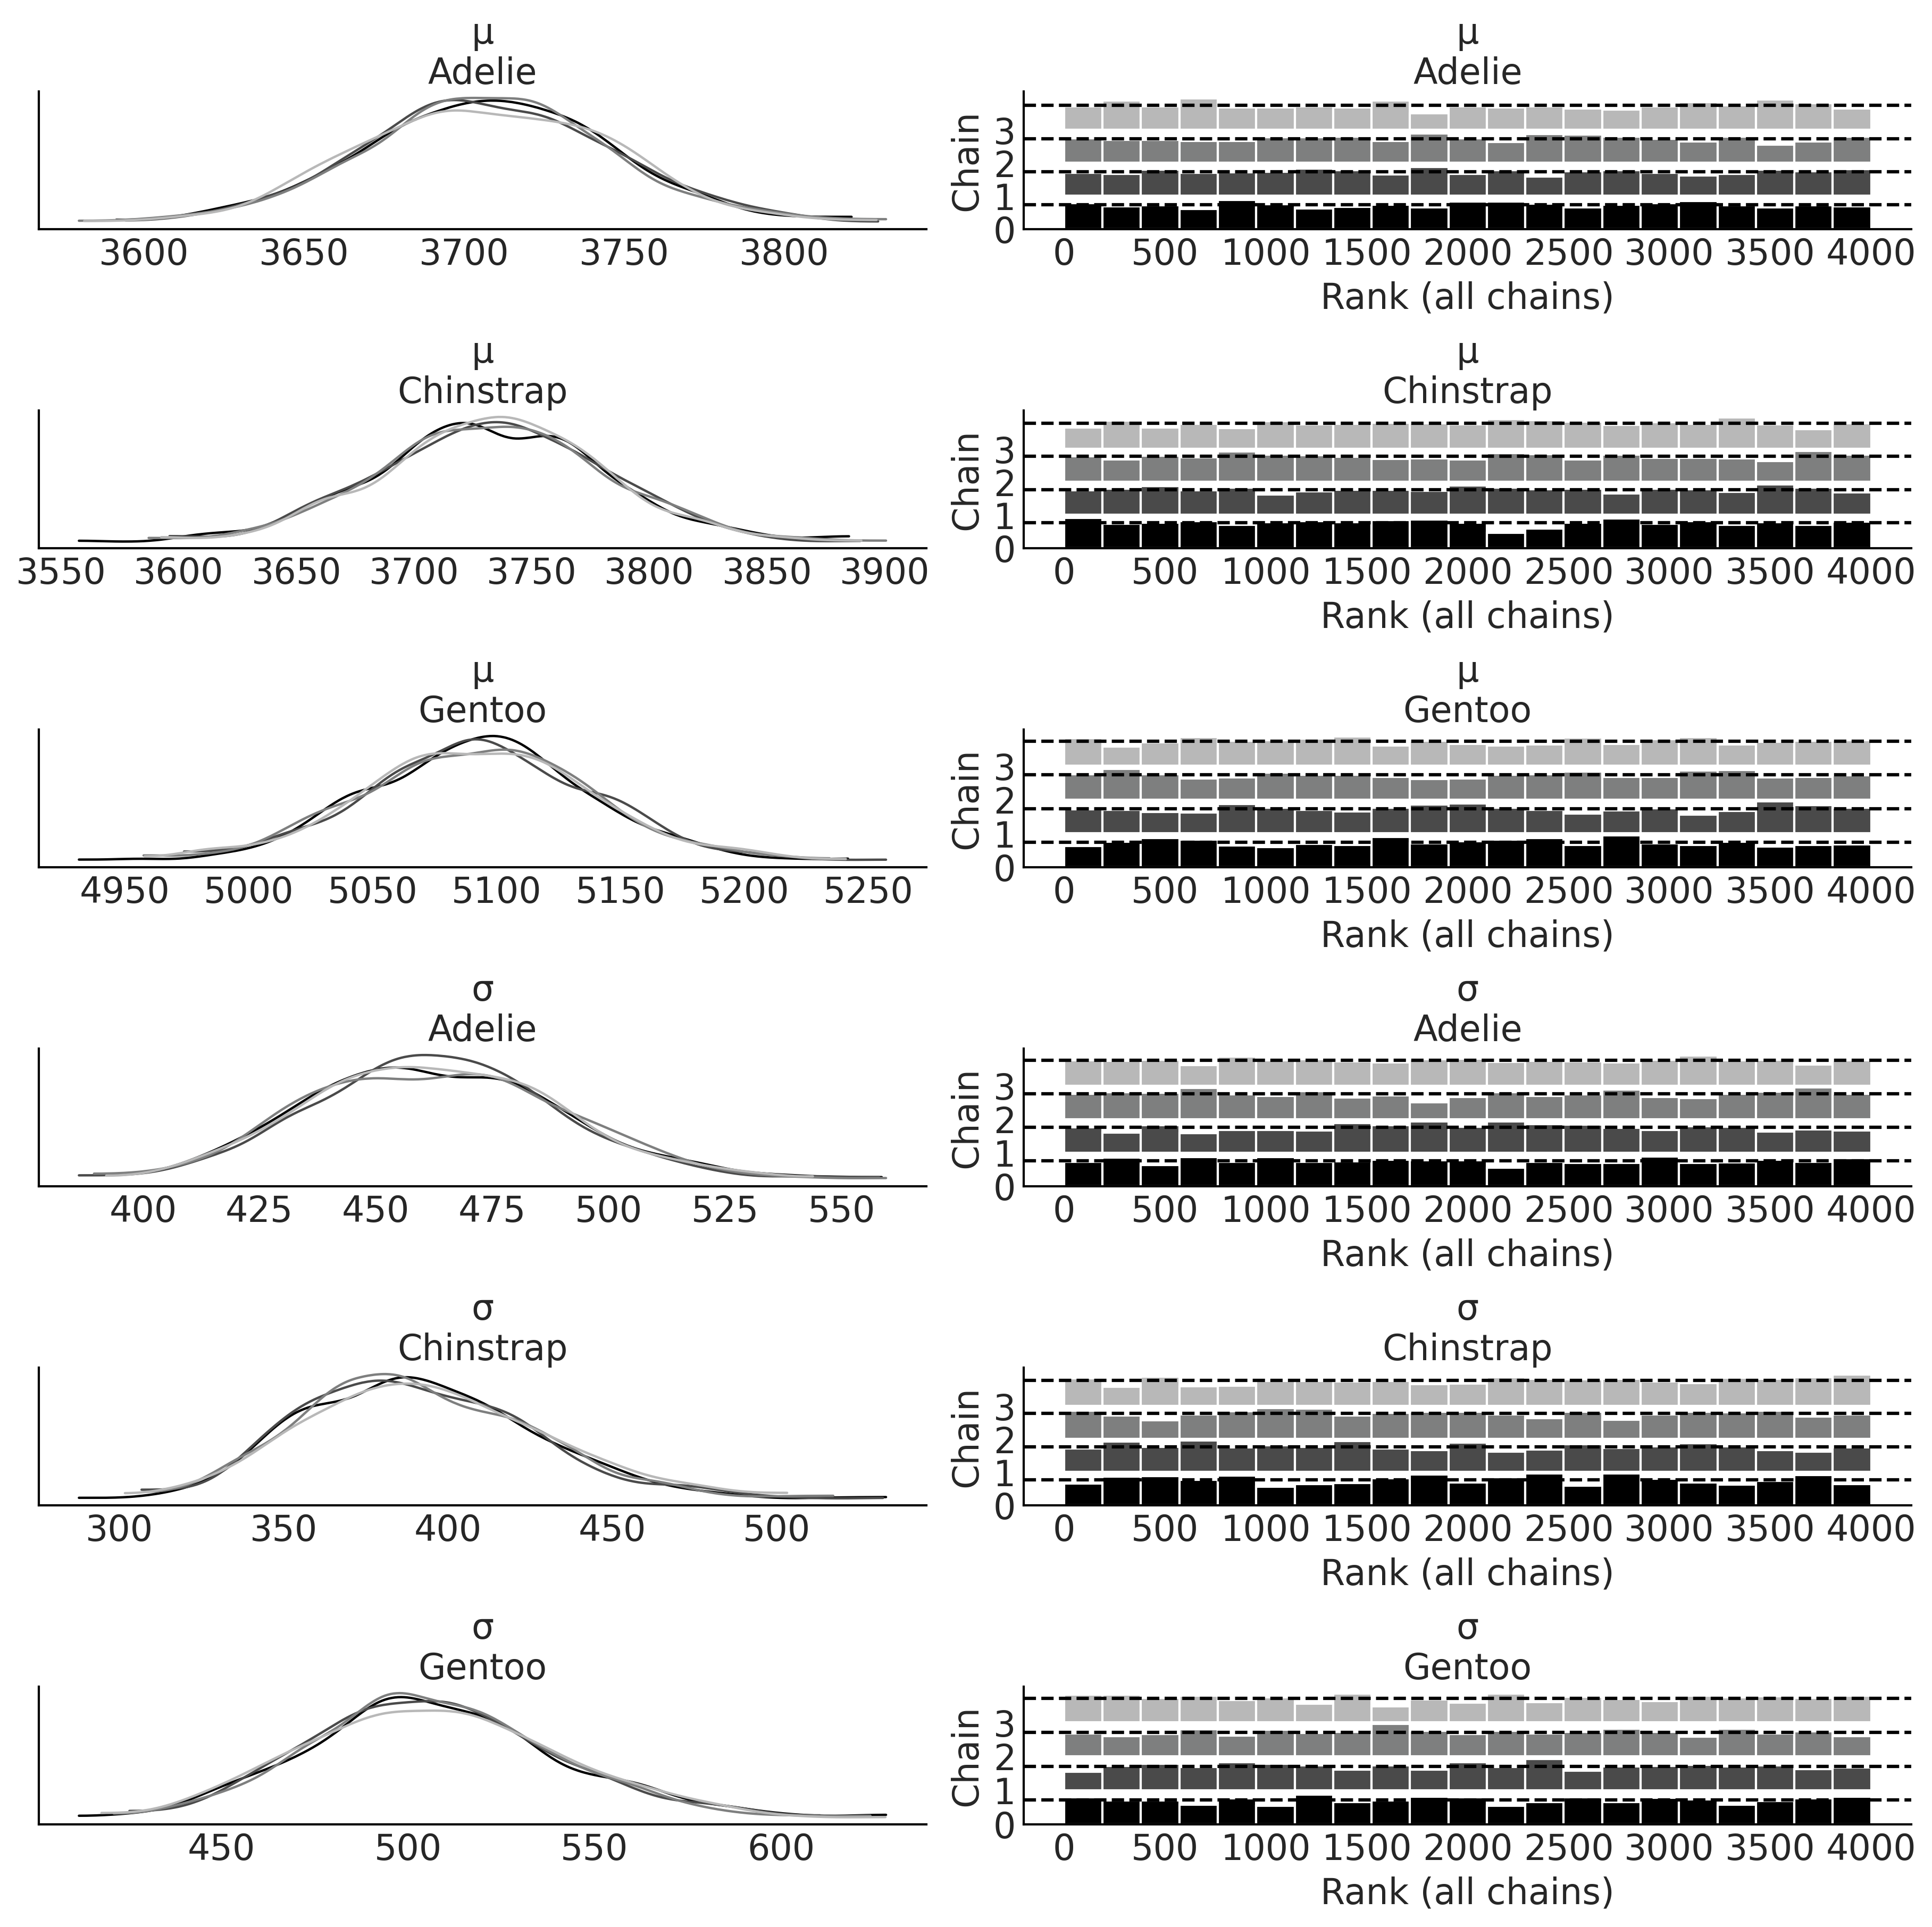

In [13]:
axes = az.plot_trace(inf_data_model_penguin_mass_all_species, compact=False, divergences="bottom", kind="rank_bars");

plot_label_resizer(axes, fontsize=16)
plt.savefig("img/chp03/all_species_KDE_rankplot.png")

### Code 3.5 and Figure 3.5

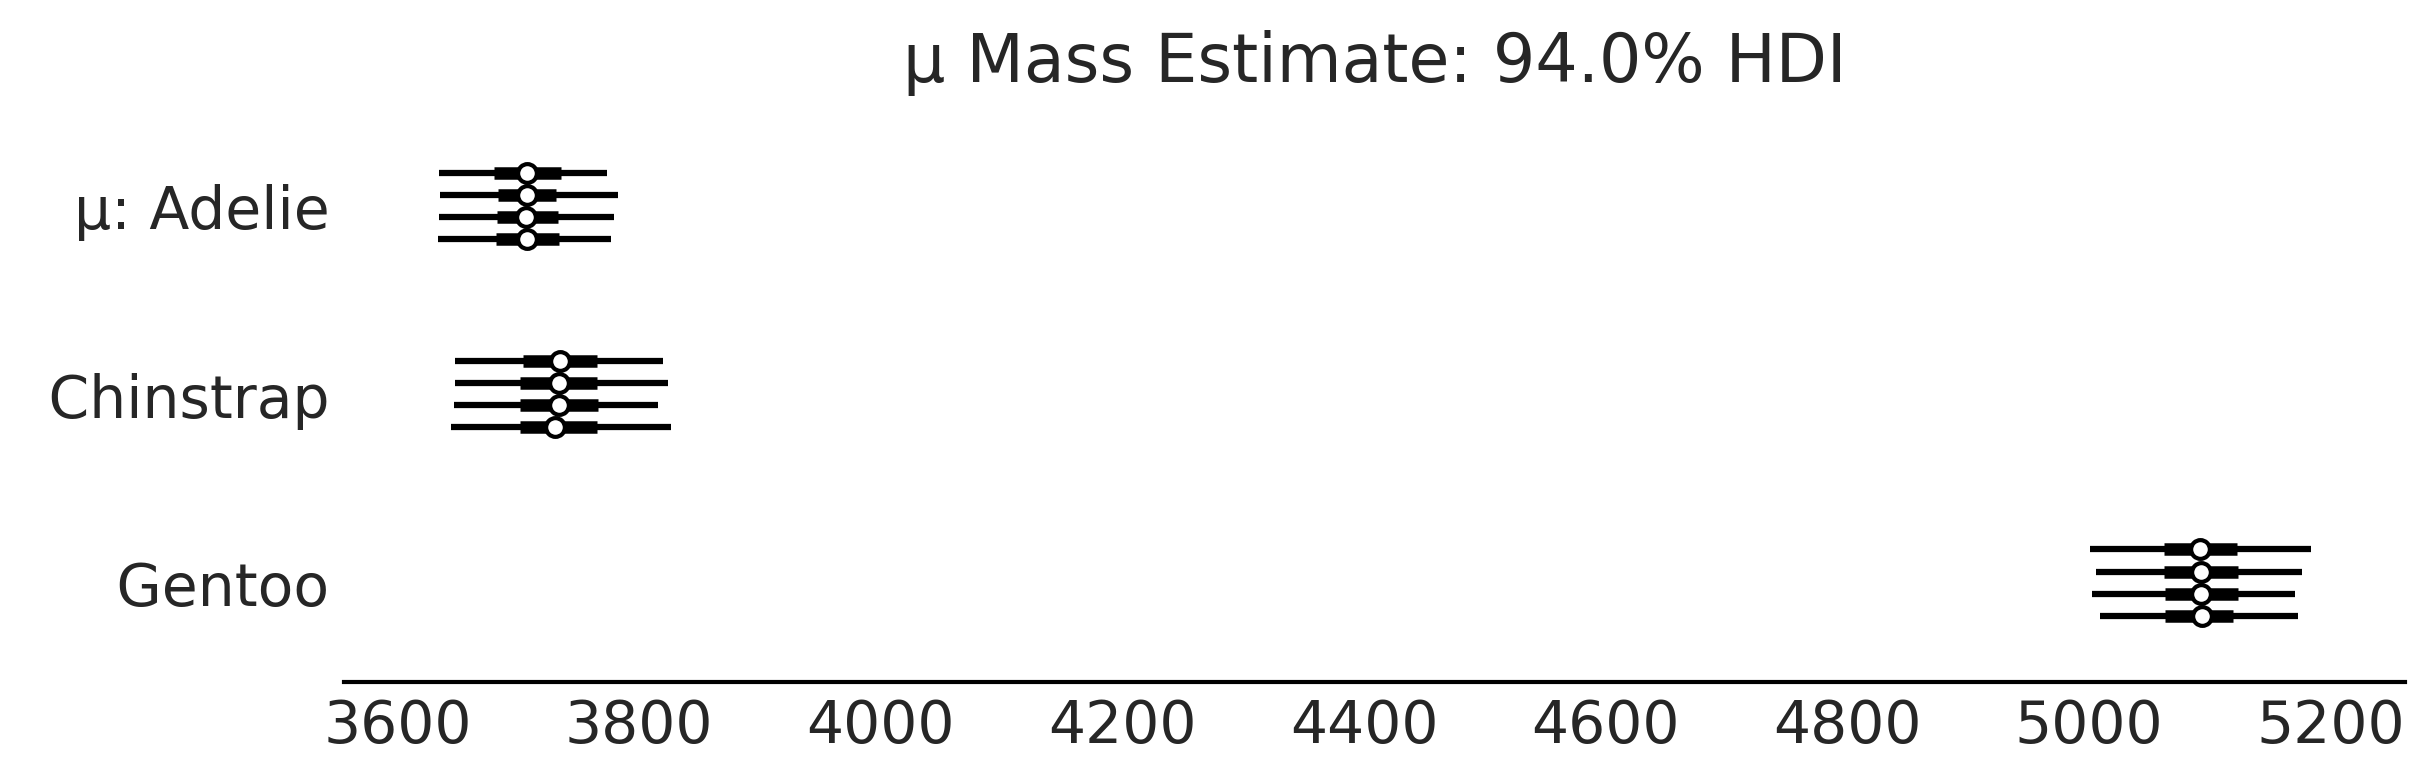

In [14]:
axes = az.plot_forest(inf_data_model_penguin_mass_all_species, var_names=["μ"], figsize=(8, 2.5))
axes[0].set_title("μ Mass Estimate: 94.0% HDI")

plt.savefig("img/chp03/independent_model_forestplotmeans.png")

### Code 3.6 and Figure 3.6

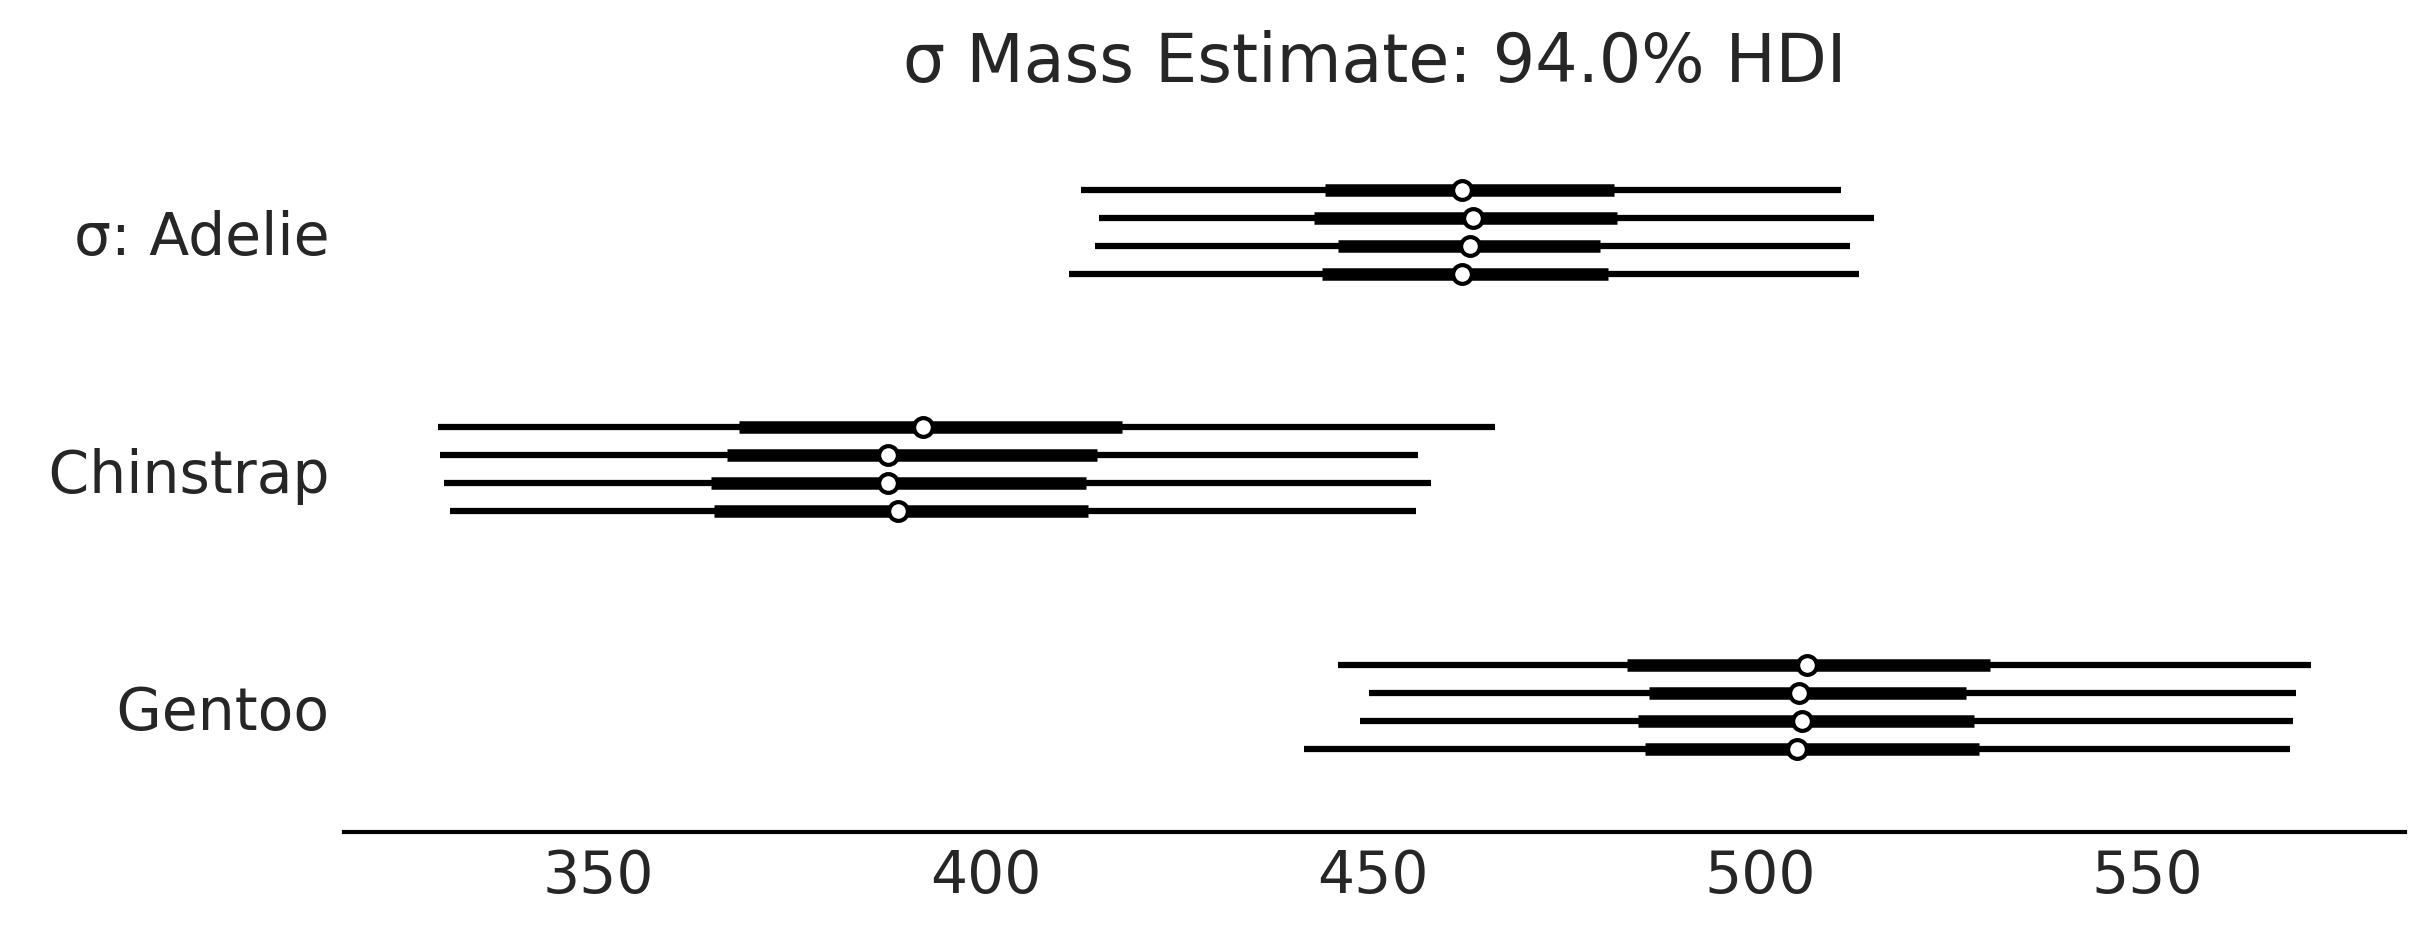

In [15]:
axes = az.plot_forest(inf_data_model_penguin_mass_all_species, var_names=["σ"], figsize=(8, 3));
axes[0].set_title("σ Mass Estimate: 94.0% HDI")

plt.savefig("img/chp03/independent_model_forestplotsigma.png")

### Code 3.7

In [16]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
root = tfd.JointDistributionCoroutine.Root

species_idx = tf.constant(all_species.codes, tf.int32)
body_mass_g = tf.constant(penguins["body_mass_g"], tf.float32)

@tfd.JointDistributionCoroutine
def jd_penguin_mass_all_species():
    σ = yield root(tfd.Sample(
            tfd.HalfStudentT(df=100, loc=0, scale=2000),
            sample_shape=3,
            name="sigma"))
    μ = yield root(tfd.Sample(
            tfd.Normal(loc=4000, scale=3000),
            sample_shape=3,
            name="mu"))
    mass = yield tfd.Independent(
        tfd.Normal(loc=tf.gather(μ, species_idx, axis=-1),
                   scale=tf.gather(σ, species_idx, axis=-1)),
        reinterpreted_batch_ndims=1,
        name="mass")

2021-12-18 20:45:55.483293: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-18 20:45:55.483309: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-18 20:45:56.765080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 20:45:56.765640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-18 20:45:56.765709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

### Code 3.8

In [17]:
prior_predictive_samples = jd_penguin_mass_all_species.sample(1000)

### Code 3.9

In [18]:
jd_penguin_mass_all_species.sample(sigma=tf.constant([.1, .2, .3]))
jd_penguin_mass_all_species.sample(mu=tf.constant([.1, .2, .3]))

StructTuple(
  sigma=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 984.17804 , 1432.3654  ,   23.811424], dtype=float32)>,
  mu=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.1, 0.2, 0.3], dtype=float32)>,
  mass=<tf.Tensor: shape=(333,), dtype=float32, numpy=
    array([ 1.59277820e+03,  1.74029861e+02, -2.06257178e+03, -1.46251465e+03,
           -7.12007568e+02, -8.58797058e+02, -3.69443054e+02,  2.59977875e+02,
           -2.19499438e+03,  5.80170517e+01,  5.58388245e+02, -2.27075830e+03,
            6.30290161e+02, -5.42697876e+02,  1.13943579e+03, -3.47500549e+02,
            6.25173950e+02,  1.96915857e+03, -6.44494171e+01, -1.00810356e+01,
           -1.40153284e+03,  5.71614807e+02,  1.88863251e+02,  8.59641846e+02,
           -2.31087448e+02, -2.68818512e+01,  7.05527100e+02, -1.17175163e+02,
           -7.10269409e+02,  8.53588745e+02, -4.99459686e+02,  1.30170837e+03,
           -3.35147614e+02, -3.81198792e+02,  1.81465369e+03,  2.73267822e+03,
           -2.

### Code 3.10

In [19]:
target_density_function = lambda *x: jd_penguin_mass_all_species.log_prob(
    *x, mass=body_mass_g)

jd_penguin_mass_observed = jd_penguin_mass_all_species.experimental_pin(
    mass=body_mass_g)
target_density_function = jd_penguin_mass_observed.unnormalized_log_prob

# init_state = jd_penguin_mass_observed.sample_unpinned(10)
# target_density_function1(*init_state), target_density_function2(*init_state)

### Code 3.11

In [20]:
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False, jit_compile=True)
mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_penguin_mass_all_species, n_chains=4, num_adaptation_steps=1000,
    mass=body_mass_g)

inf_data_model_penguin_mass_all_species2 = az.from_dict(
    posterior={
        # TFP mcmc returns (num_samples, num_chains, ...), we swap
        # the first and second axis below for each RV so the shape
        # is what ArviZ expected. 
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2021-12-18 20:46:02.238969: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x5648a2333df0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-18 20:46:02.238988: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-12-18 20:46:02.394799: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:237] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2021-12-18 20:46:02.458876: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2021-12-18 20:46:02.543972: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert
2021-12-18 20:46:11.072136: I tensorflow/compiler/jit/xla_compila

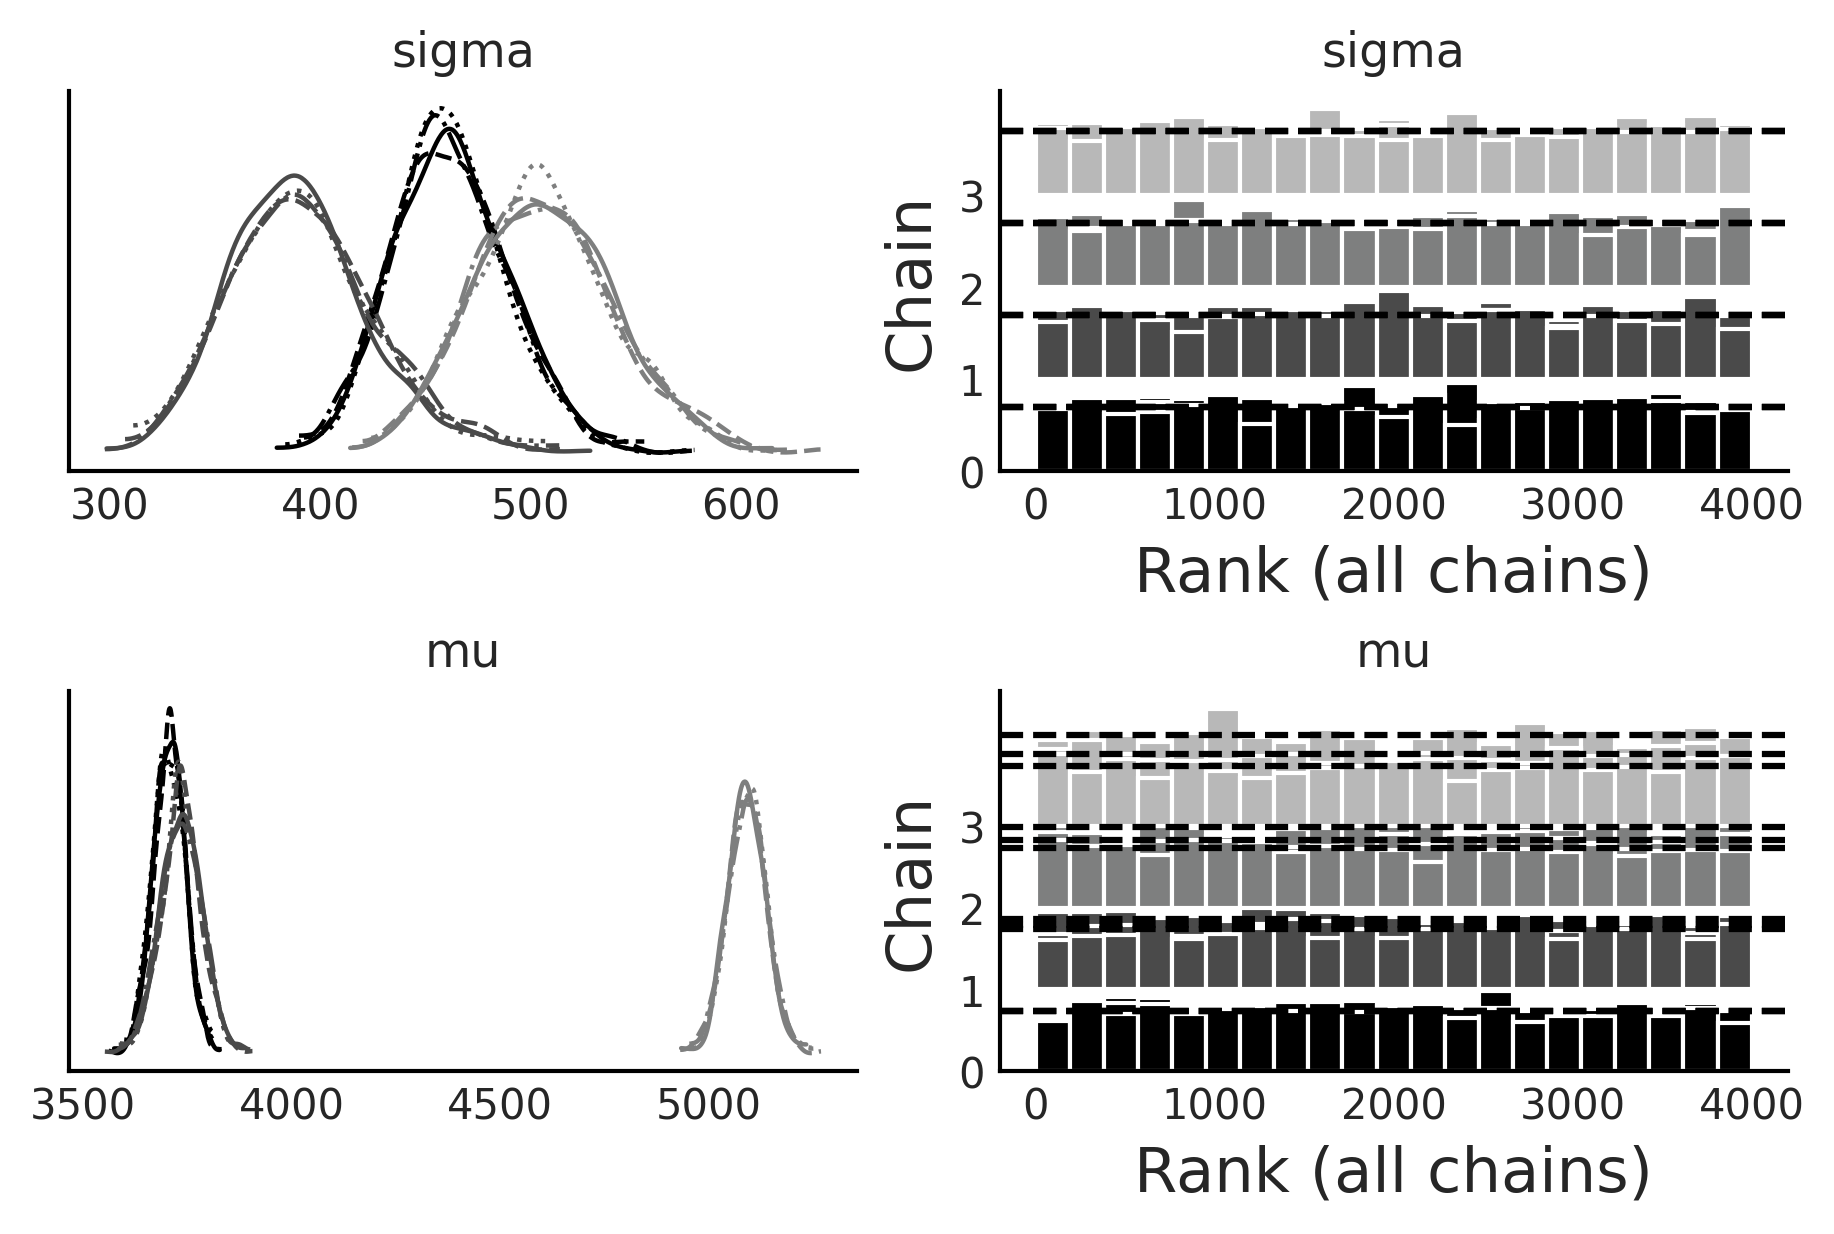

In [21]:
az.plot_trace(inf_data_model_penguin_mass_all_species2, divergences="bottom", kind="rank_bars", figsize=(6,4));

### Code 3.12

In [22]:
prior_predictive_samples = jd_penguin_mass_all_species.sample([1, 1000])
dist, samples = jd_penguin_mass_all_species.sample_distributions(
    value=mcmc_samples)
ppc_samples = samples[-1]
ppc_distribution = dist[-1].distribution
data_log_likelihood = ppc_distribution.log_prob(body_mass_g)

# Be careful not to run this code twice during REPL workflow.
inf_data_model_penguin_mass_all_species2.add_groups(
    prior=prior_predictive_samples[:-1]._asdict(),
    prior_predictive={"mass": prior_predictive_samples[-1]},
    posterior_predictive={"mass": np.swapaxes(ppc_samples, 1, 0)},
    log_likelihood={"mass": np.swapaxes(data_log_likelihood, 1, 0)},
    observed_data={"mass": body_mass_g}
)

/home/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/data/inference_data.py:1328: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


<AxesSubplot:xlabel='mass'>

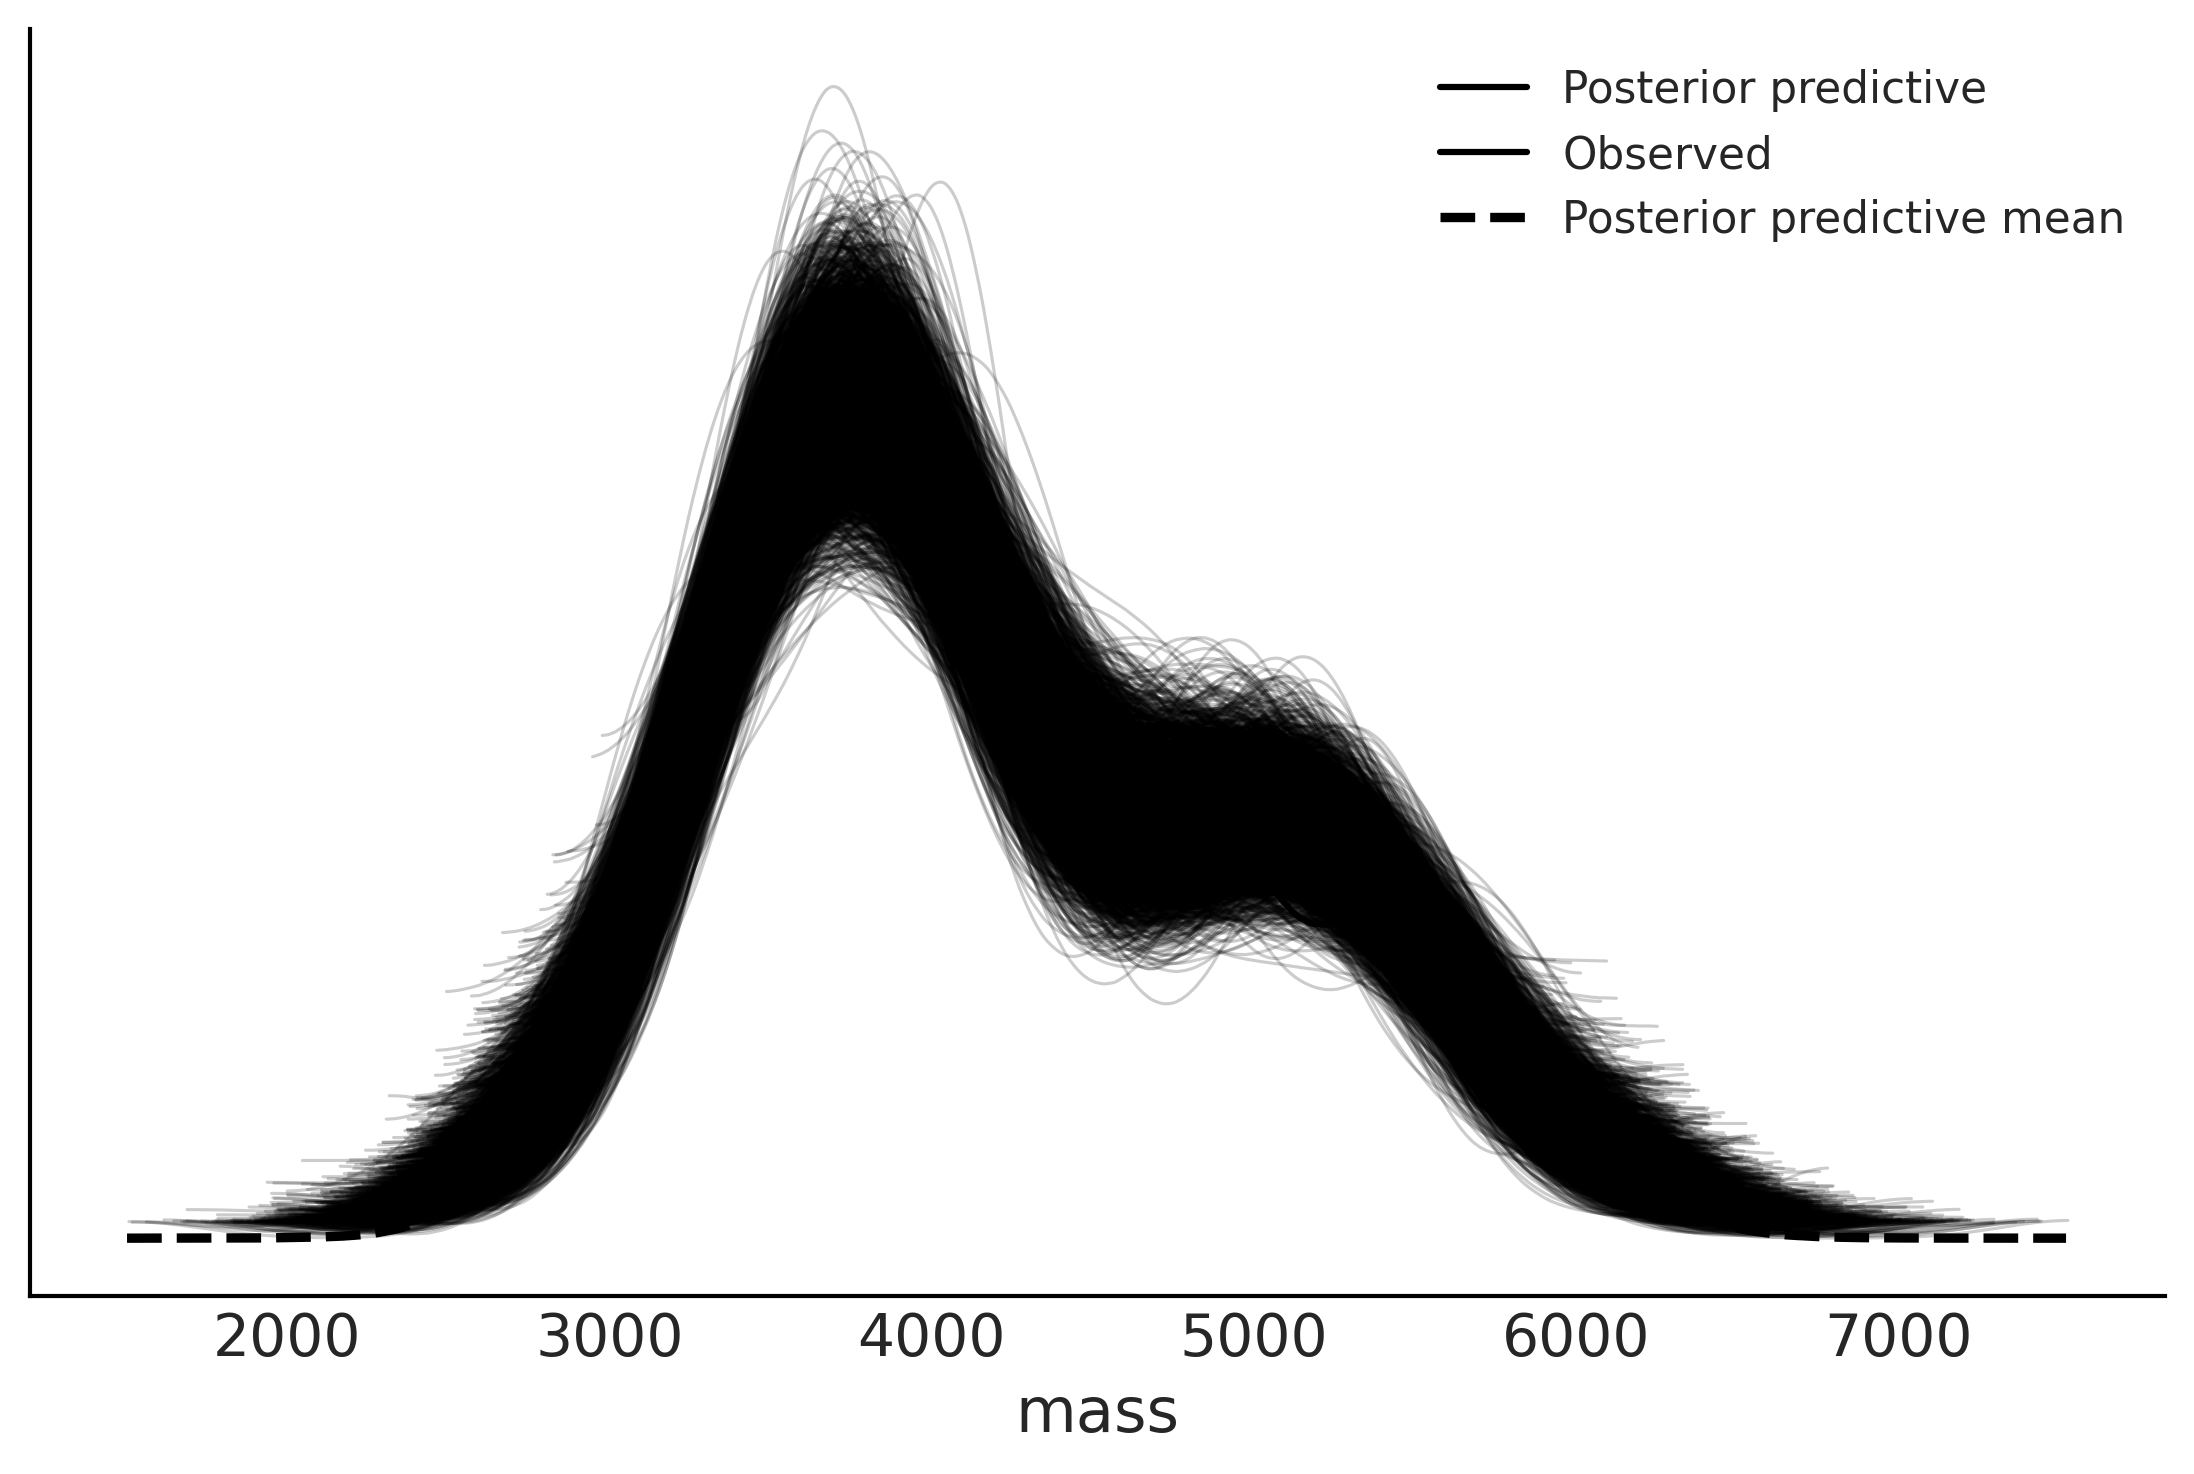

In [23]:
az.plot_ppc(inf_data_model_penguin_mass_all_species2)

In [24]:
az.loo(inf_data_model_penguin_mass_all_species2)

Computed from 4000 by 333 log-likelihood matrix

         Estimate       SE
elpd_loo -2516.19    11.63
p_loo        5.48        -

## Linear Regression

### Figure 3.7

/tmp/ipykernel_83821/2974397516.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")
/tmp/ipykernel_83821/2974397516.py:39: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("img/chp03/3d_linear_regression.png", bbox_inches="tight", dpi=300)
/home/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


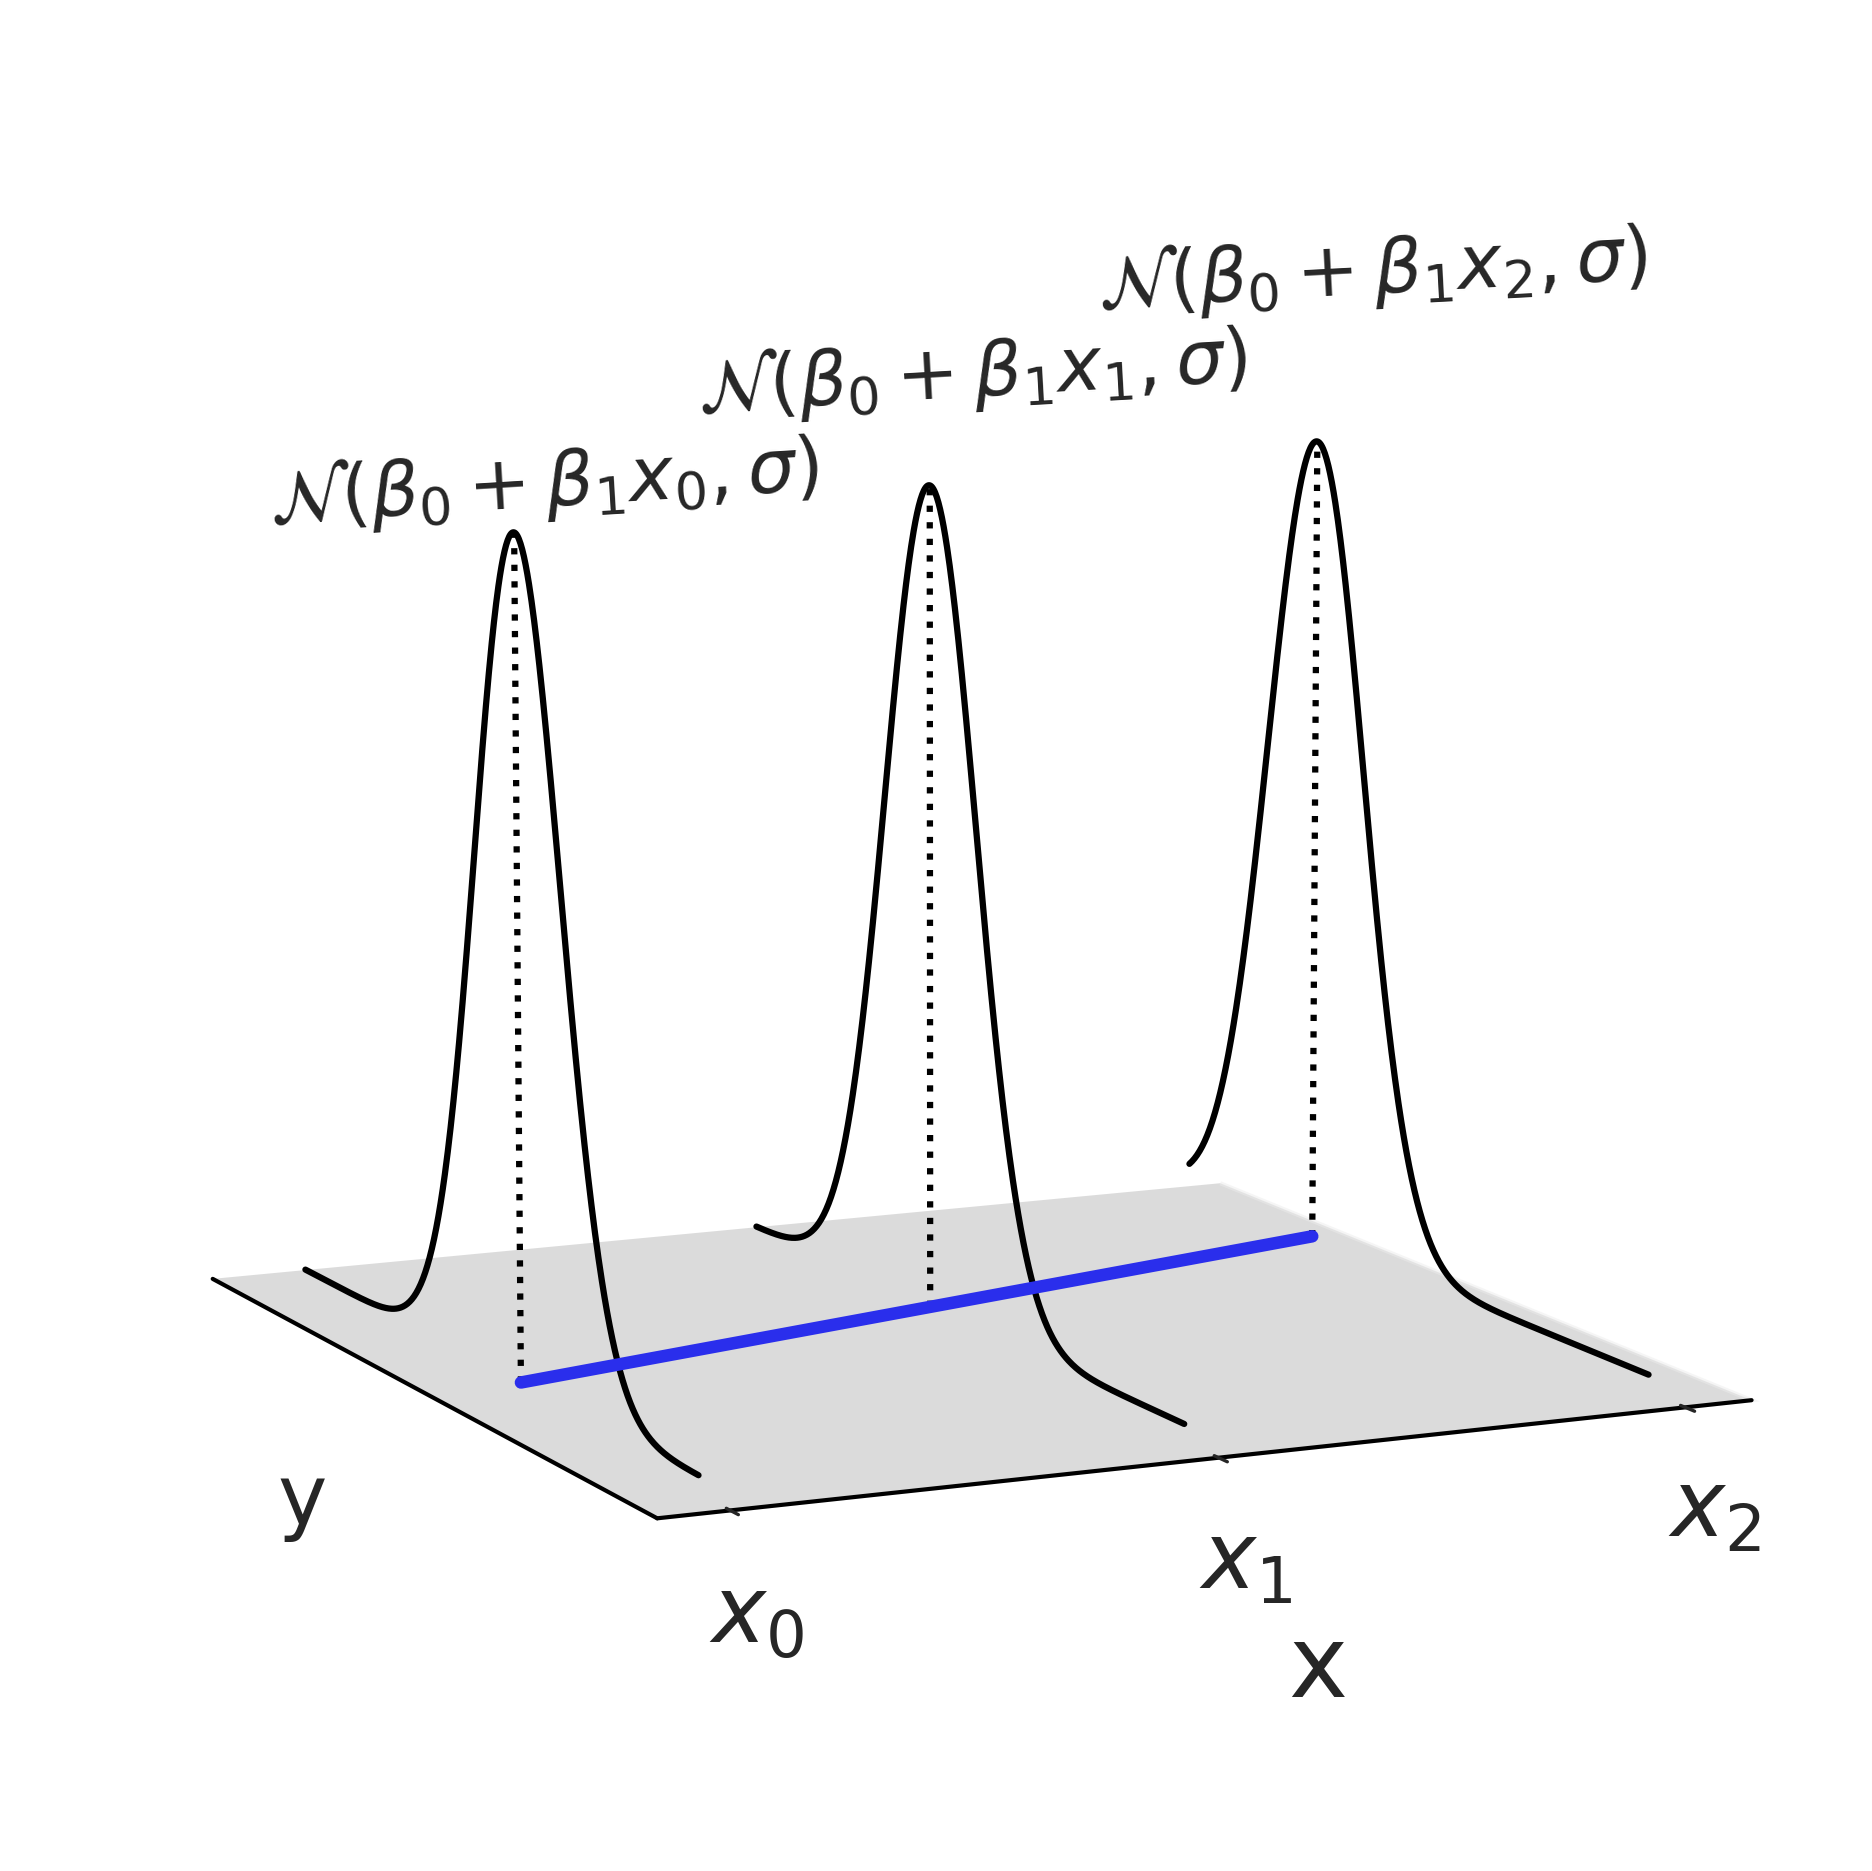

In [25]:
fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection="3d")

x = np.linspace(-16, 12, 500)
z = np.array([0, 4, 8])

for i, zi in enumerate(z):
    dens = stats.norm(-zi, 3).pdf(x)
    ax.plot(x, dens, zs=zi + 1, zdir="y", c="k")
    ax.plot([-zi, -zi], [0, max(dens)], zs=zi + 1, c="k", ls=":", zdir="y")
    ax.text(
        -zi,
        zi - 1,
        max(dens) * 1.03 + i / 100,
        f"$\\mathcal{{N}}(\\beta_0 + \\beta_1 x_{i}, \\sigma)$",
        zdir="y",
        fontsize=18,
    )

ax.plot(-z, z + 1, "C4-", lw=3)


ax.set_xlabel("y", fontsize=20)
ax.set_ylabel("x", fontsize=24, labelpad=20)

ax.set_yticks([zi + 1 for zi in z])
ax.set_yticklabels([f"$x_{i}$" for i in range(len(z))], fontsize=22)
ax.grid(False)
ax.set_xticks([])
ax.set_zticks([])
ax.yaxis.pane.fill = False
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor("None")
ax.yaxis.pane.set_edgecolor("None")
ax.zaxis.pane.set_facecolor("C3")
ax.w_zaxis.line.set_linewidth(0)
ax.view_init(elev=10, azim=-25)
# plt.savefig("img/3d_linear_regression.png", bbox_inches="tight", dpi=300)
plt.savefig("img/chp03/3d_linear_regression.png", bbox_inches="tight", dpi=300)

### Code 3.13

In [26]:
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"]

with pm.Model() as model_adelie_flipper_regression:
    # pm.Data allows us to change the underlying value in a later code block
    adelie_flipper_length = pm.Data("adelie_flipper_length", adelie_flipper_length_obs)
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 4000)
    β_1 = pm.Normal("β_1", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length)
    
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)
    
    inf_data_adelie_flipper_regression = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_1, β_0, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.890967753131468, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


### Figure 3.8

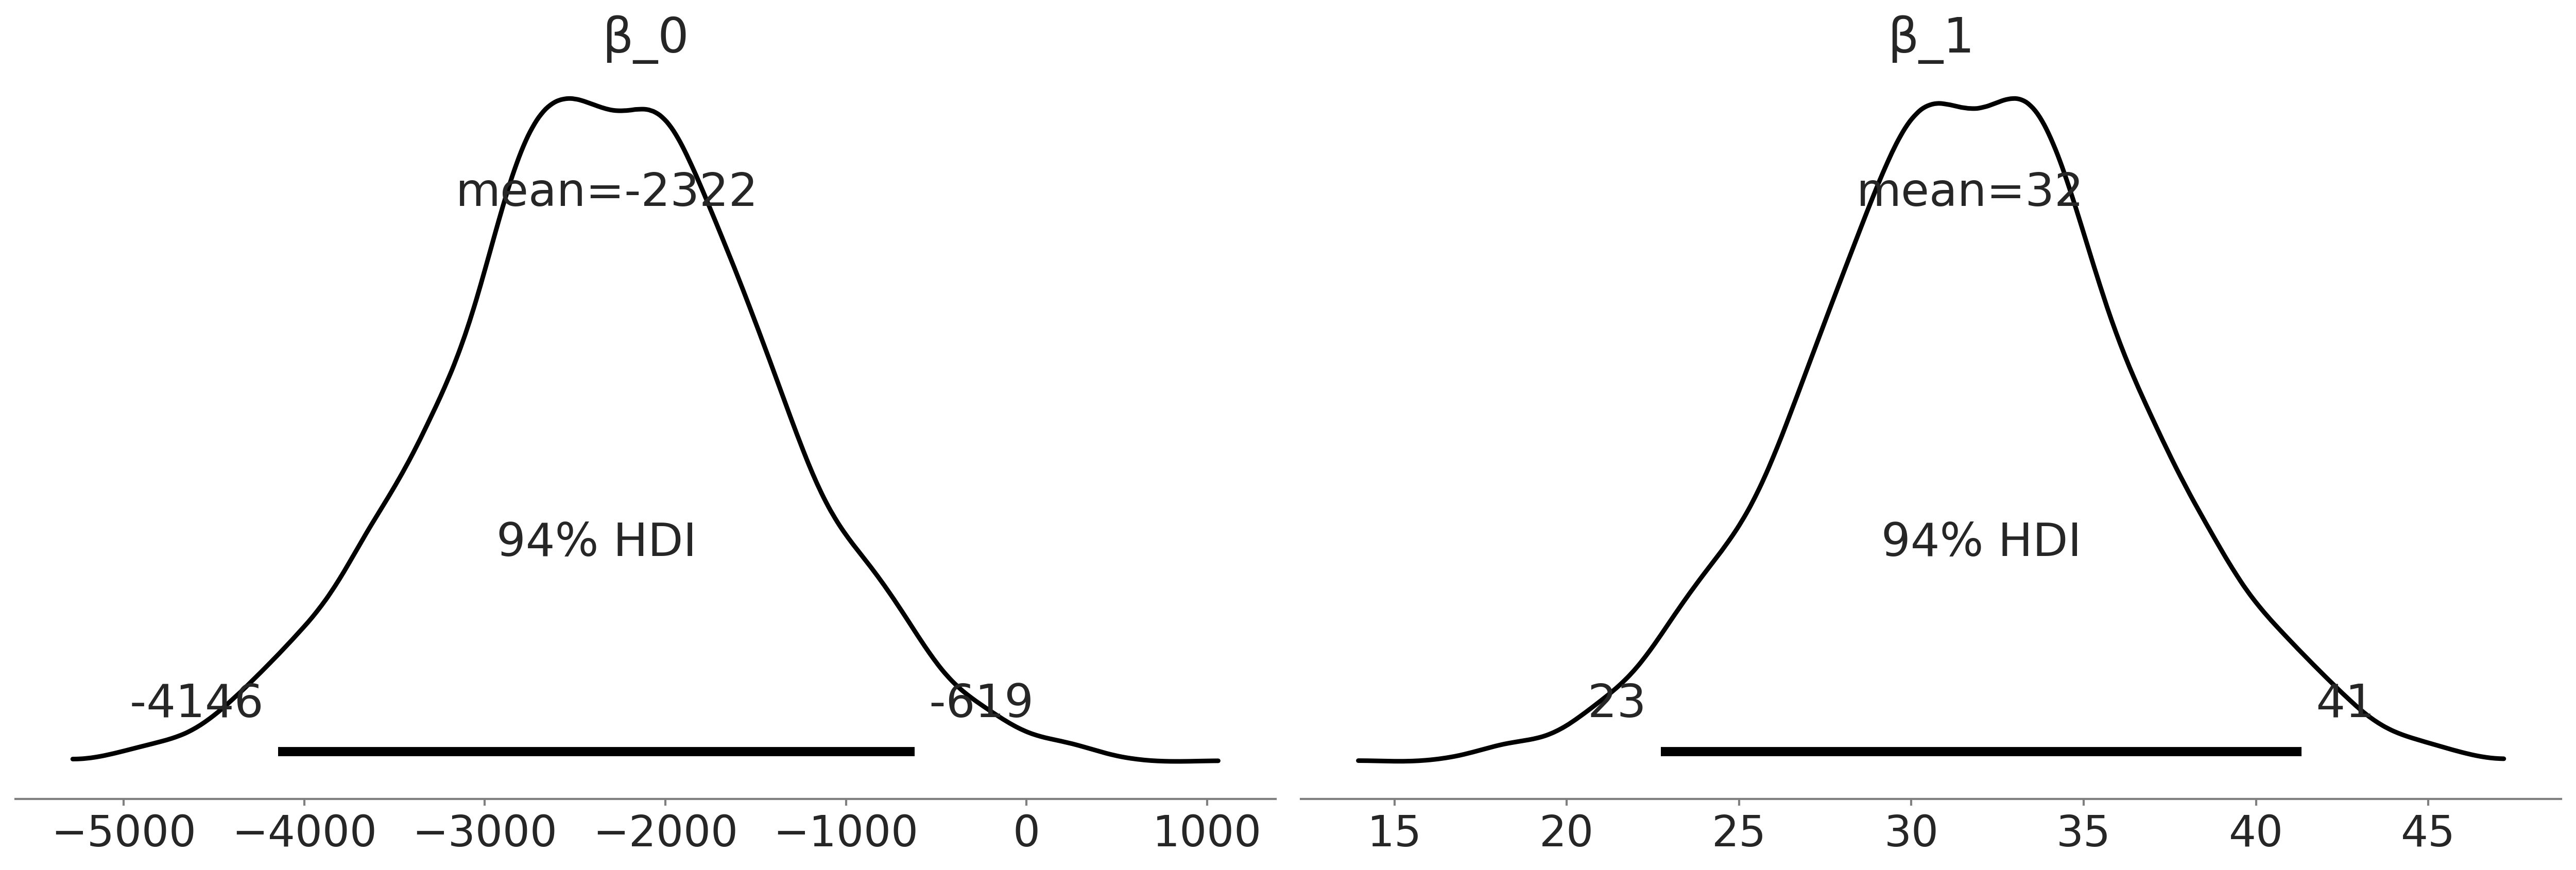

In [27]:
axes = az.plot_posterior(inf_data_adelie_flipper_regression, var_names = ["β_0", "β_1"], textsize=20);

#plot_label_resizer(axes, fontsize)
plt.savefig("img/chp03/adelie_coefficient_posterior_plots")

### Figure 3.9 

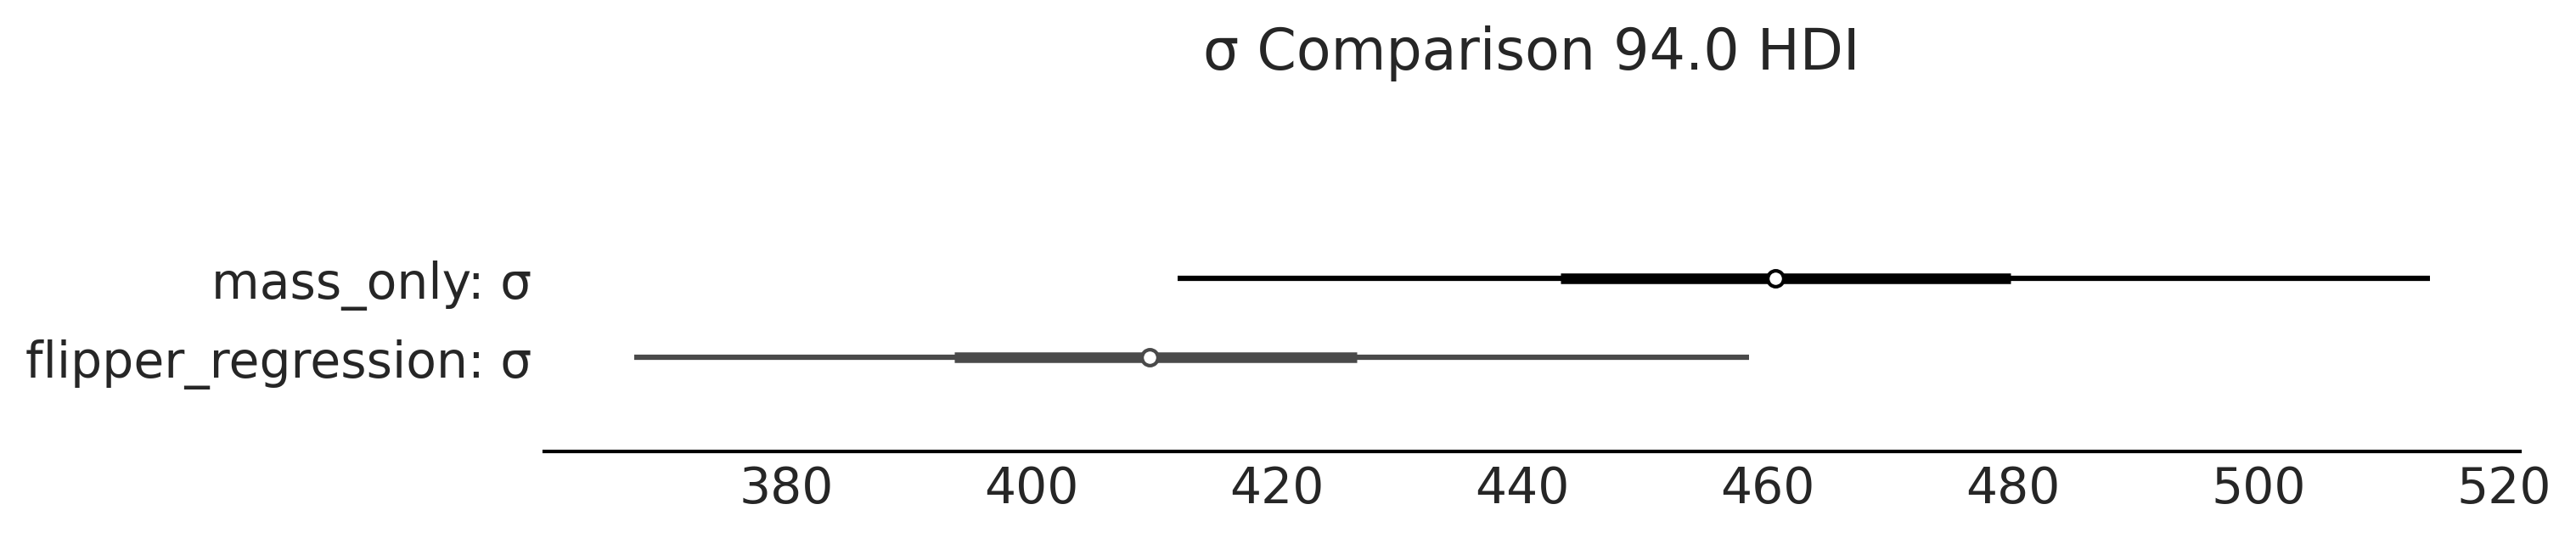

In [28]:
axes = az.plot_forest(
    [inf_data_adelie_penguin_mass, inf_data_adelie_flipper_regression],
    model_names=["mass_only", "flipper_regression"],
    var_names=["σ"], combined=True, figsize=(10,2))

axes[0].set_title("σ Comparison 94.0 HDI")
plt.savefig("img/chp03/SingleSpecies_SingleRegression_Forest_Sigma_Comparison.png")

### Figure 3.10

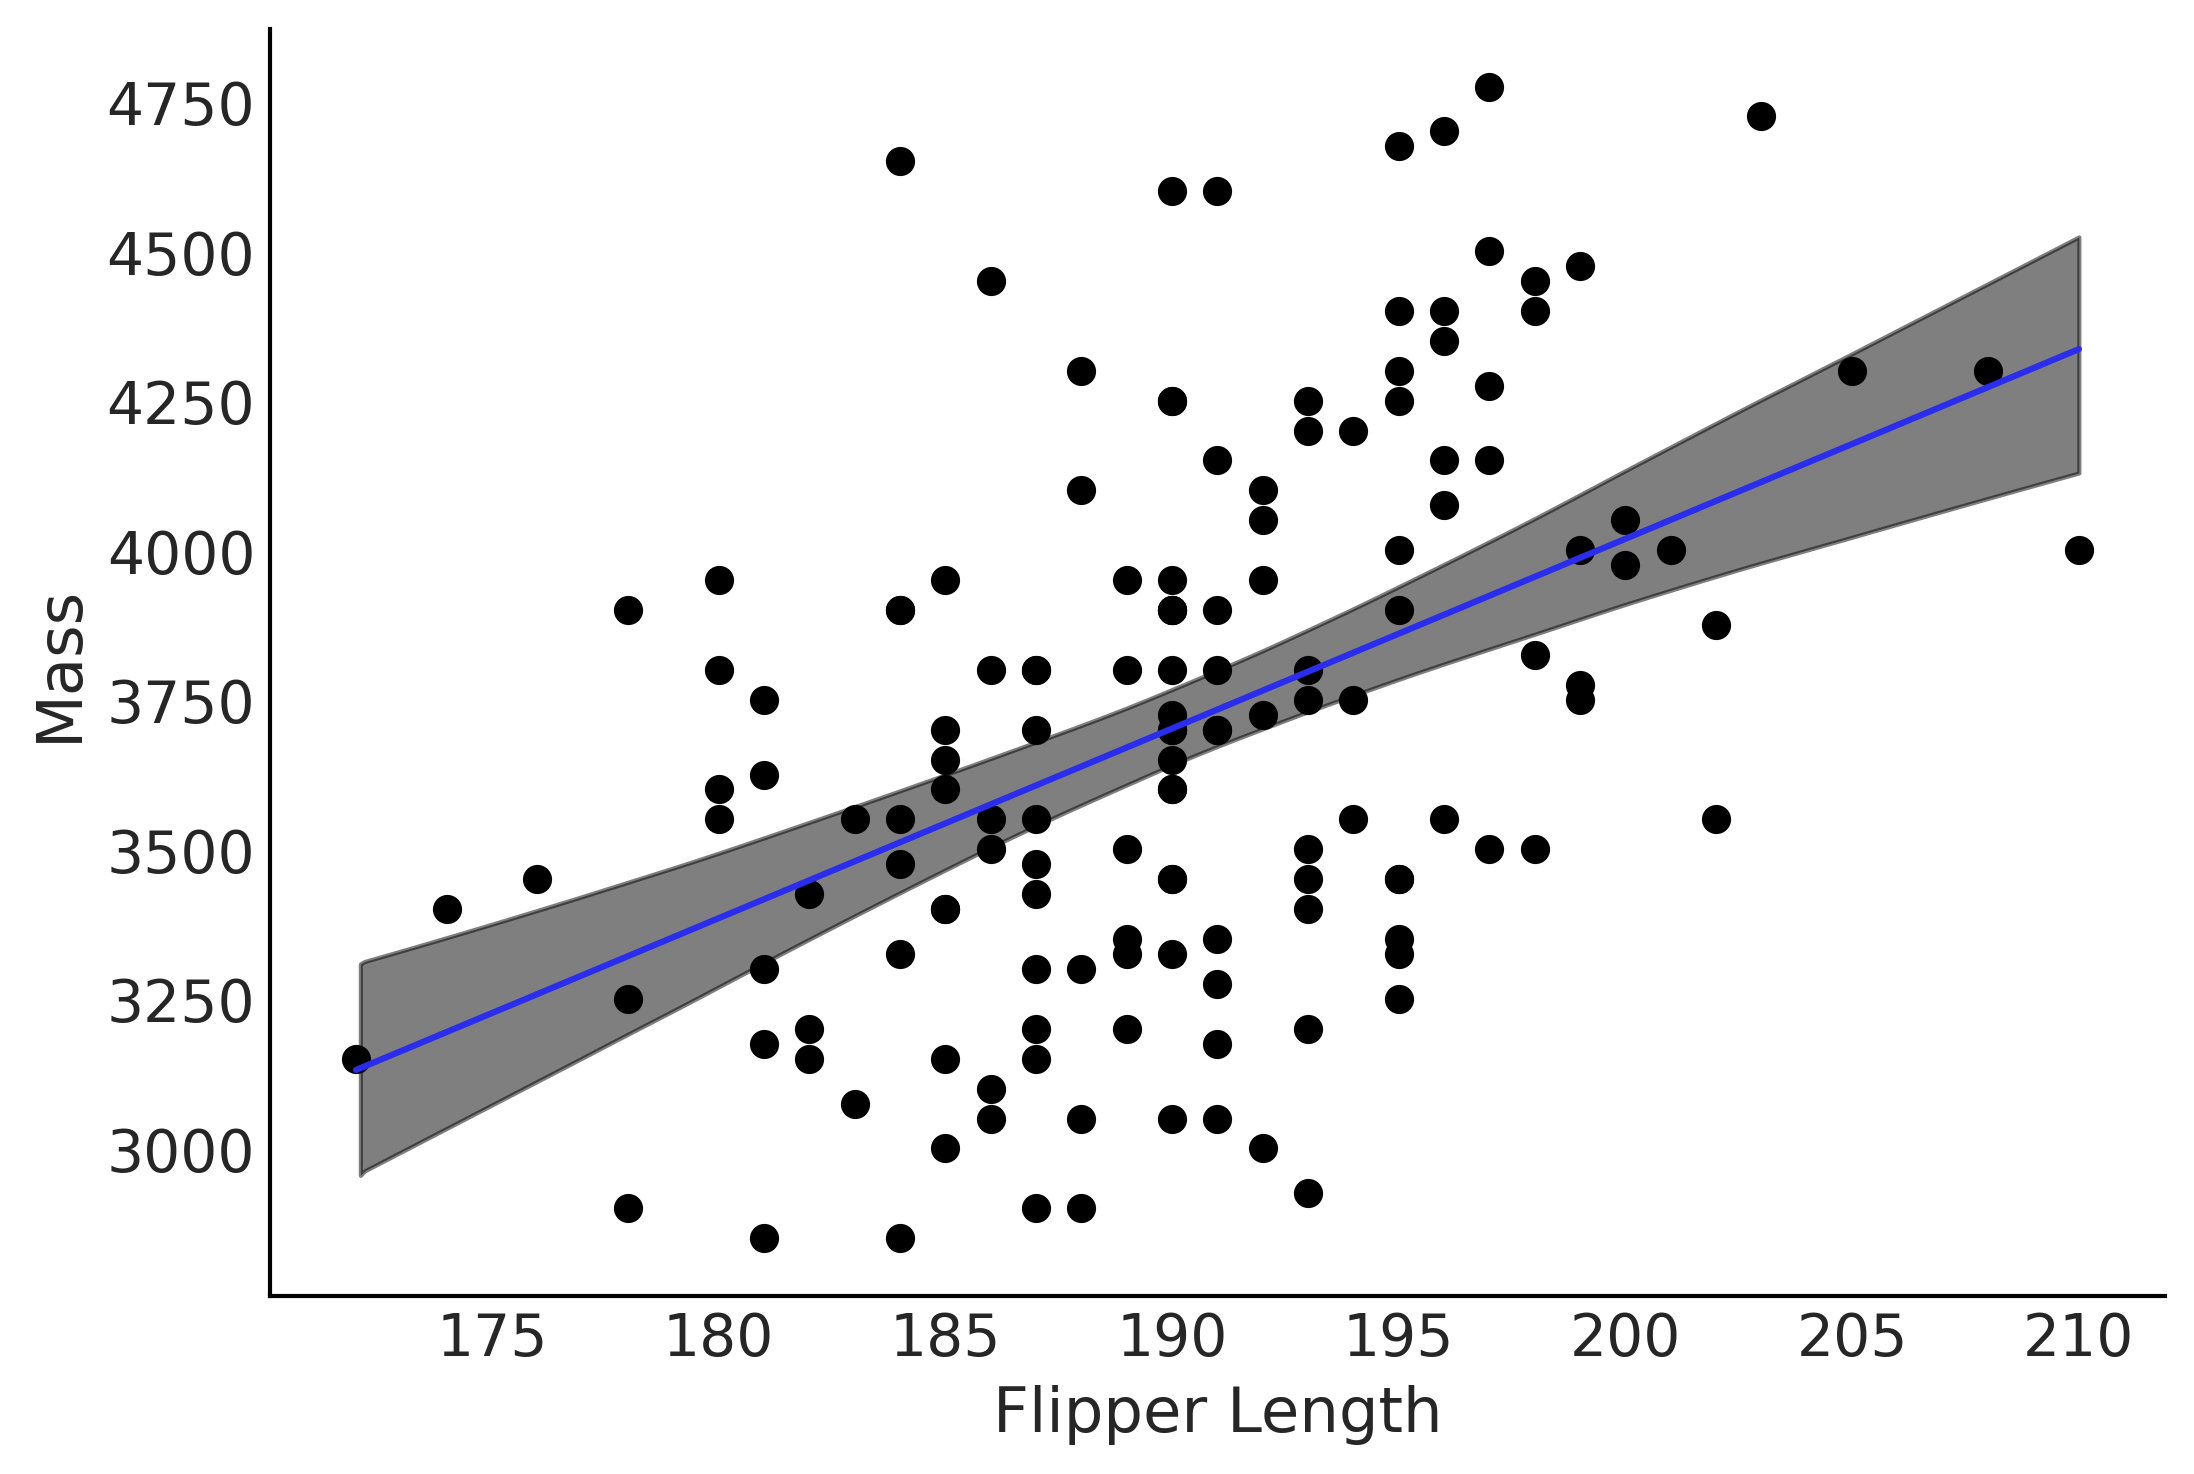

In [29]:
fig, ax = plt.subplots()
alpha_m = inf_data_adelie_flipper_regression.posterior.mean().to_dict()["data_vars"]["β_0"]["data"]
beta_m = inf_data_adelie_flipper_regression.posterior.mean().to_dict()["data_vars"]["β_1"]["data"]

flipper_length = np.linspace(adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100)

flipper_length_mean = alpha_m + beta_m * flipper_length
ax.plot(flipper_length, flipper_length_mean, c='C4',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

ax.scatter(adelie_flipper_length_obs, adelie_mass_obs)

# Figure out how to do this from inference data
az.plot_hdi(adelie_flipper_length_obs, inf_data_adelie_flipper_regression.posterior['μ'], hdi_prob=0.94, color='k', ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');
plt.savefig('img/chp03/flipper_length_mass_regression.png', dpi=300)

### Code 3.14

In [30]:
with model_adelie_flipper_regression:
    # Change the underlying value to the mean observed flipper length
    # for our posterior predictive samples
    pm.set_data({"adelie_flipper_length": [adelie_flipper_length_obs.mean()]})
    posterior_predictions = pm.sample_posterior_predictive(
        inf_data_adelie_flipper_regression.posterior, var_names=["mass", "μ"])

### Figure 3.11

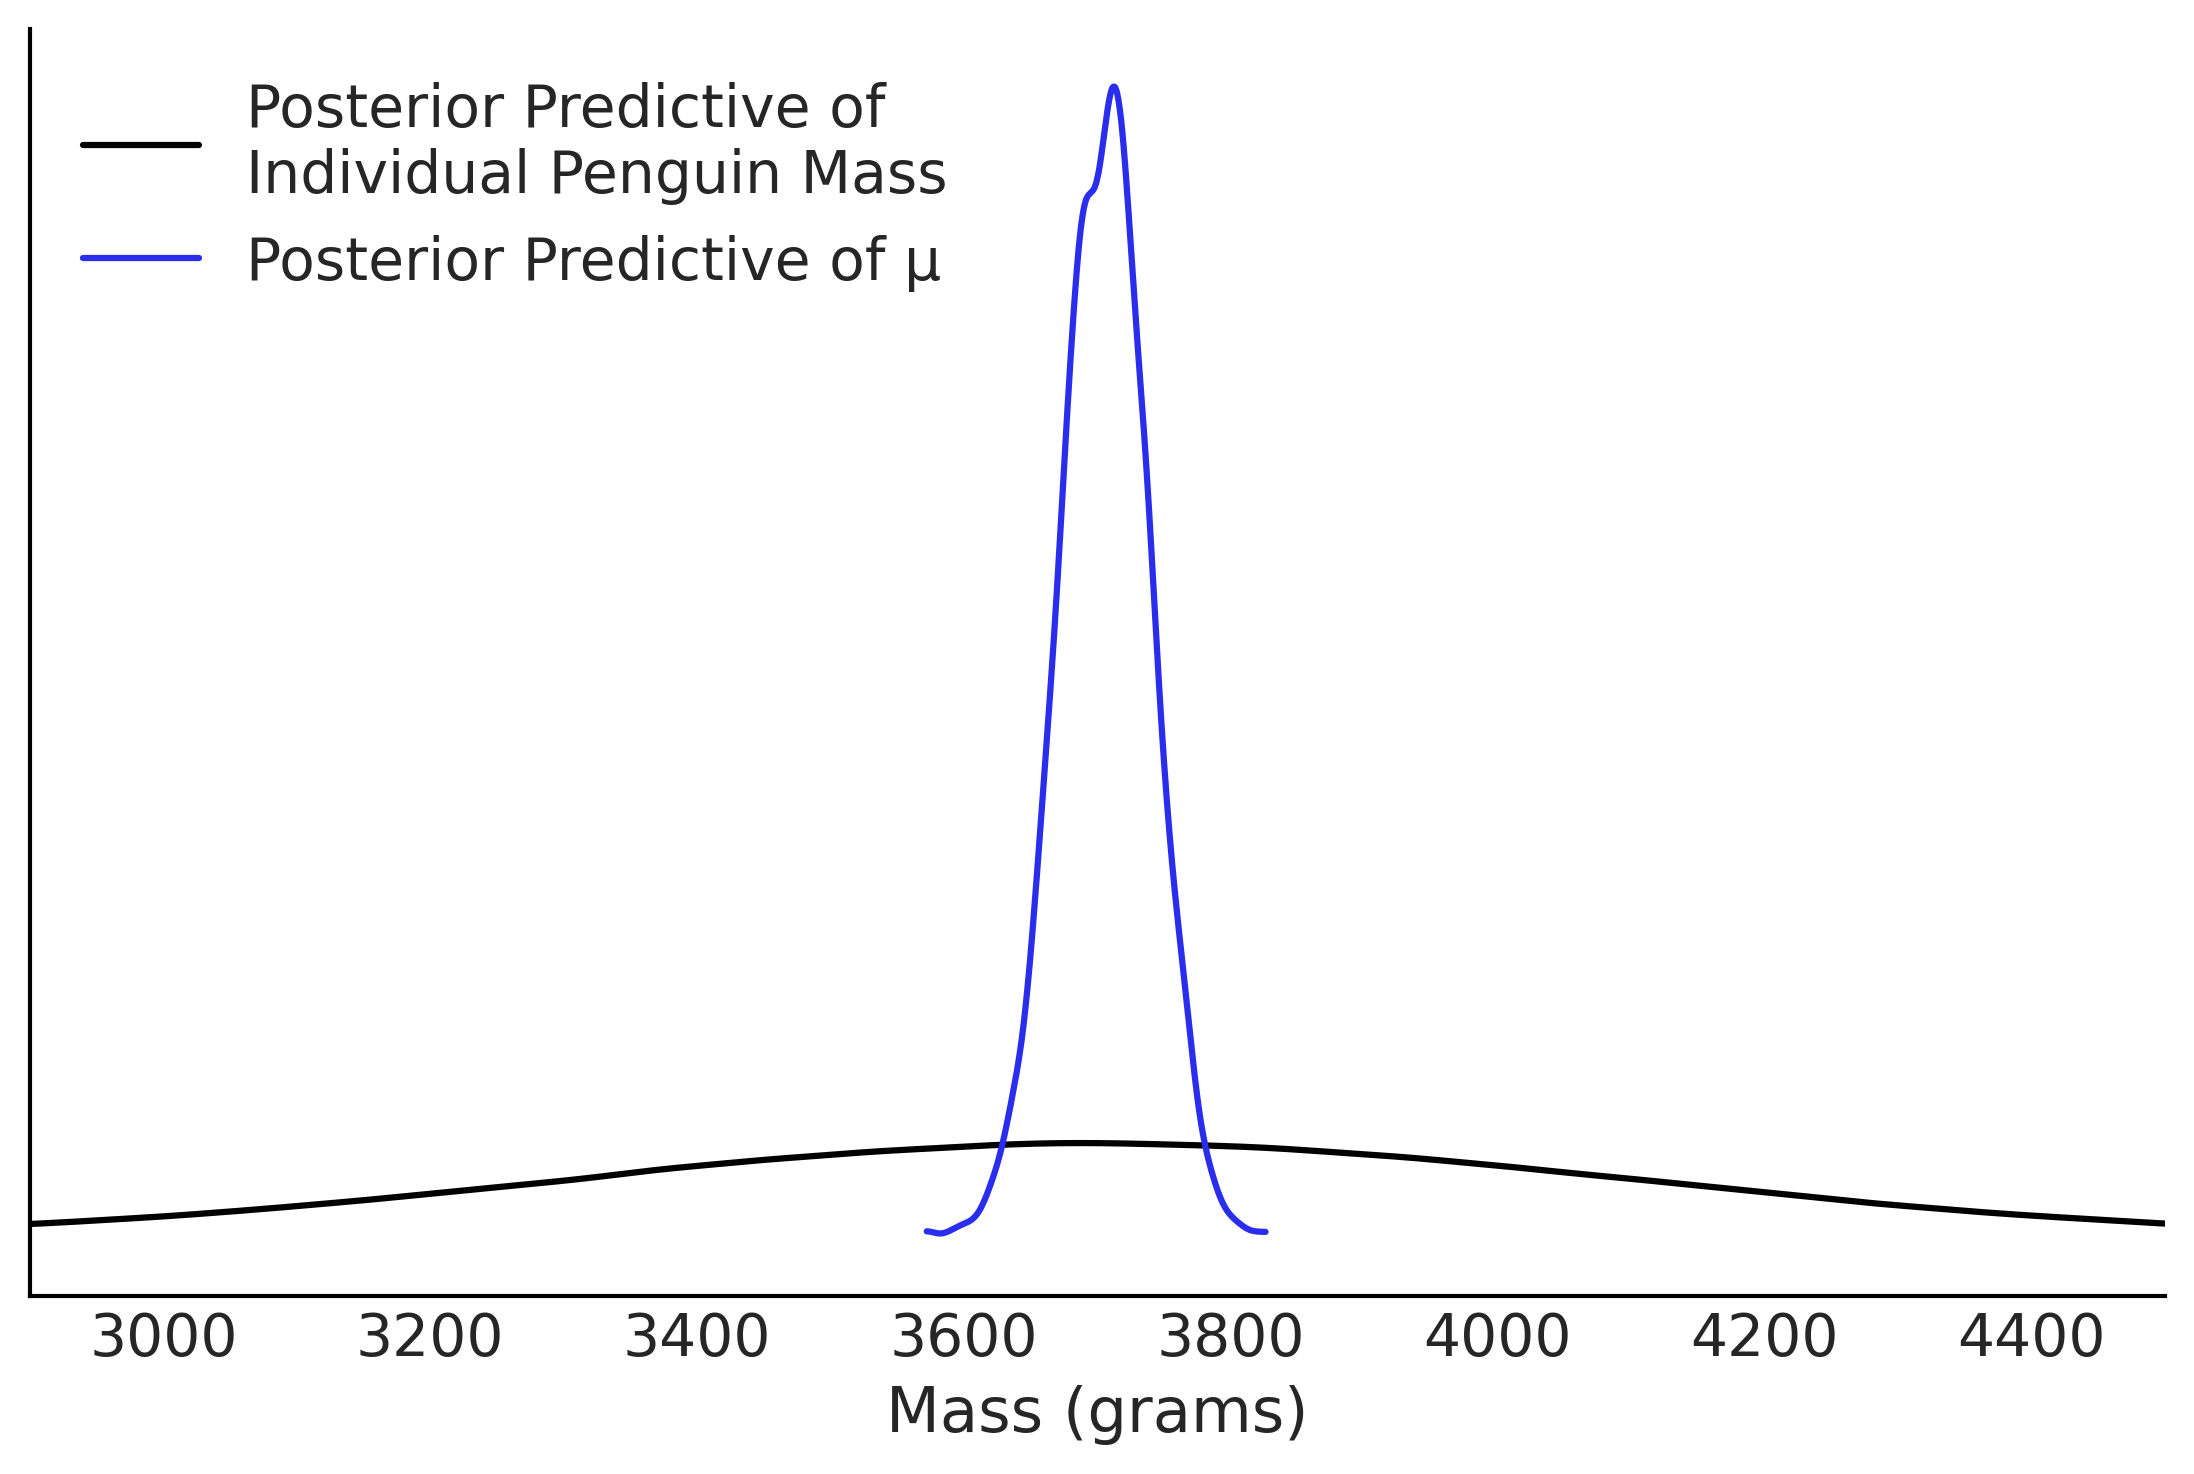

In [31]:
fig, ax = plt.subplots()
az.plot_dist(posterior_predictions["mass"], label="Posterior Predictive of \nIndividual Penguin Mass", ax=ax)
az.plot_dist(posterior_predictions["μ"],label="Posterior Predictive of μ", color="C4", ax=ax)
ax.set_xlim(2900, 4500);
ax.legend(loc=2)
ax.set_xlabel("Mass (grams)")
ax.set_yticks([])
plt.savefig('img/chp03/flipper_length_mass_posterior_predictive.png', dpi=300)

### Code 3.15

In [32]:
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"].values
adelie_flipper_length_c = adelie_flipper_length_obs - adelie_flipper_length_obs.mean()


### PyMC Centered Model

In [33]:
with pm.Model() as model_adelie_flipper_regression:
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_1 = pm.Normal("β_1", 0, 4000)
    β_0 = pm.Normal("β_0", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1*adelie_flipper_length_c)
    
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed = adelie_mass_obs)
    
    # Need to remove this one I find bug
    inf_data_adelie_flipper_length_c = pm.sample(return_inferencedata=True, random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_0, β_1, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


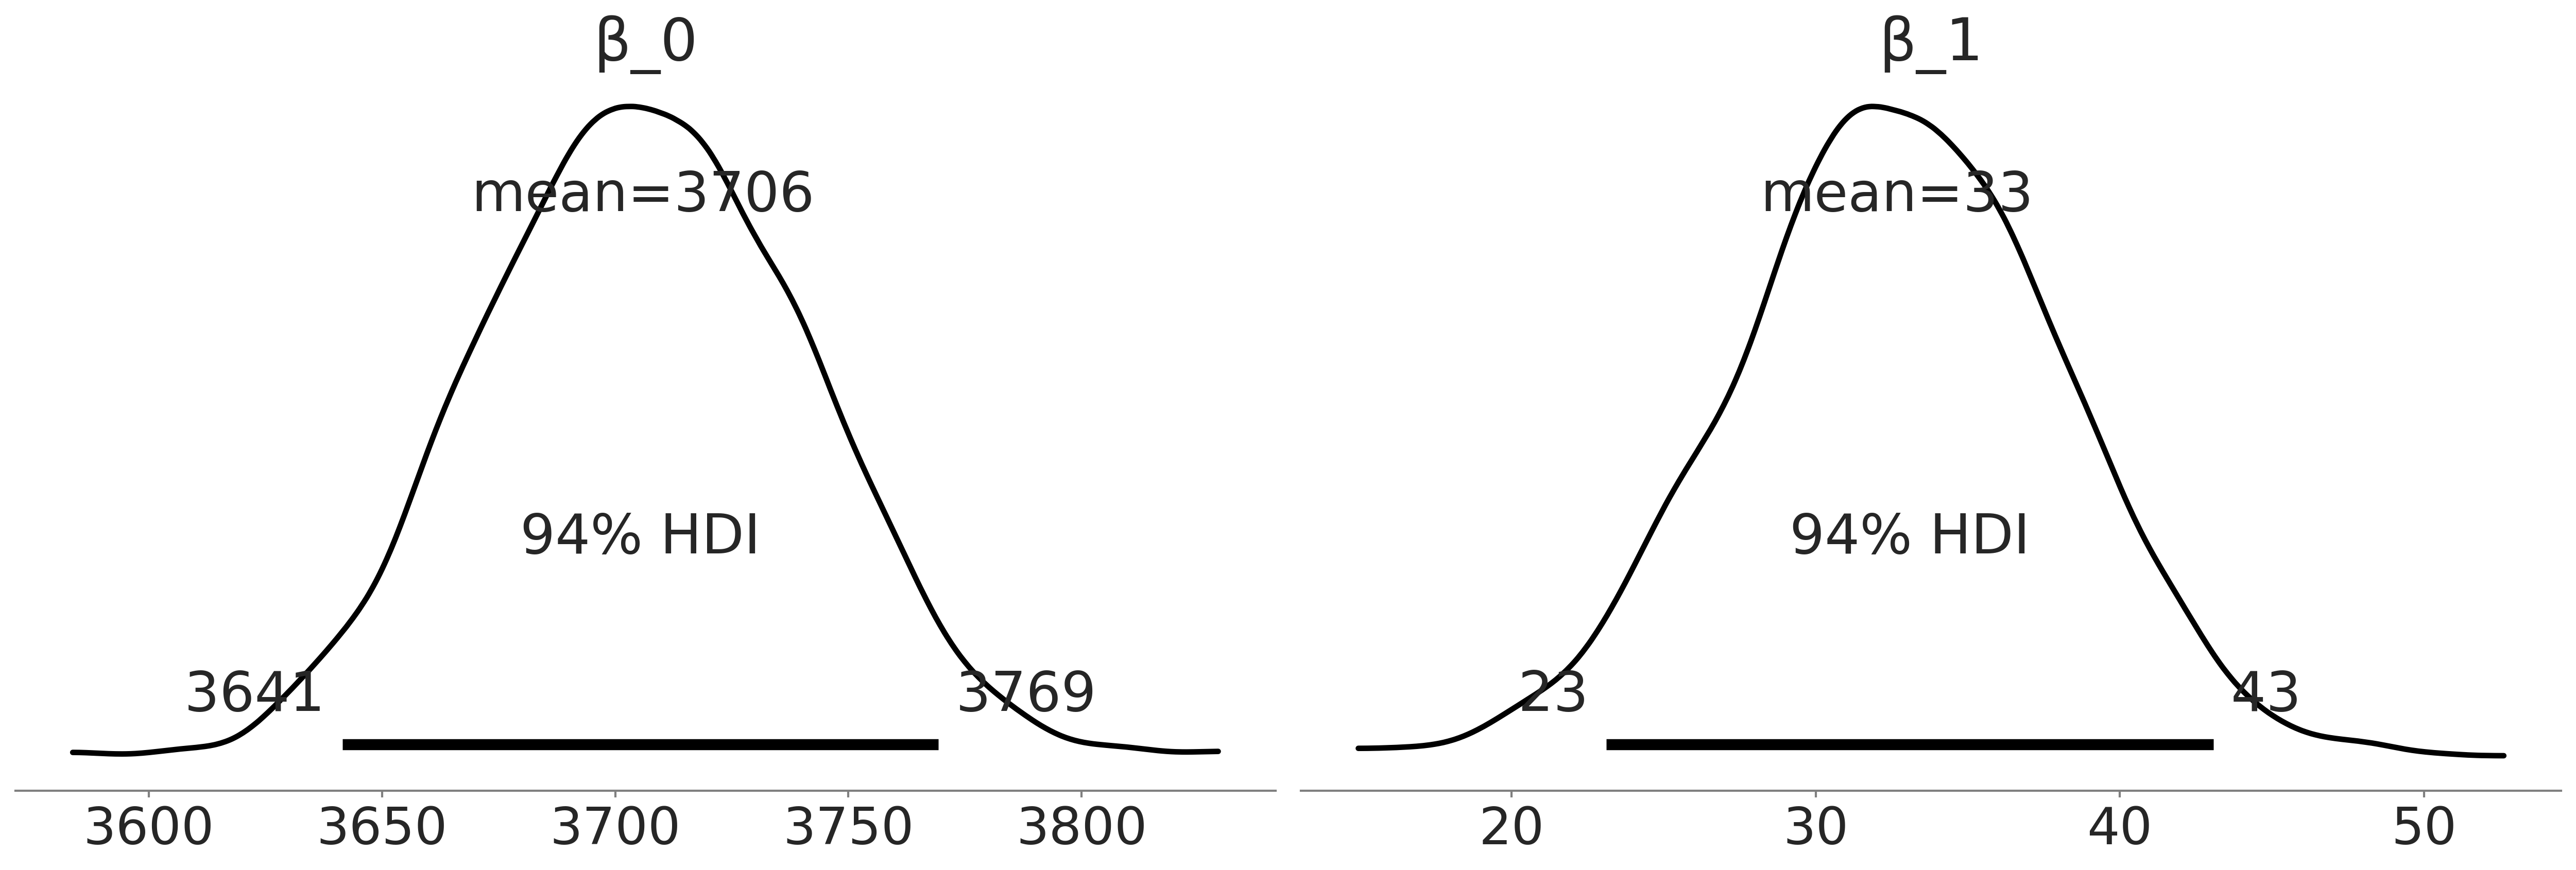

In [34]:
az.plot_posterior(inf_data_adelie_flipper_length_c, var_names = ["β_0", "β_1"], textsize=24);
plt.savefig("img/chp03/singlespecies_multipleregression_centered.png")

### Code 3.16

In [35]:
adelie_flipper_length_c = adelie_flipper_length_obs - adelie_flipper_length_obs.mean()

In [36]:
def gen_adelie_flipper_model(adelie_flipper_length):
    adelie_flipper_length = tf.constant(adelie_flipper_length, tf.float32)

    @tfd.JointDistributionCoroutine
    def jd_adelie_flipper_regression():
        σ = yield root(tfd.HalfStudentT(df=100, loc=0, scale=2000, name='sigma'))
        β_1 = yield root(tfd.Normal(loc=0, scale=4000, name='beta_1'))
        β_0 = yield root(tfd.Normal(loc=0, scale=4000, name='beta_0'))
        μ = β_0[..., None] + β_1[..., None] * adelie_flipper_length
        mass = yield tfd.Independent(
            tfd.Normal(loc=μ, scale=σ[..., None]),
            reinterpreted_batch_ndims=1,
            name='mass')

    return jd_adelie_flipper_regression


# Use non-centered predictor, this gives the same model as
# model_adelie_flipper_regression
jd_adelie_flipper_regression = gen_adelie_flipper_model(
    adelie_flipper_length_obs)

# Use centered predictor
jd_adelie_flipper_regression = gen_adelie_flipper_model(
    adelie_flipper_length_c)

mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_adelie_flipper_regression, n_chains=4, num_adaptation_steps=1000,
    mass=tf.constant(adelie_mass_obs, tf.float32))

inf_data_adelie_flipper_length_c = az.from_dict(
    posterior={
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    }
)

2021-12-18 20:47:16.412125: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2021-12-18 20:47:16.432889: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2021-12-18 20:47:16.444344: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2021-12-18 20:47:16.471273: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2021-12-18 20:47:16.795591: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2021-12-18 20:47:16.803043: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2021-12-18 20:47:16.807013: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed 

### Figure 3.12

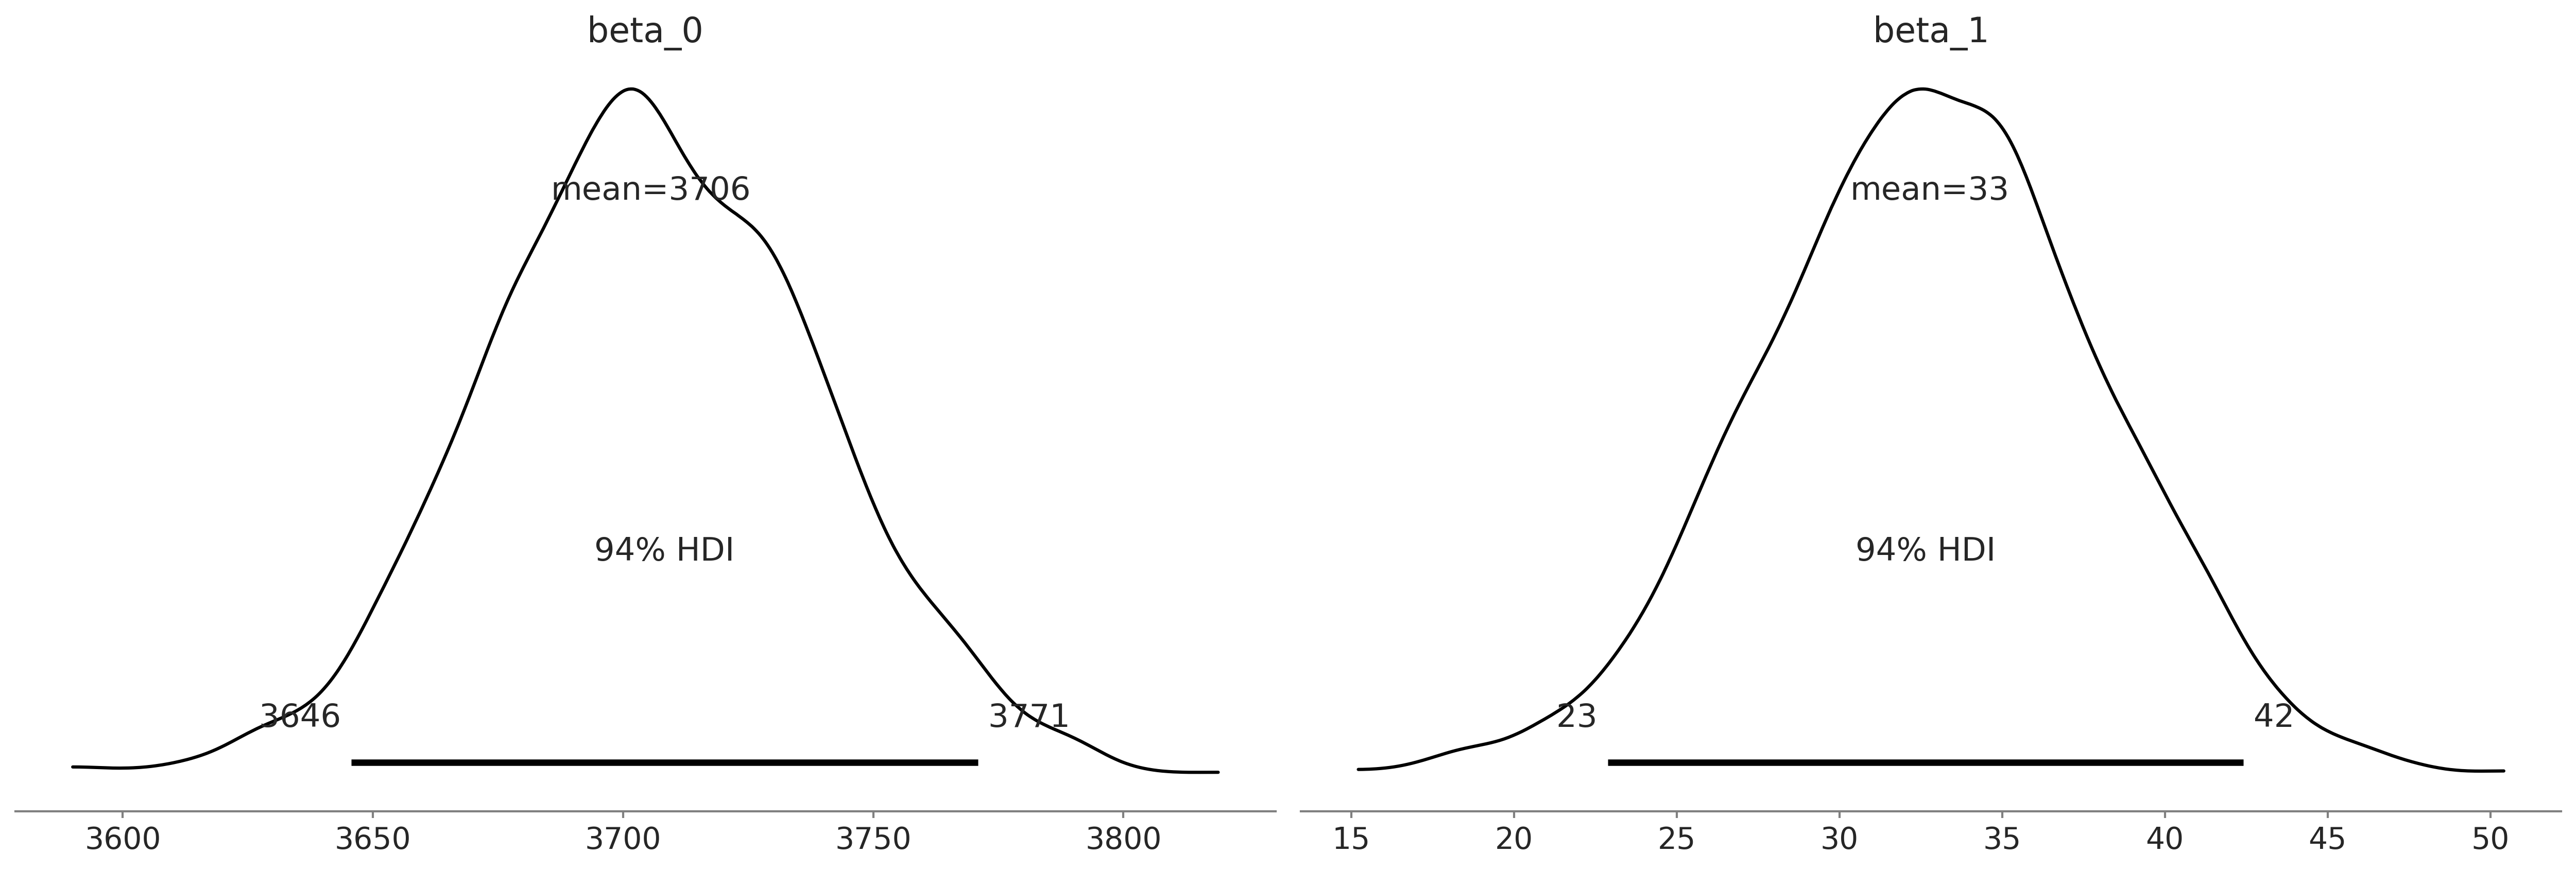

In [37]:
az.plot_posterior(inf_data_adelie_flipper_length_c, var_names = ["beta_0", "beta_1"]);

## Multiple Linear Regression

### Code 3.17

In [38]:
# Binary encoding of the categorical predictor
sex_obs = penguins.loc[adelie_mask ,"sex"].replace({"male":0, "female":1})

with pm.Model() as model_penguin_mass_categorical:
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 3000)
    β_1 = pm.Normal("β_1", 0, 3000)
    β_2 = pm.Normal("β_2", 0, 3000)
    
    μ = pm.Deterministic(
        "μ", β_0 + β_1 * adelie_flipper_length_obs + β_2 * sex_obs)
    
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)
    
    inf_data_penguin_mass_categorical = pm.sample(
        target_accept=.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_2, β_1, β_0, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


### Figure 3.13

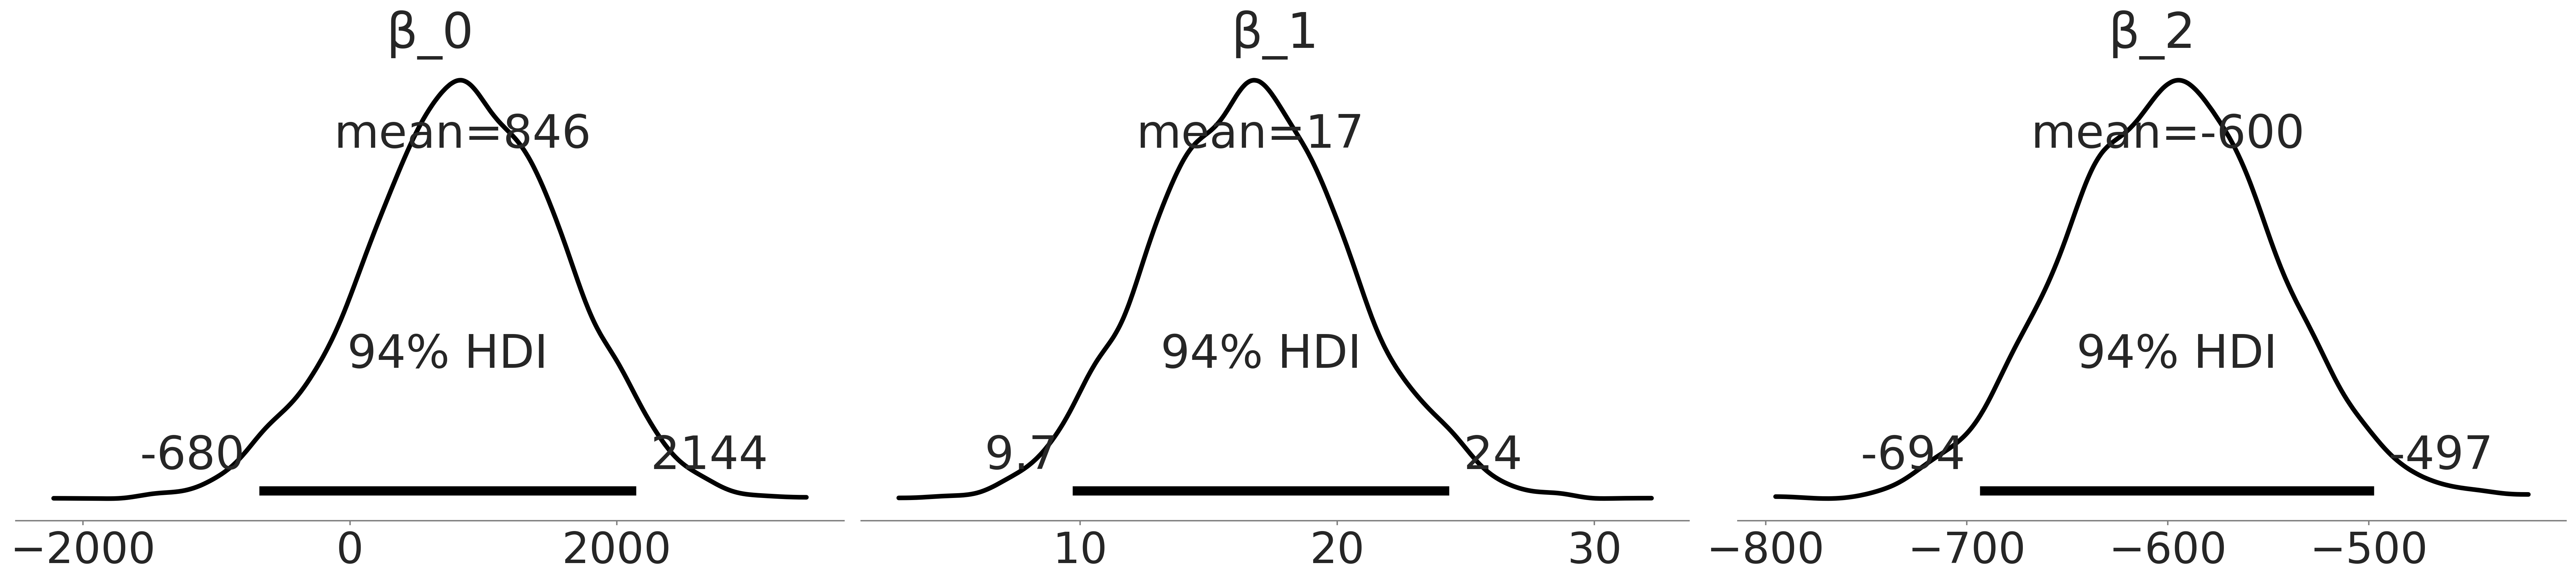

In [39]:
az.plot_posterior(inf_data_penguin_mass_categorical, var_names =["β_0", "β_1", "β_2"], textsize=30)
plt.savefig("img/chp03/adelie_sex_coefficient_posterior.png")

In [40]:
az.summary(inf_data_penguin_mass_categorical, var_names=["β_0","β_1","β_2", "σ"])

mean       sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β_0  845.533  749.469 -679.716  2144.105     20.356   14.553    1360.0   
β_1   16.626    3.893    9.702    24.352      0.105    0.075    1370.0   
β_2 -599.878   52.418 -693.529  -497.431      1.161    0.827    2039.0   
σ    297.900   17.592  264.834   330.015      0.376    0.268    2236.0   

     ess_tail  r_hat  
β_0    1611.0    1.0  
β_1    1598.0    1.0  
β_2    1977.0    1.0  
σ      2082.0    1.0

### Code 3.19 and Figure 3.15

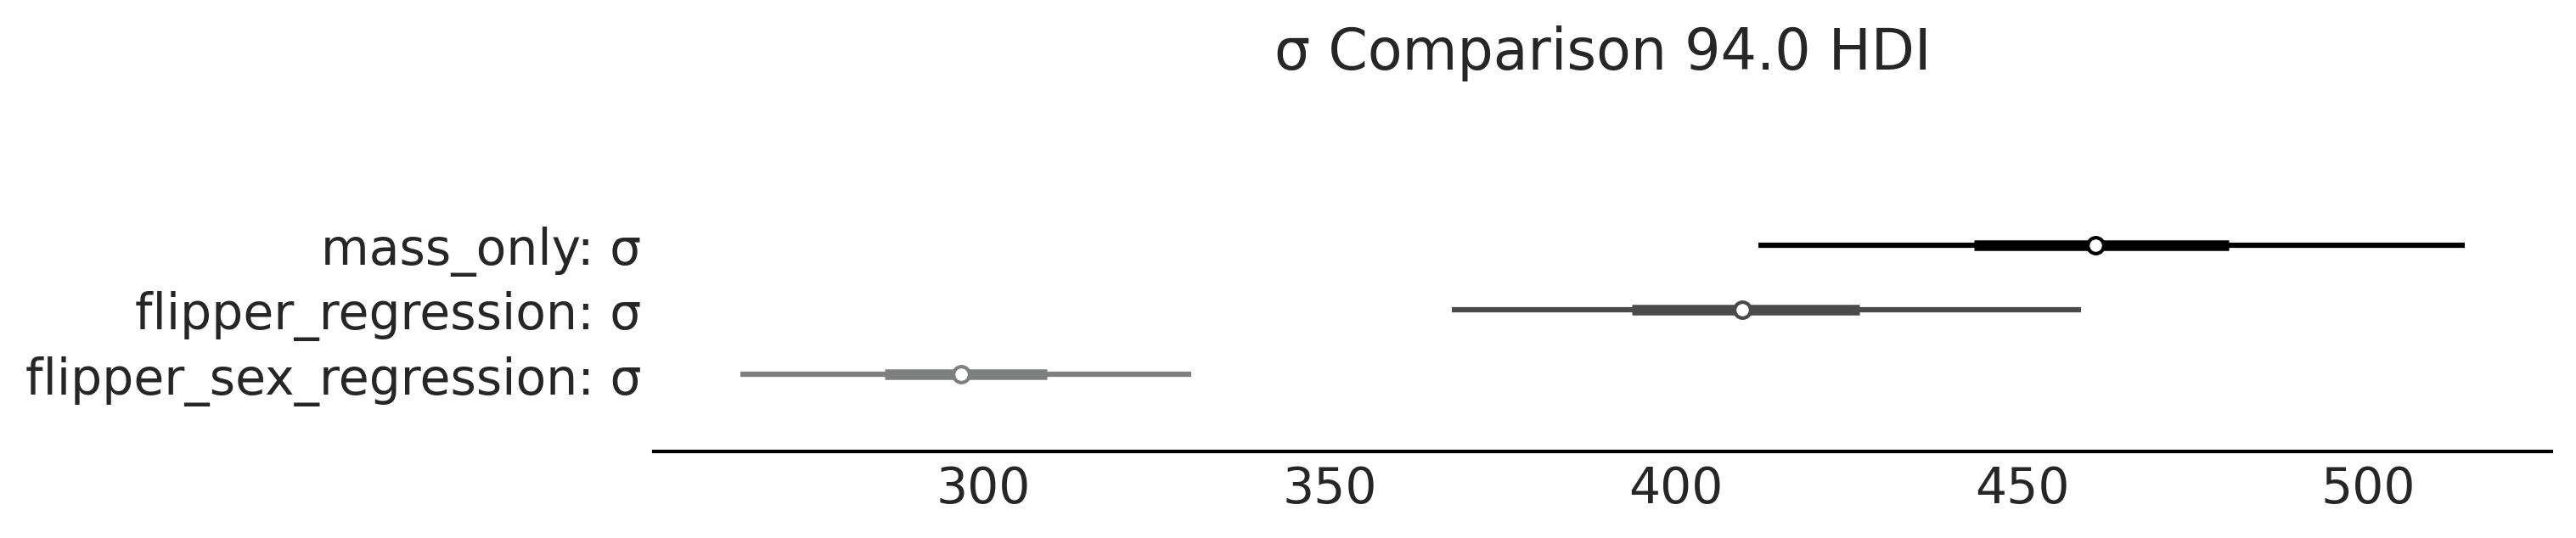

In [41]:
axes = az.plot_forest(
    [inf_data_adelie_penguin_mass, inf_data_adelie_flipper_regression, inf_data_penguin_mass_categorical],
    model_names=["mass_only", "flipper_regression", "flipper_sex_regression"],
    var_names=["σ"], combined=True, figsize=(10,2))

axes[0].set_title("σ Comparison 94.0 HDI")
plt.savefig("img/chp03/singlespecies_multipleregression_forest_sigma_comparison.png")

### Figure 3.14

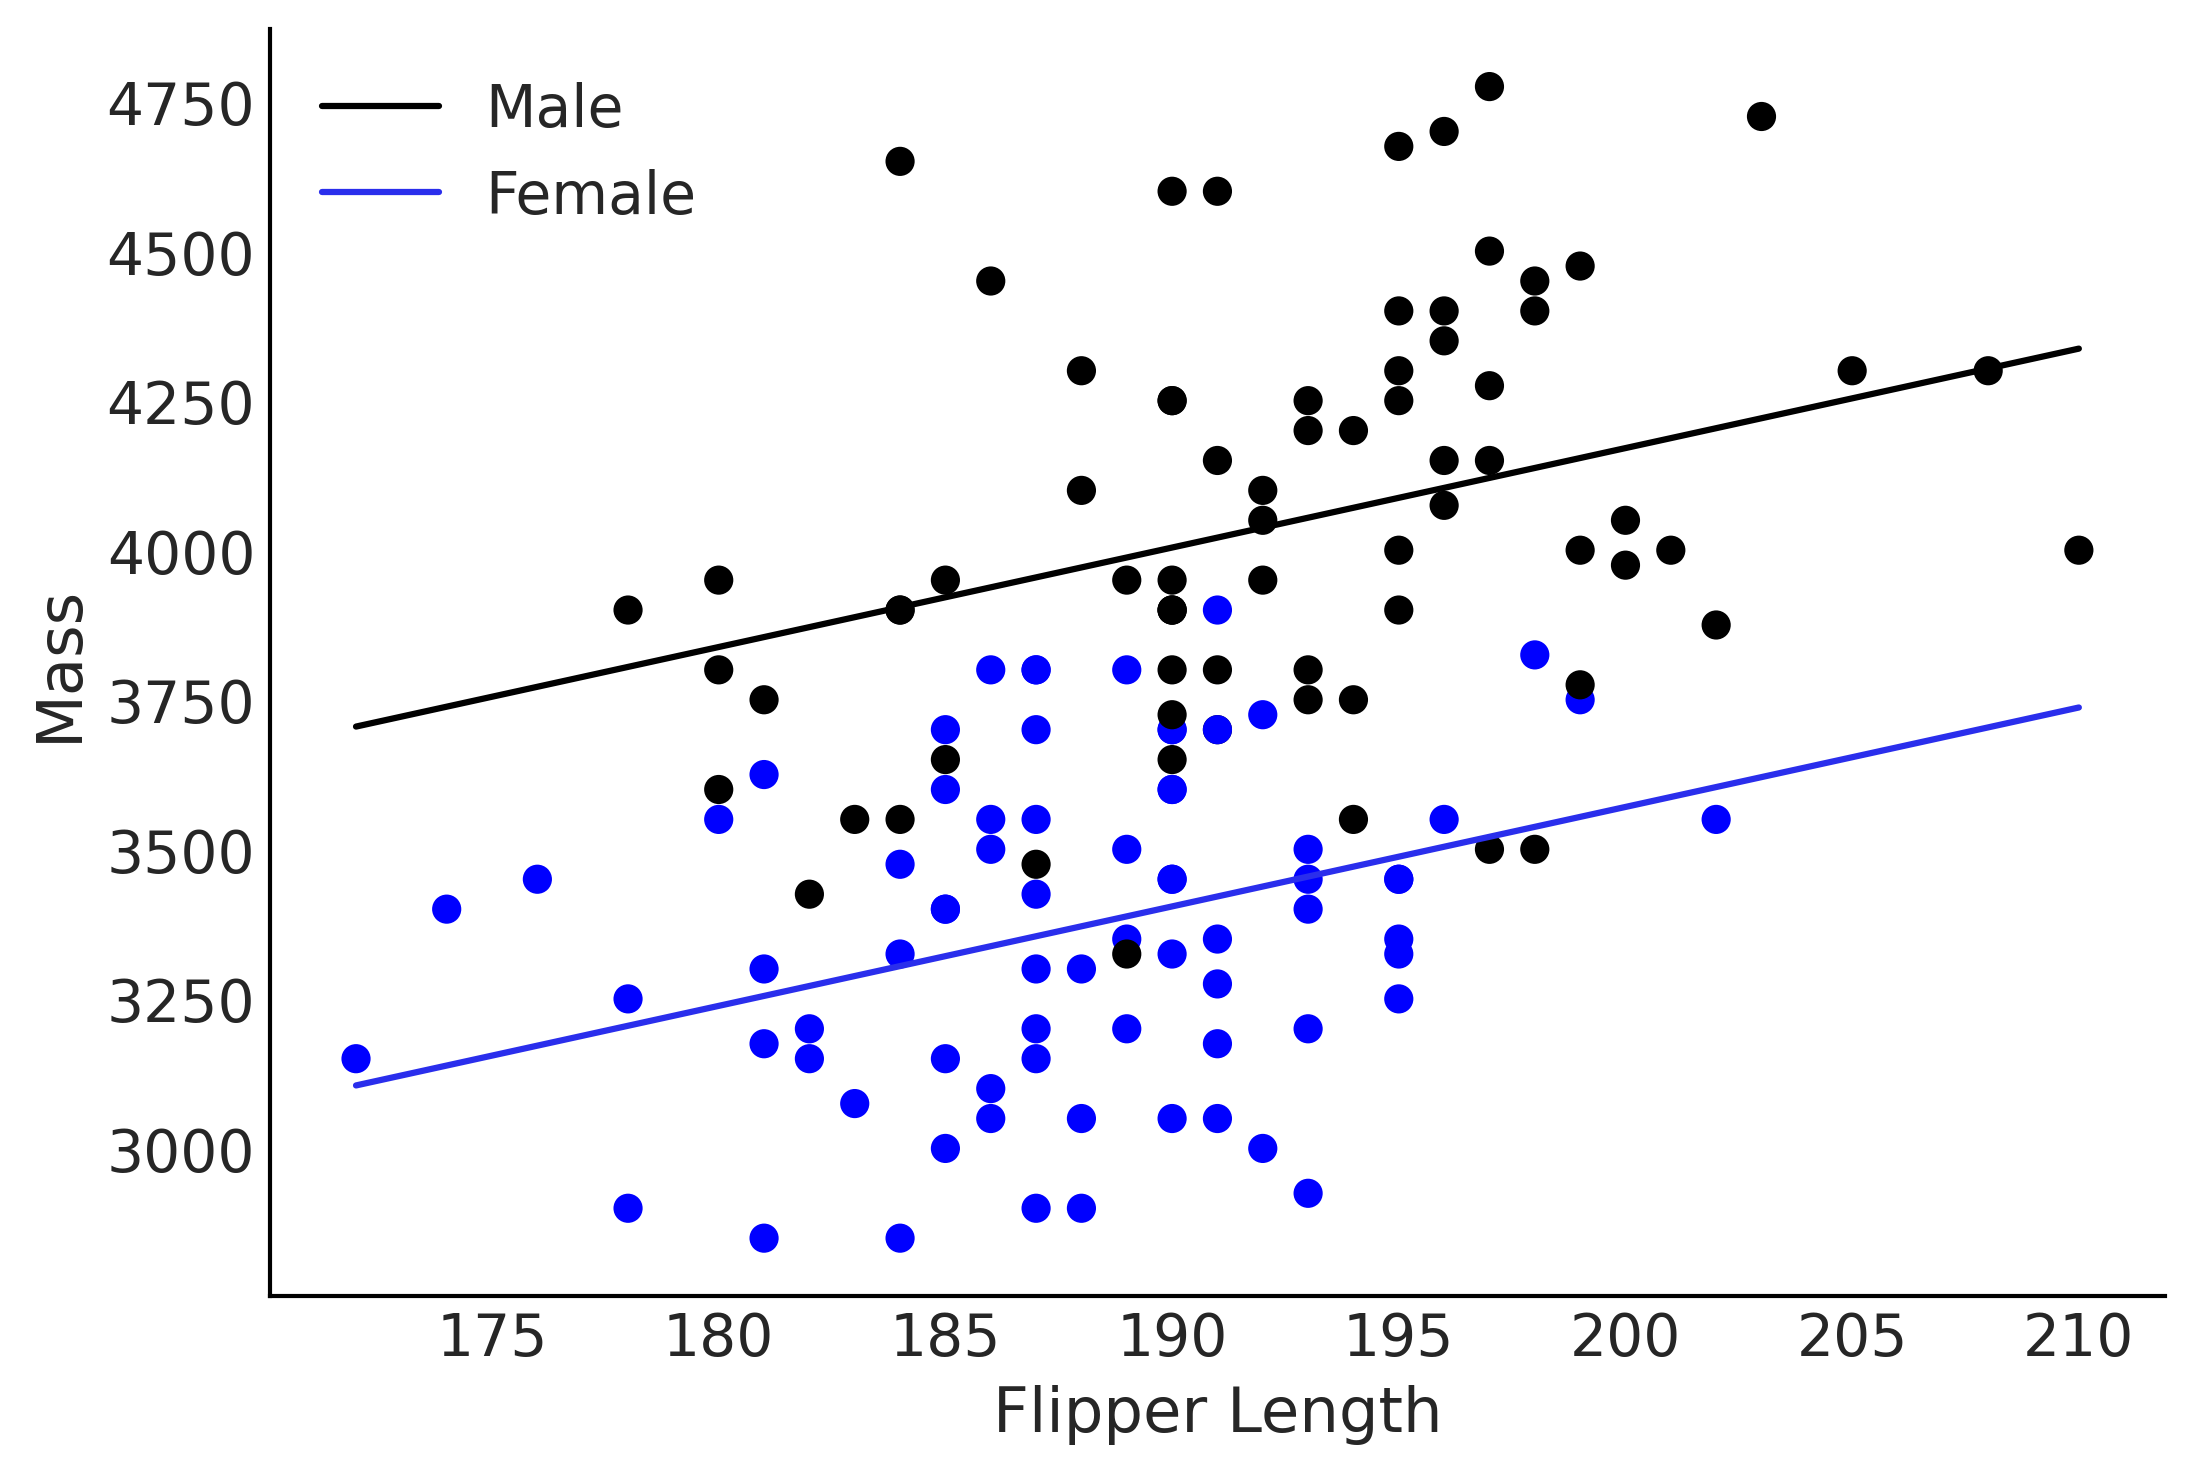

In [42]:
# Fix colors
fig, ax = plt.subplots()
alpha_1 = inf_data_penguin_mass_categorical.posterior.mean().to_dict()["data_vars"]["β_0"]["data"]
beta_1 = inf_data_penguin_mass_categorical.posterior.mean().to_dict()["data_vars"]["β_1"]["data"]
beta_2 = inf_data_penguin_mass_categorical.posterior.mean().to_dict()["data_vars"]["β_2"]["data"]


flipper_length = np.linspace(adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100)

mass_mean_male = alpha_1 + beta_1 * flipper_length
mass_mean_female = alpha_1 + beta_1 * flipper_length + beta_2

ax.plot(flipper_length, mass_mean_male,
         label="Male")

ax.plot(flipper_length, mass_mean_female, c='C4',
         label="Female")

ax.scatter(adelie_flipper_length_obs, adelie_mass_obs, c=[{0:"k", 1:"b"}[code] for code in sex_obs.values])

# Figure out how to do this from inference data
#az.plot_hpd(adelie_flipper_length, trace.get_values(varname="μ"), credible_interval=0.94, color='k', ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');
ax.legend()
plt.savefig("img/chp03/single_species_categorical_regression.png")

In [43]:
def gen_jd_flipper_bill_sex(flipper_length, sex, bill_length, dtype=tf.float32):
    flipper_length, sex, bill_length = tf.nest.map_structure(
        lambda x: tf.constant(x, dtype), 
        (flipper_length, sex, bill_length)
    )

    @tfd.JointDistributionCoroutine
    def jd_flipper_bill_sex():
        σ = yield root(
            tfd.HalfStudentT(df=100, loc=0, scale=2000, name="sigma"))
        β_0 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_0"))
        β_1 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_1"))
        β_2 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_2"))
        β_3 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_3"))
        μ = (β_0[..., None] 
             + β_1[..., None] * flipper_length 
             + β_2[..., None] * sex
             + β_3[..., None] * bill_length
            )
        mass = yield tfd.Independent(
            tfd.Normal(loc=μ, scale=σ[..., None]),
            reinterpreted_batch_ndims=1,
            name="mass")

    return jd_flipper_bill_sex

bill_length_obs = penguins.loc[adelie_mask, "bill_length_mm"]
jd_flipper_bill_sex = gen_jd_flipper_bill_sex(
    adelie_flipper_length_obs, sex_obs, bill_length_obs)

mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_flipper_bill_sex, n_chains=4, num_adaptation_steps=1000,
    mass=tf.constant(adelie_mass_obs, tf.float32))

2021-12-18 20:48:11.203018: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2021-12-18 20:48:11.232672: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2021-12-18 20:48:11.243727: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2021-12-18 20:48:11.287469: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2021-12-18 20:48:11.734046: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2021-12-18 20:48:11.744086: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2021-12-18 20:48:11.751730: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed 

In [44]:
inf_data_model_penguin_flipper_bill_sex = az.from_dict(
    posterior={
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
)

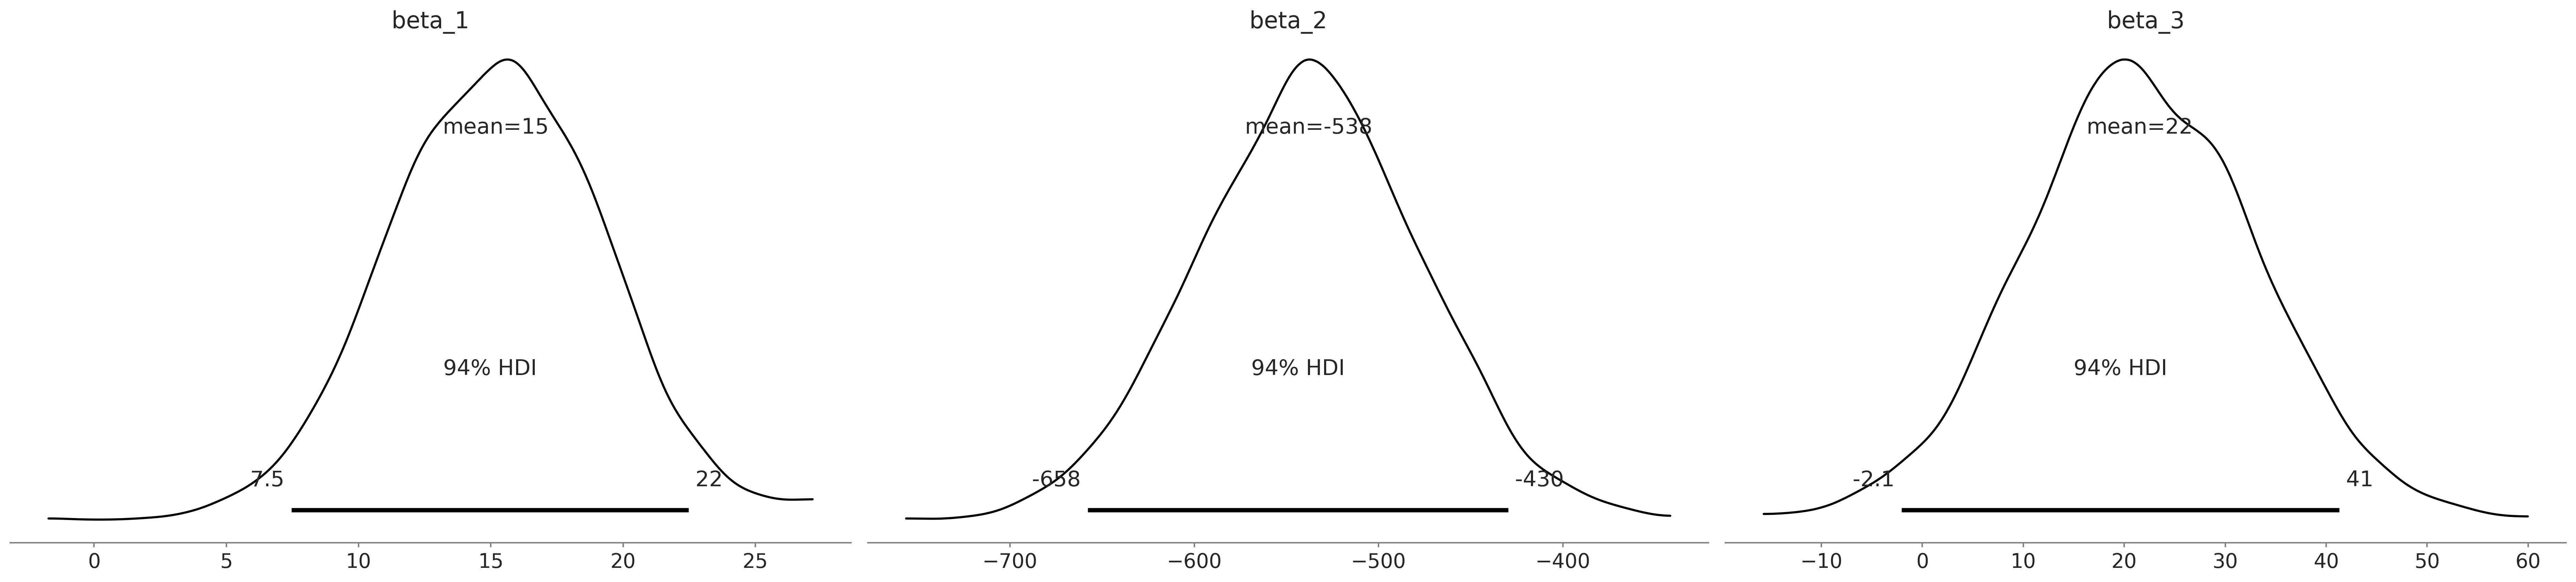

In [45]:
az.plot_posterior(inf_data_model_penguin_flipper_bill_sex, var_names=["beta_1", "beta_2", "beta_3"]);

In [46]:
az.summary(inf_data_model_penguin_flipper_bill_sex, var_names=["beta_1", "beta_2", "beta_3", "sigma"])

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_1   15.186   4.030    7.460   22.477      0.101    0.072    1604.0   
beta_2 -538.014  60.672 -657.765 -429.722      1.334    0.944    2069.0   
beta_3   21.515  11.486   -2.061   41.310      0.255    0.182    2026.0   
sigma   294.728  17.515  262.270  326.914      0.322    0.228    2931.0   

        ess_tail  r_hat  
beta_1    1741.0    1.0  
beta_2    2487.0    1.0  
beta_3    2113.0    1.0  
sigma     2347.0    1.0

### Code 3.21

In [47]:
mean_flipper_length = penguins.loc[adelie_mask, "flipper_length_mm"].mean()
# Counterfactual dimensions is set to 21 to allow us to get the mean exactly
counterfactual_flipper_lengths = np.linspace(
    mean_flipper_length-20, mean_flipper_length+20, 21)
sex_male_indicator = np.zeros_like(counterfactual_flipper_lengths)
mean_bill_length = np.ones_like(
    counterfactual_flipper_lengths) * bill_length_obs.mean()

jd_flipper_bill_sex_counterfactual = gen_jd_flipper_bill_sex(
    counterfactual_flipper_lengths, sex_male_indicator, mean_bill_length)
ppc_samples = jd_flipper_bill_sex_counterfactual.sample(value=mcmc_samples)
estimated_mass = ppc_samples[-1].numpy().reshape(-1, 21)

### Figure 3.16

/home/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


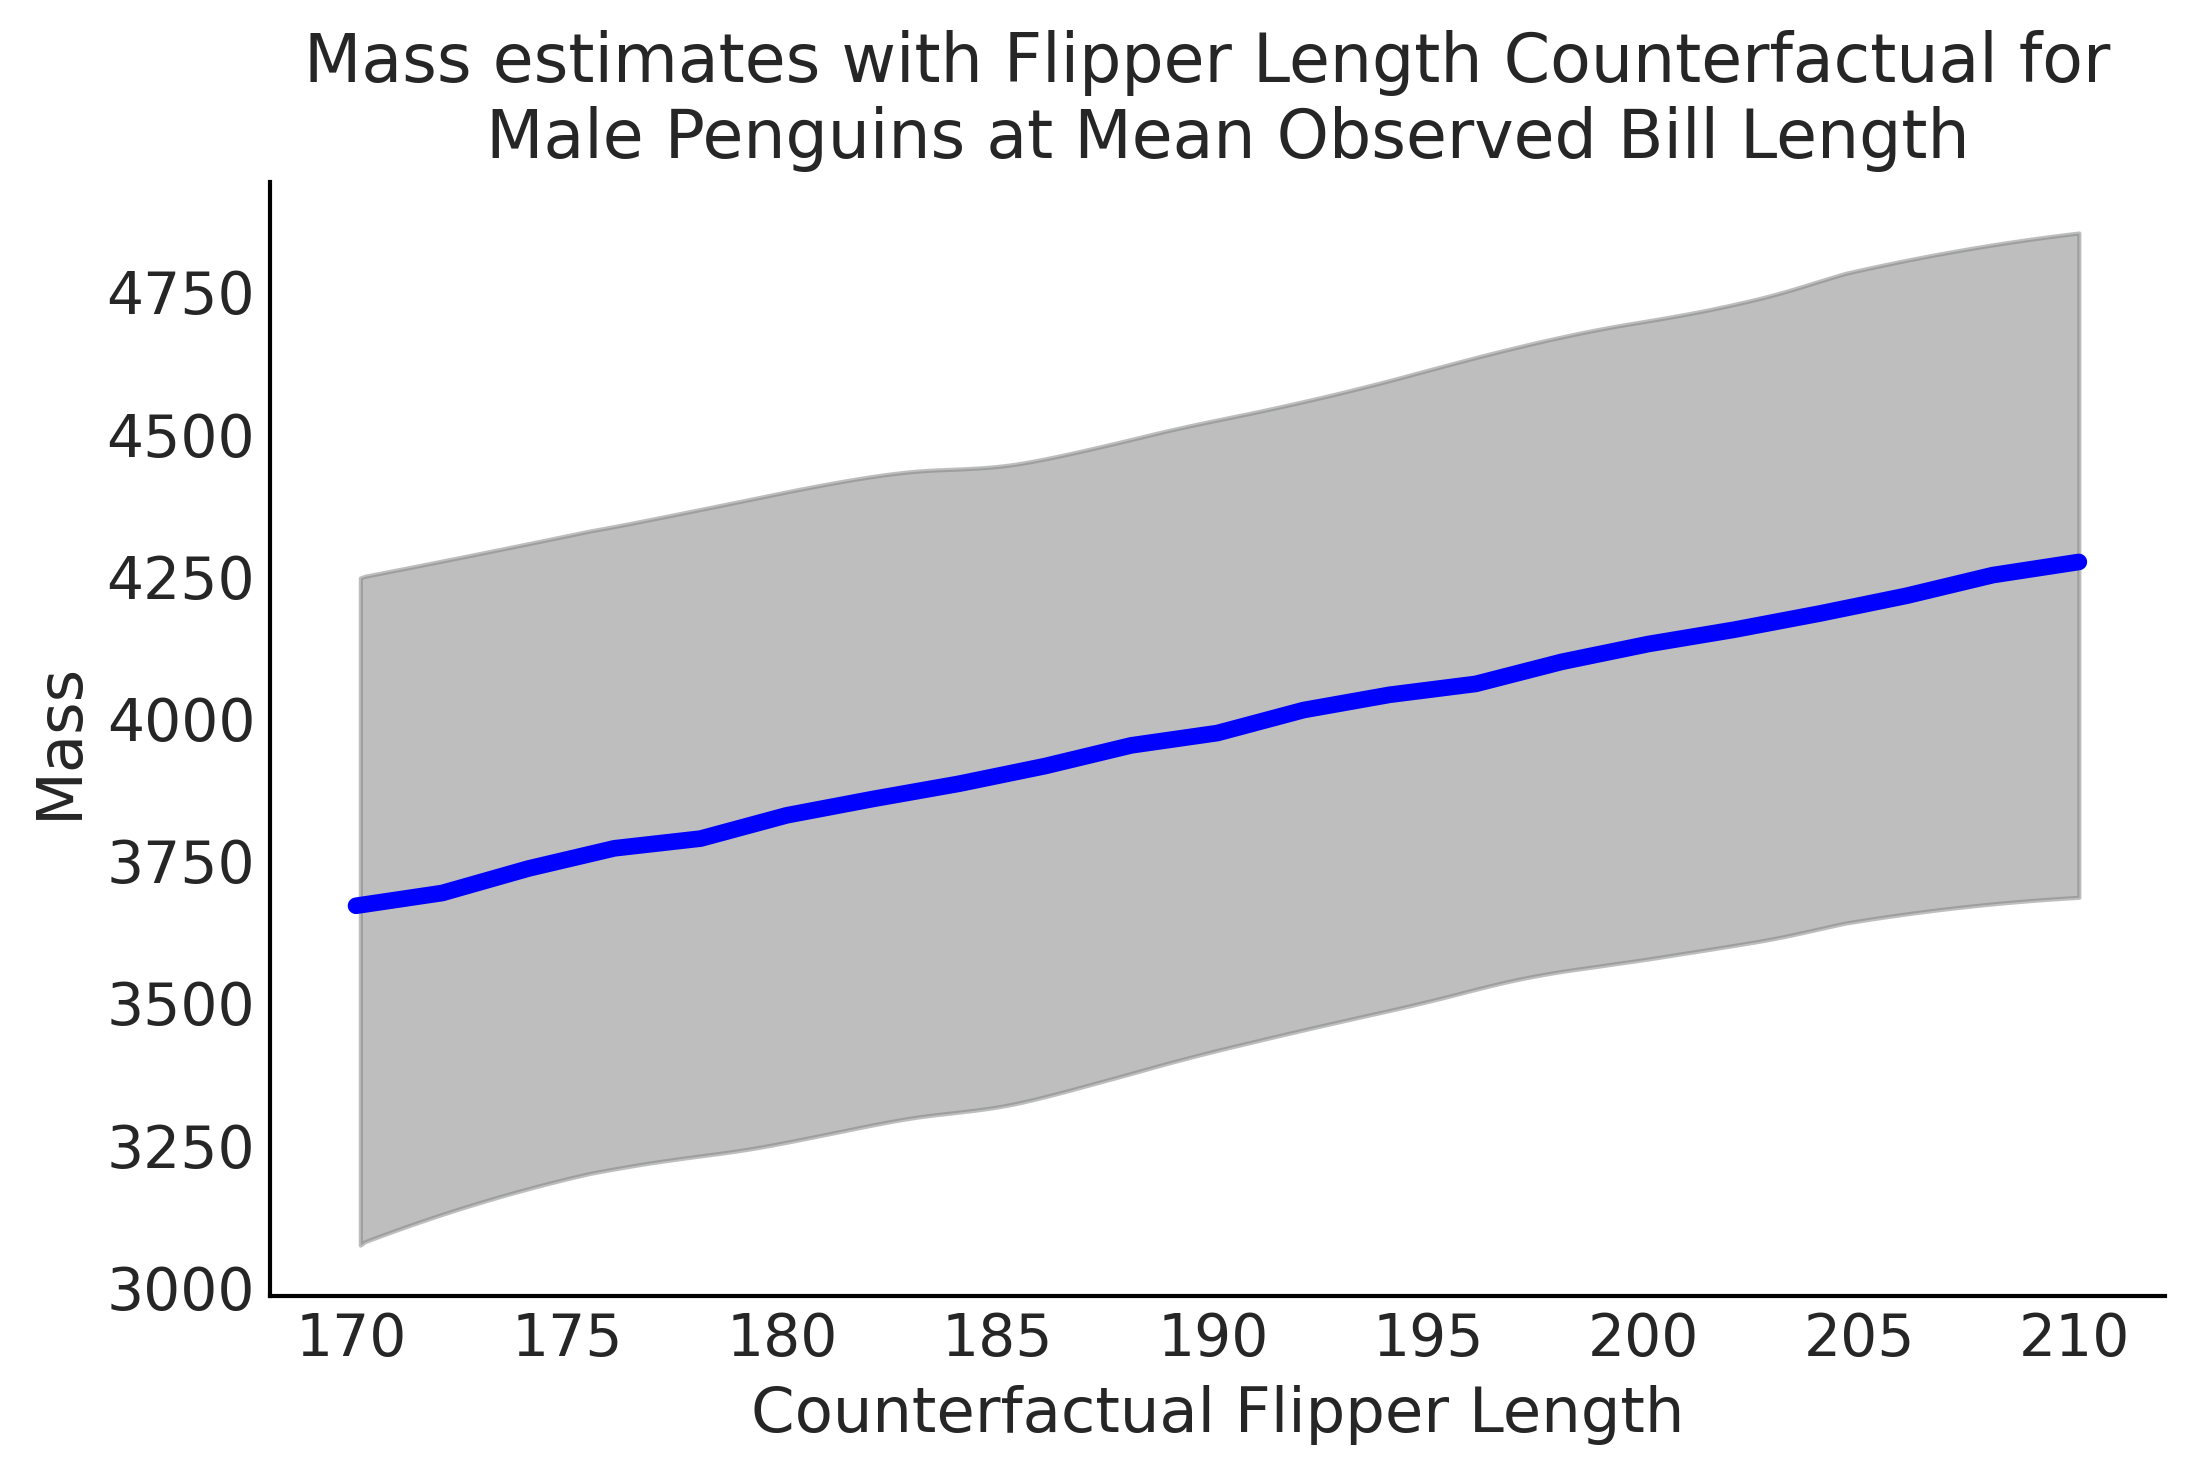

In [48]:
az.plot_hdi(counterfactual_flipper_lengths, estimated_mass, color="C2", plot_kwargs={"ls": "--"})
plt.plot(counterfactual_flipper_lengths, estimated_mass.mean(axis=0), lw=4, c="blue")
plt.title("Mass estimates with Flipper Length Counterfactual for \n Male Penguins at Mean Observed Bill Length")
plt.xlabel("Counterfactual Flipper Length")
plt.ylabel("Mass")
plt.savefig("img/chp03/linear_counter_factual.png")

## Generalized Linear Models

### Figure 3.17

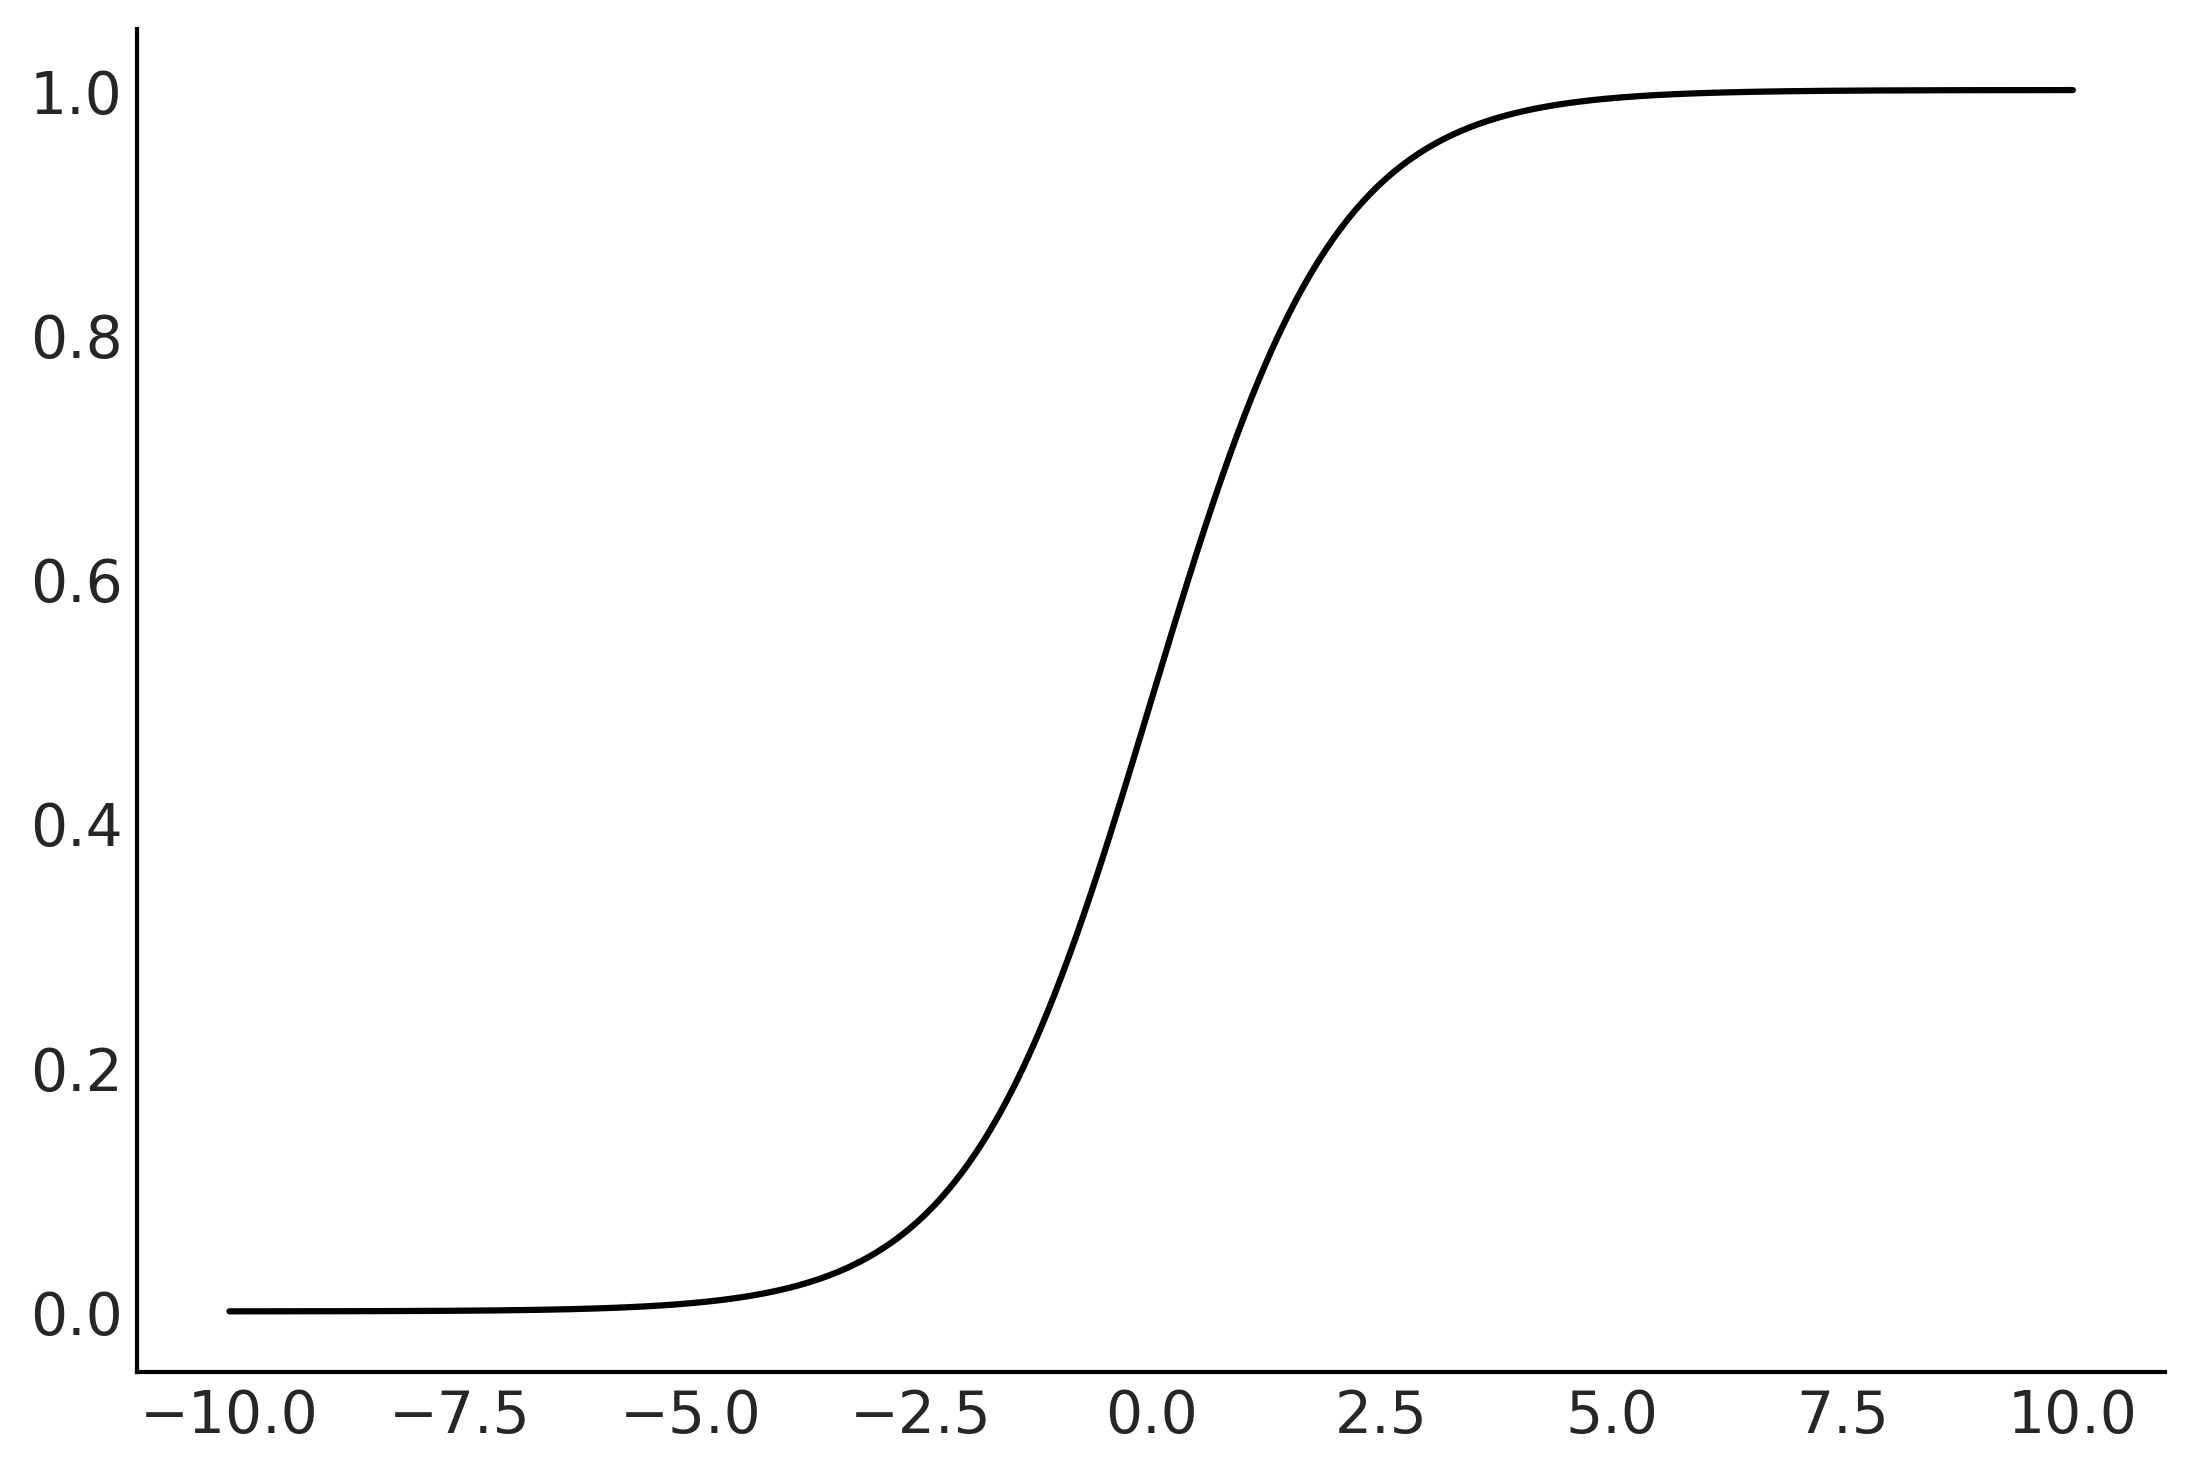

In [49]:
x = np.linspace(-10, 10, 1000)
y = special.expit(x)

plt.plot(x,y)
plt.savefig("img/chp03/logistic.png")

### Code 3.22

In [50]:
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
bill_length_obs = penguins.loc[species_filter, "bill_length_mm"].values
species = pd.Categorical(penguins.loc[species_filter, "species"])

with pm.Model() as model_logistic_penguins_bill_length:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)
    
    μ = β_0 + pm.math.dot(bill_length_obs, β_1)  
    
    # Application of our sigmoid  link function
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    
    # Useful for plotting the decision boundary later
    bd = pm.Deterministic("bd", -β_0/β_1)
    
    # Note the change in likelihood
    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)
    
    prior_predictive_logistic_penguins_bill_length = pm.sample_prior_predictive(samples=10000)
    trace_logistic_penguins_bill_length = pm.sample(5000, random_seed=0, chains=2)
    posterior_predictive_logistic_penguins_bill_length = pm.sample_posterior_predictive(
        trace_logistic_penguins_bill_length)

    inf_data_logistic_penguins_bill_length = az.from_pymc3(
        prior=prior_predictive_logistic_penguins_bill_length,
        trace=trace_logistic_penguins_bill_length,
        posterior_predictive=posterior_predictive_logistic_penguins_bill_length)

/tmp/ipykernel_83821/1502542871.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_logistic_penguins_bill_length = pm.sample(5000, random_seed=0, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β_1, β_0]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


### Figure 3.18

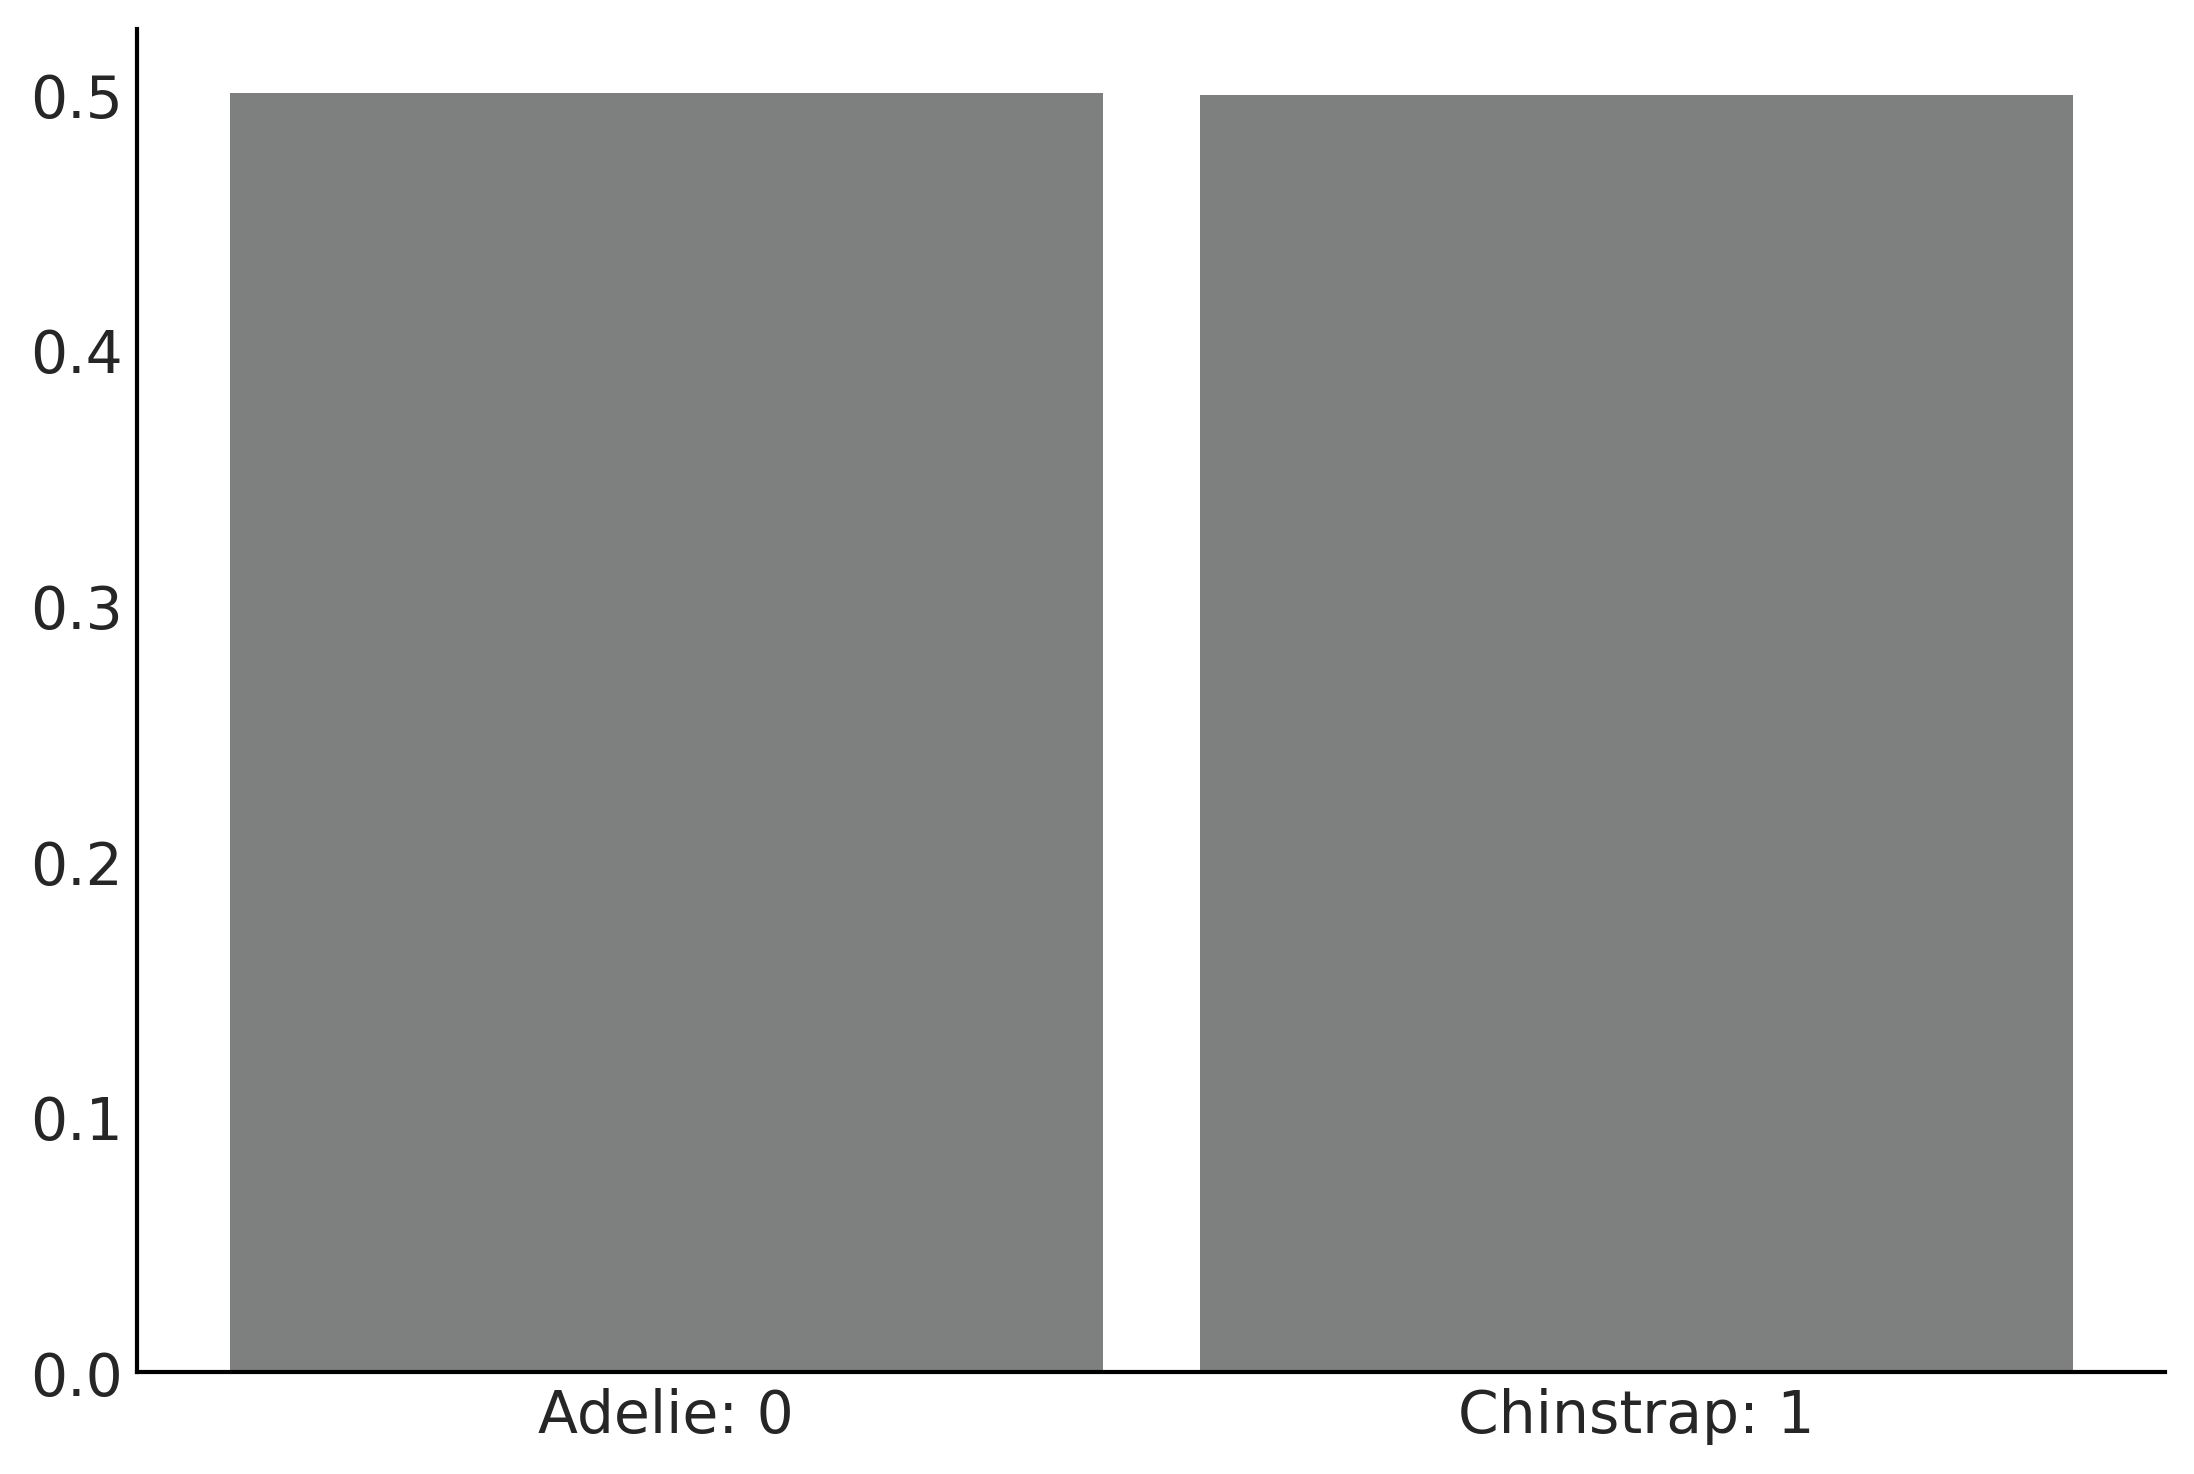

In [51]:
ax = az.plot_dist(prior_predictive_logistic_penguins_bill_length["yl"], color="C2")
ax.set_xticklabels(["Adelie: 0", "Chinstrap: 1"] )
plt.savefig("img/chp03/prior_predictive_logistic.png")

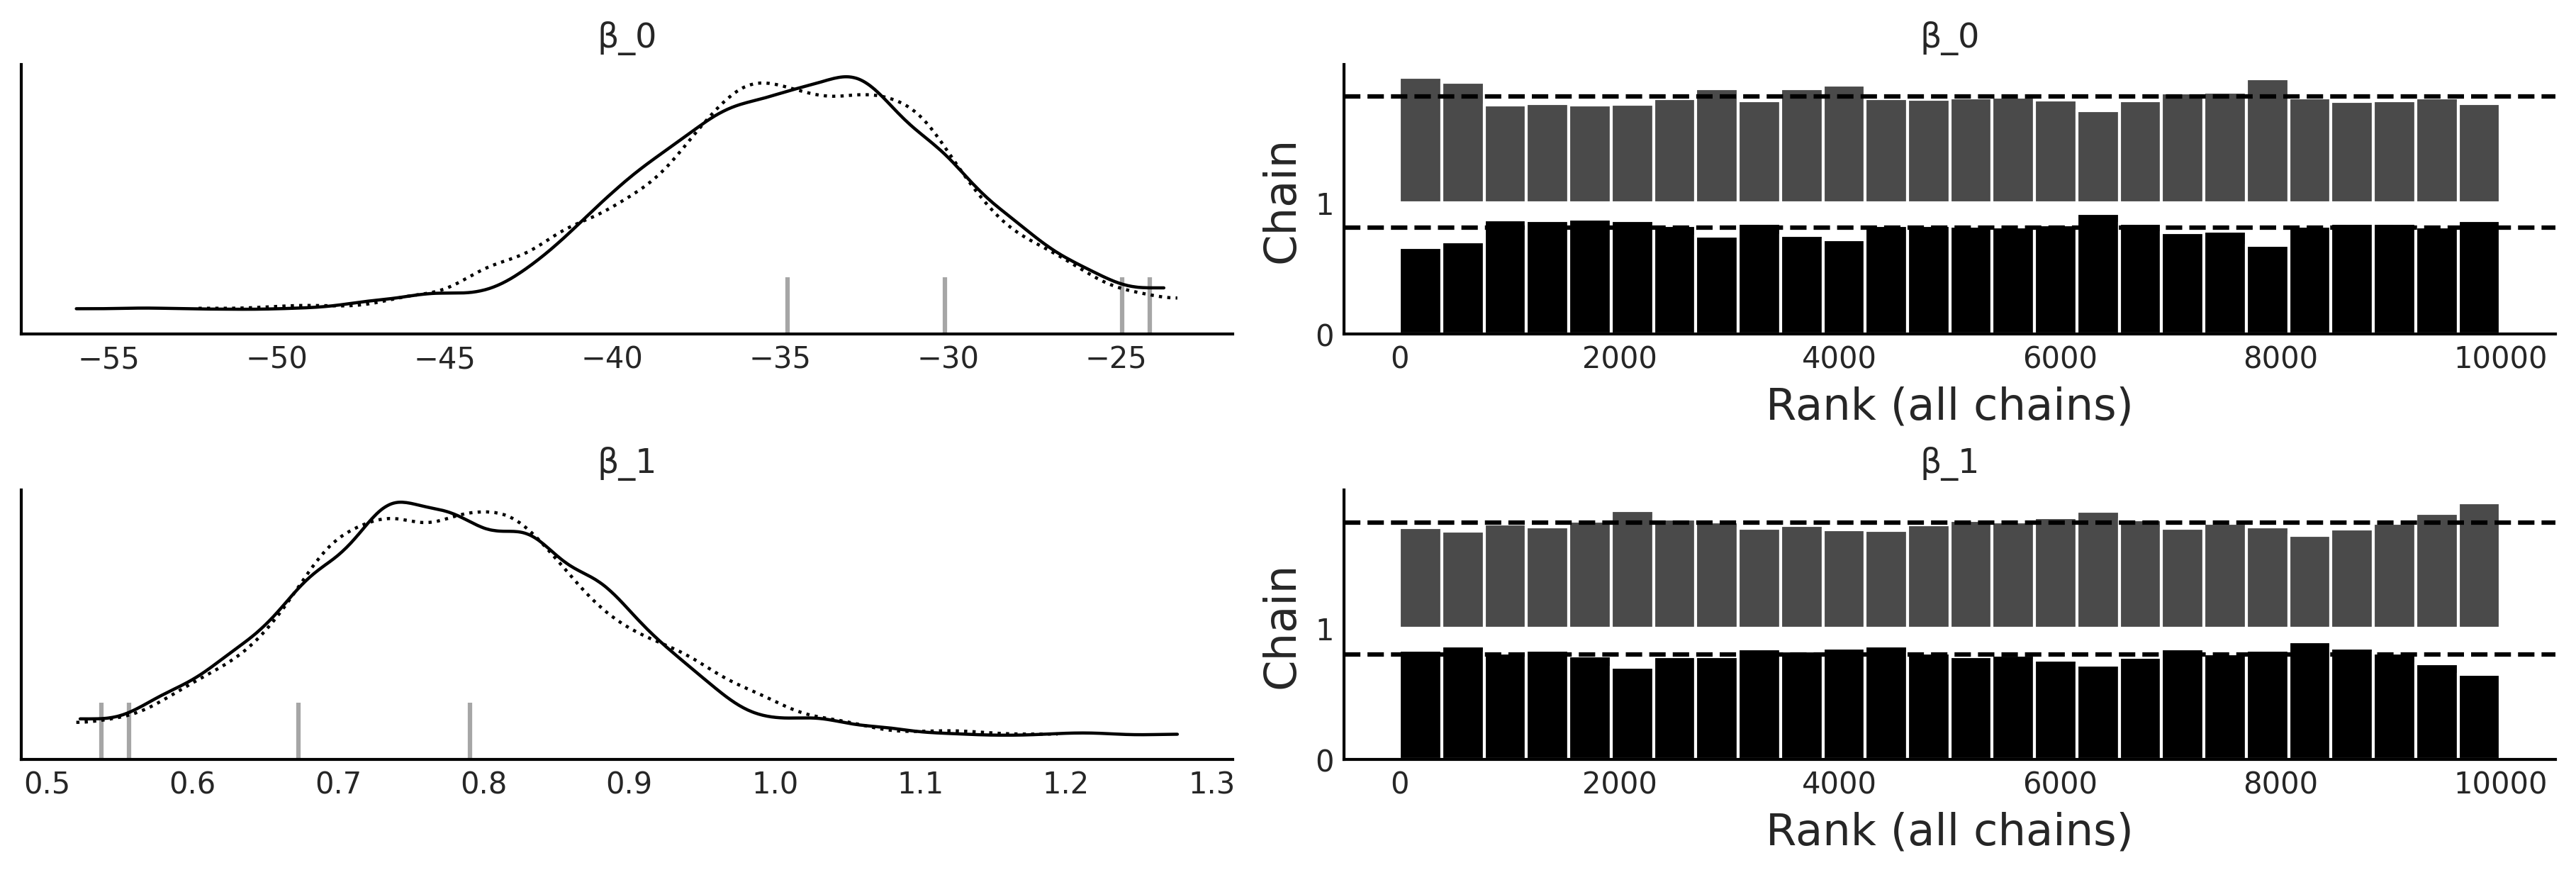

In [52]:
az.plot_trace(inf_data_logistic_penguins_bill_length, var_names=["β_0", "β_1"], kind="rank_bars");

### Table 3.3

In [53]:
az.summary(inf_data_logistic_penguins_bill_length, var_names=["β_0", "β_1"], kind="stats")

mean     sd  hdi_3%  hdi_97%
β_0 -34.596  4.570 -42.884  -25.916
β_1   0.782  0.105   0.585    0.973

### Figure 3.19

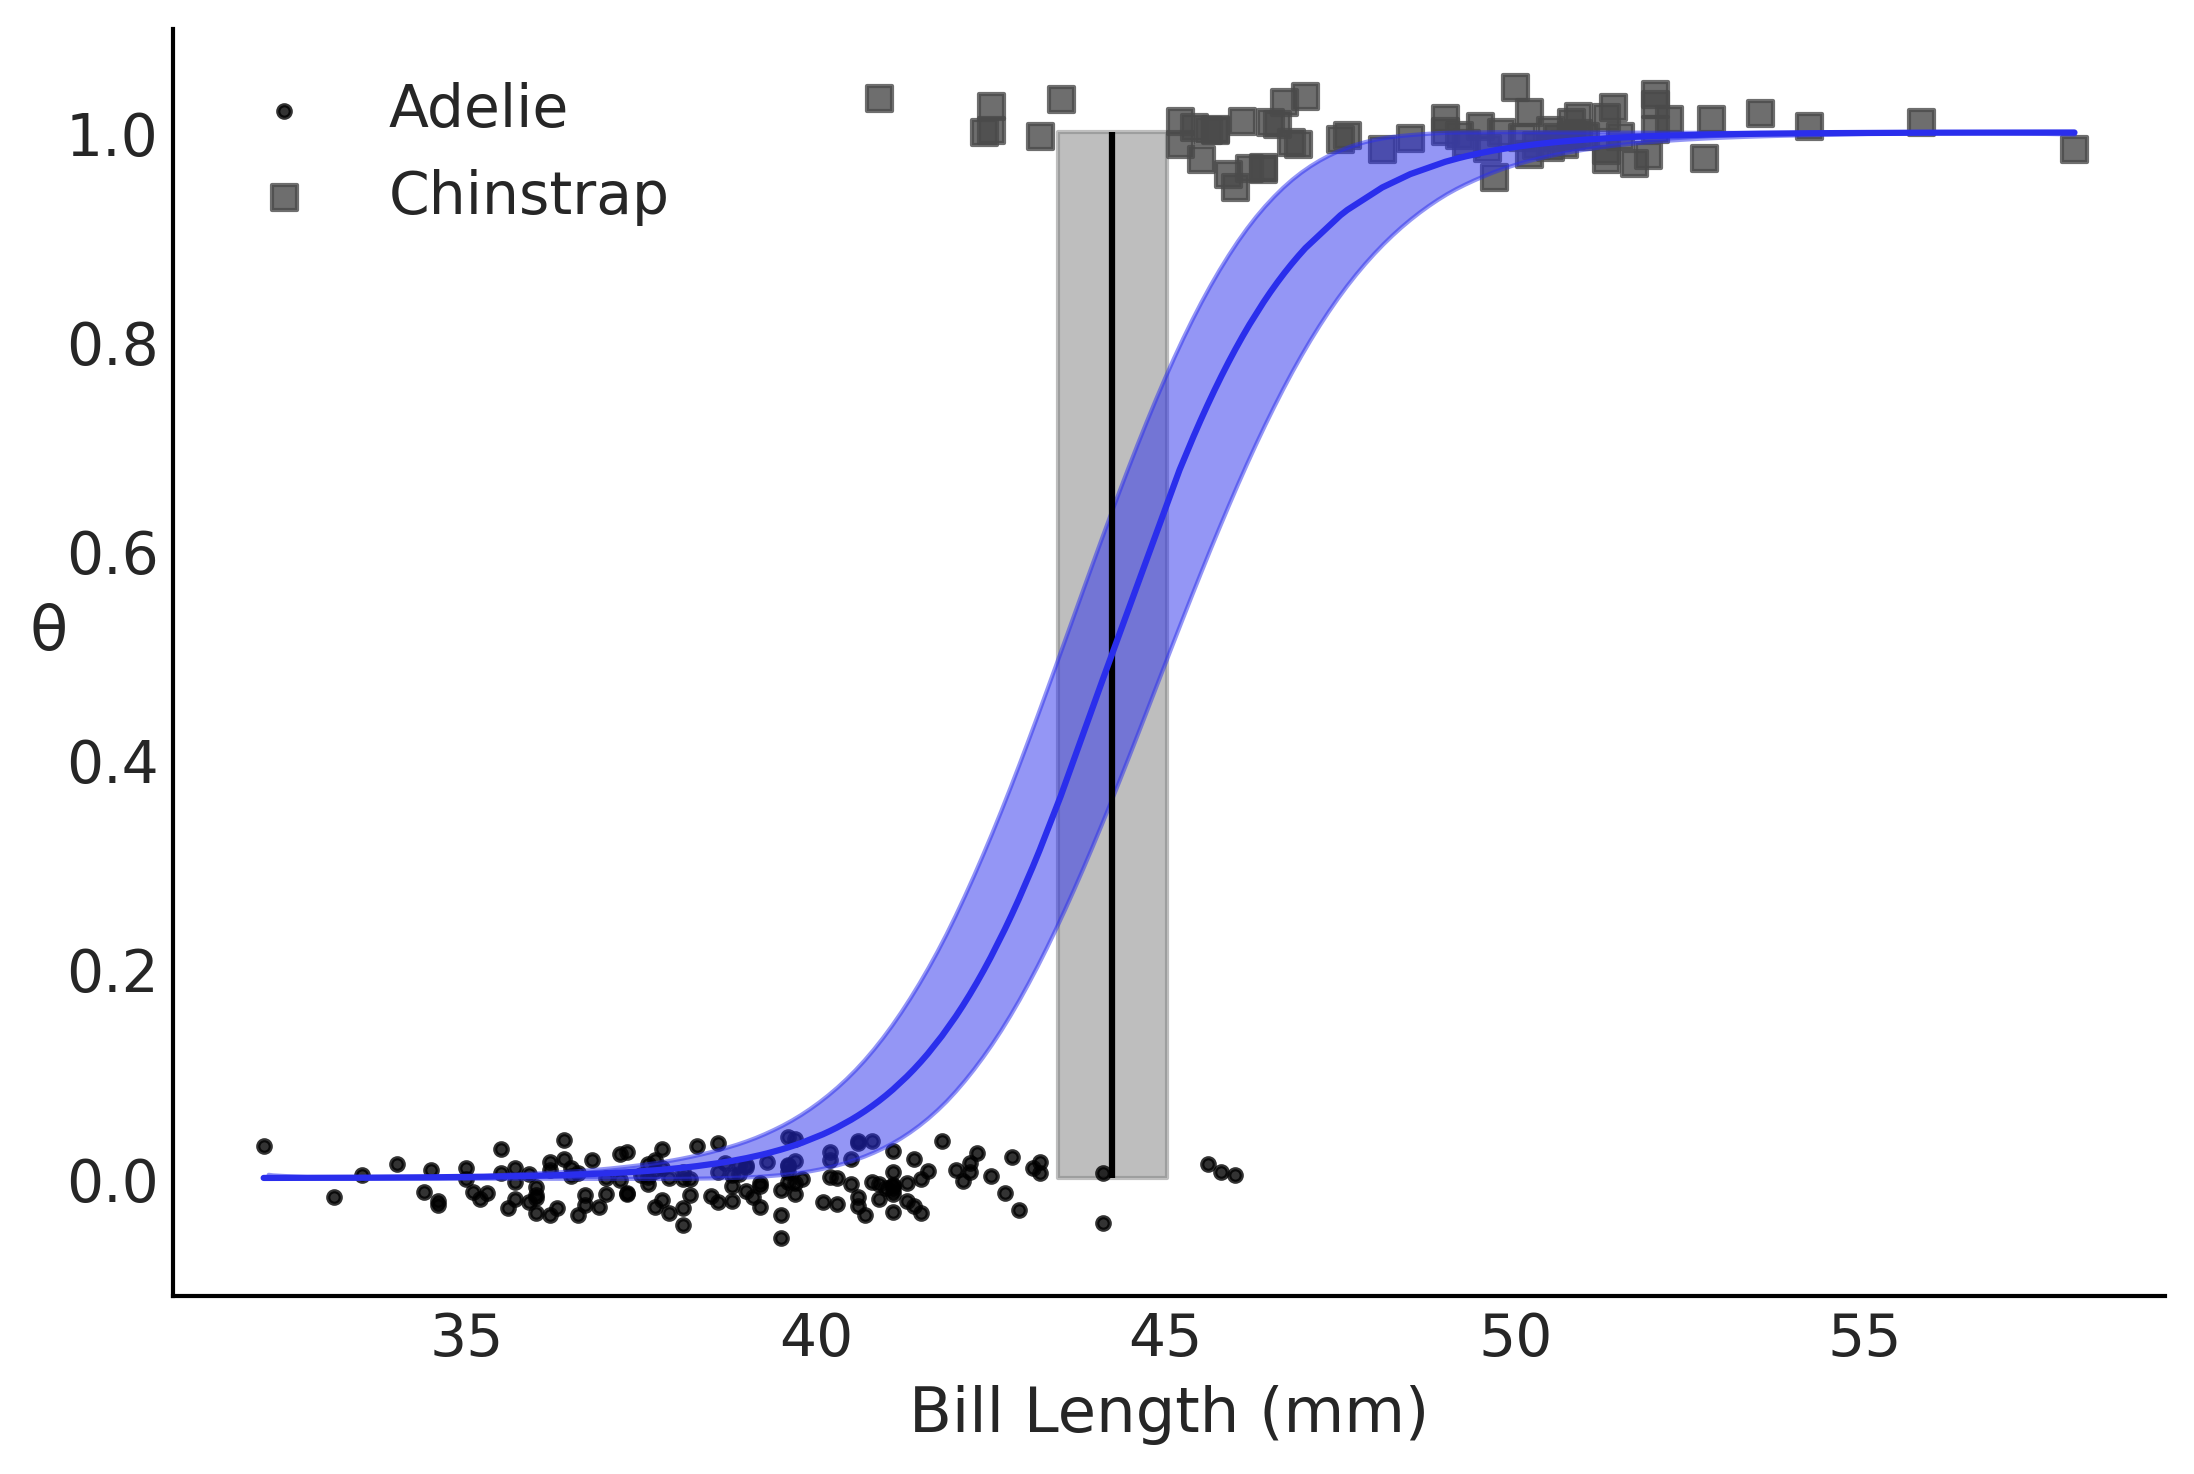

In [54]:
fig, ax = plt.subplots()

theta = inf_data_logistic_penguins_bill_length.posterior["θ"].values.reshape((-1,214)).mean(axis=0)


idx = np.argsort(bill_length_obs)

# Decision Boundary
ax.vlines(inf_data_logistic_penguins_bill_length.posterior["bd"].values.mean(), 0, 1, color='k')
bd_hpd = az.hdi(inf_data_logistic_penguins_bill_length.posterior["bd"].values.flatten(), ax=ax)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C2', alpha=0.5)


for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i)
    x = bill_length_obs[_filter]
    y = np.random.normal(i, 0.02, size=_filter.sum())
    ax.scatter(bill_length_obs[_filter], y, marker=marker, label=label, alpha=.8)

az.plot_hdi(bill_length_obs, inf_data_logistic_penguins_bill_length.posterior["θ"].values, color='C4', ax=ax, plot_kwargs={"zorder":10})
ax.plot(bill_length_obs[idx], theta[idx], color='C4', zorder=10)

ax.set_xlabel("Bill Length (mm)")
ax.set_ylabel('θ', rotation=0)
plt.legend()
plt.savefig("img/chp03/logistic_bill_length.png")

#### Code 3.23

In [55]:
mass_obs = penguins.loc[species_filter, "body_mass_g"].values

with pm.Model() as model_logistic_penguins_mass:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)
    
    μ = β_0 + pm.math.dot(mass_obs, β_1)  
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β_0/β_1)
    
    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

#     inf_data_logistic_penguins_mass = pm.sample(
#         5000, target_accept=.9, return_inferencedata=True)

    trace_logistic_penguins_mass = pm.sample(
        5000, random_seed=0, chains=2, target_accept=.9)
    posterior_predictive_logistic_penguins_mass = pm.sample_posterior_predictive(
        trace_logistic_penguins_mass)

    inf_data_logistic_penguins_mass = az.from_pymc3(
        trace=trace_logistic_penguins_mass,
        posterior_predictive=posterior_predictive_logistic_penguins_mass)

/tmp/ipykernel_83821/1556298904.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_logistic_penguins_mass = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β_1, β_0]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.


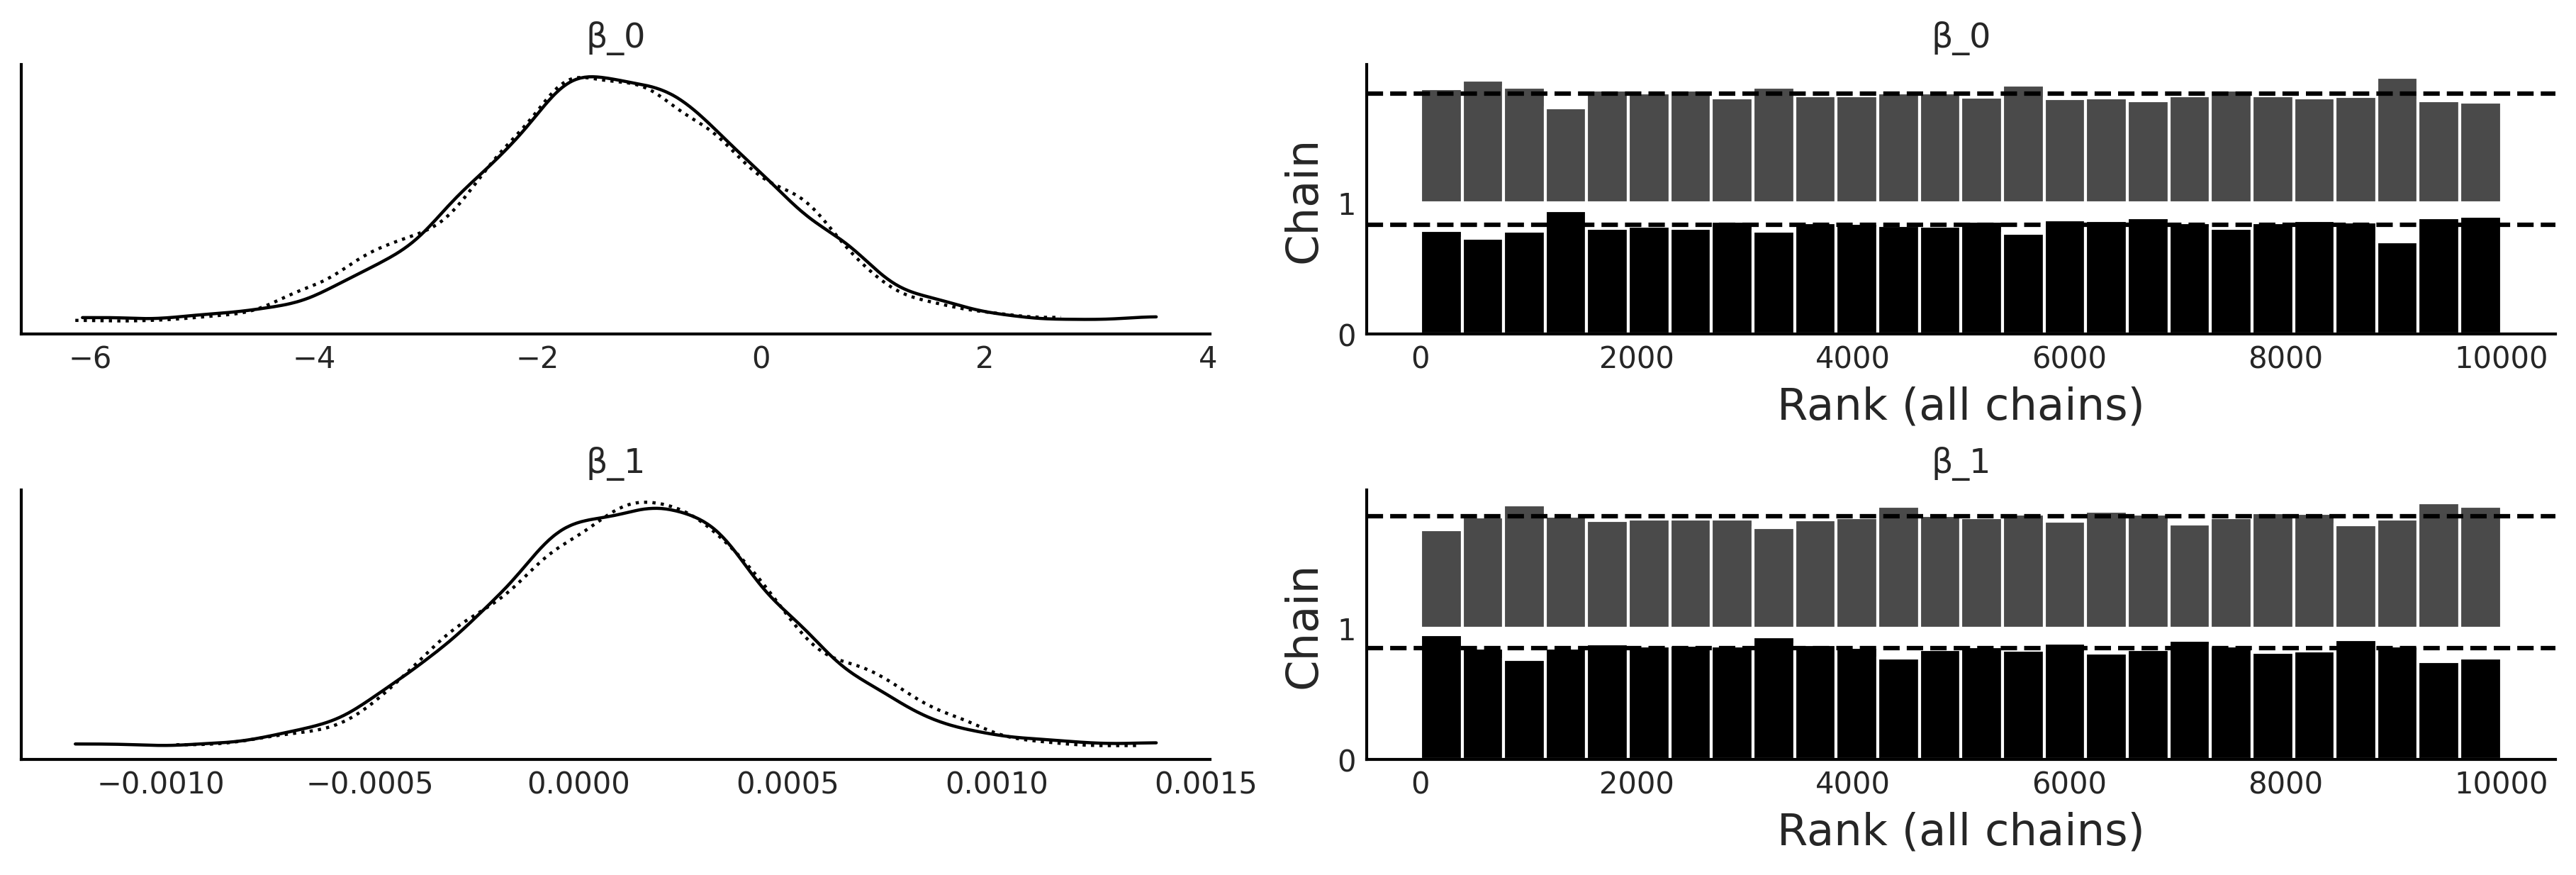

In [56]:
az.plot_trace(inf_data_logistic_penguins_mass, var_names=["β_0", "β_1"], kind="rank_bars");

### Table 3.4

In [57]:
az.summary(inf_data_logistic_penguins_mass, var_names=["β_0", "β_1", "bd"], kind="stats")

mean           sd     hdi_3%    hdi_97%
β_0     -1.296        1.310     -3.801      1.043
β_1      0.000        0.000     -0.001      0.001
bd   22363.063  1620369.002 -17860.620  34643.374

### Figure 3.20

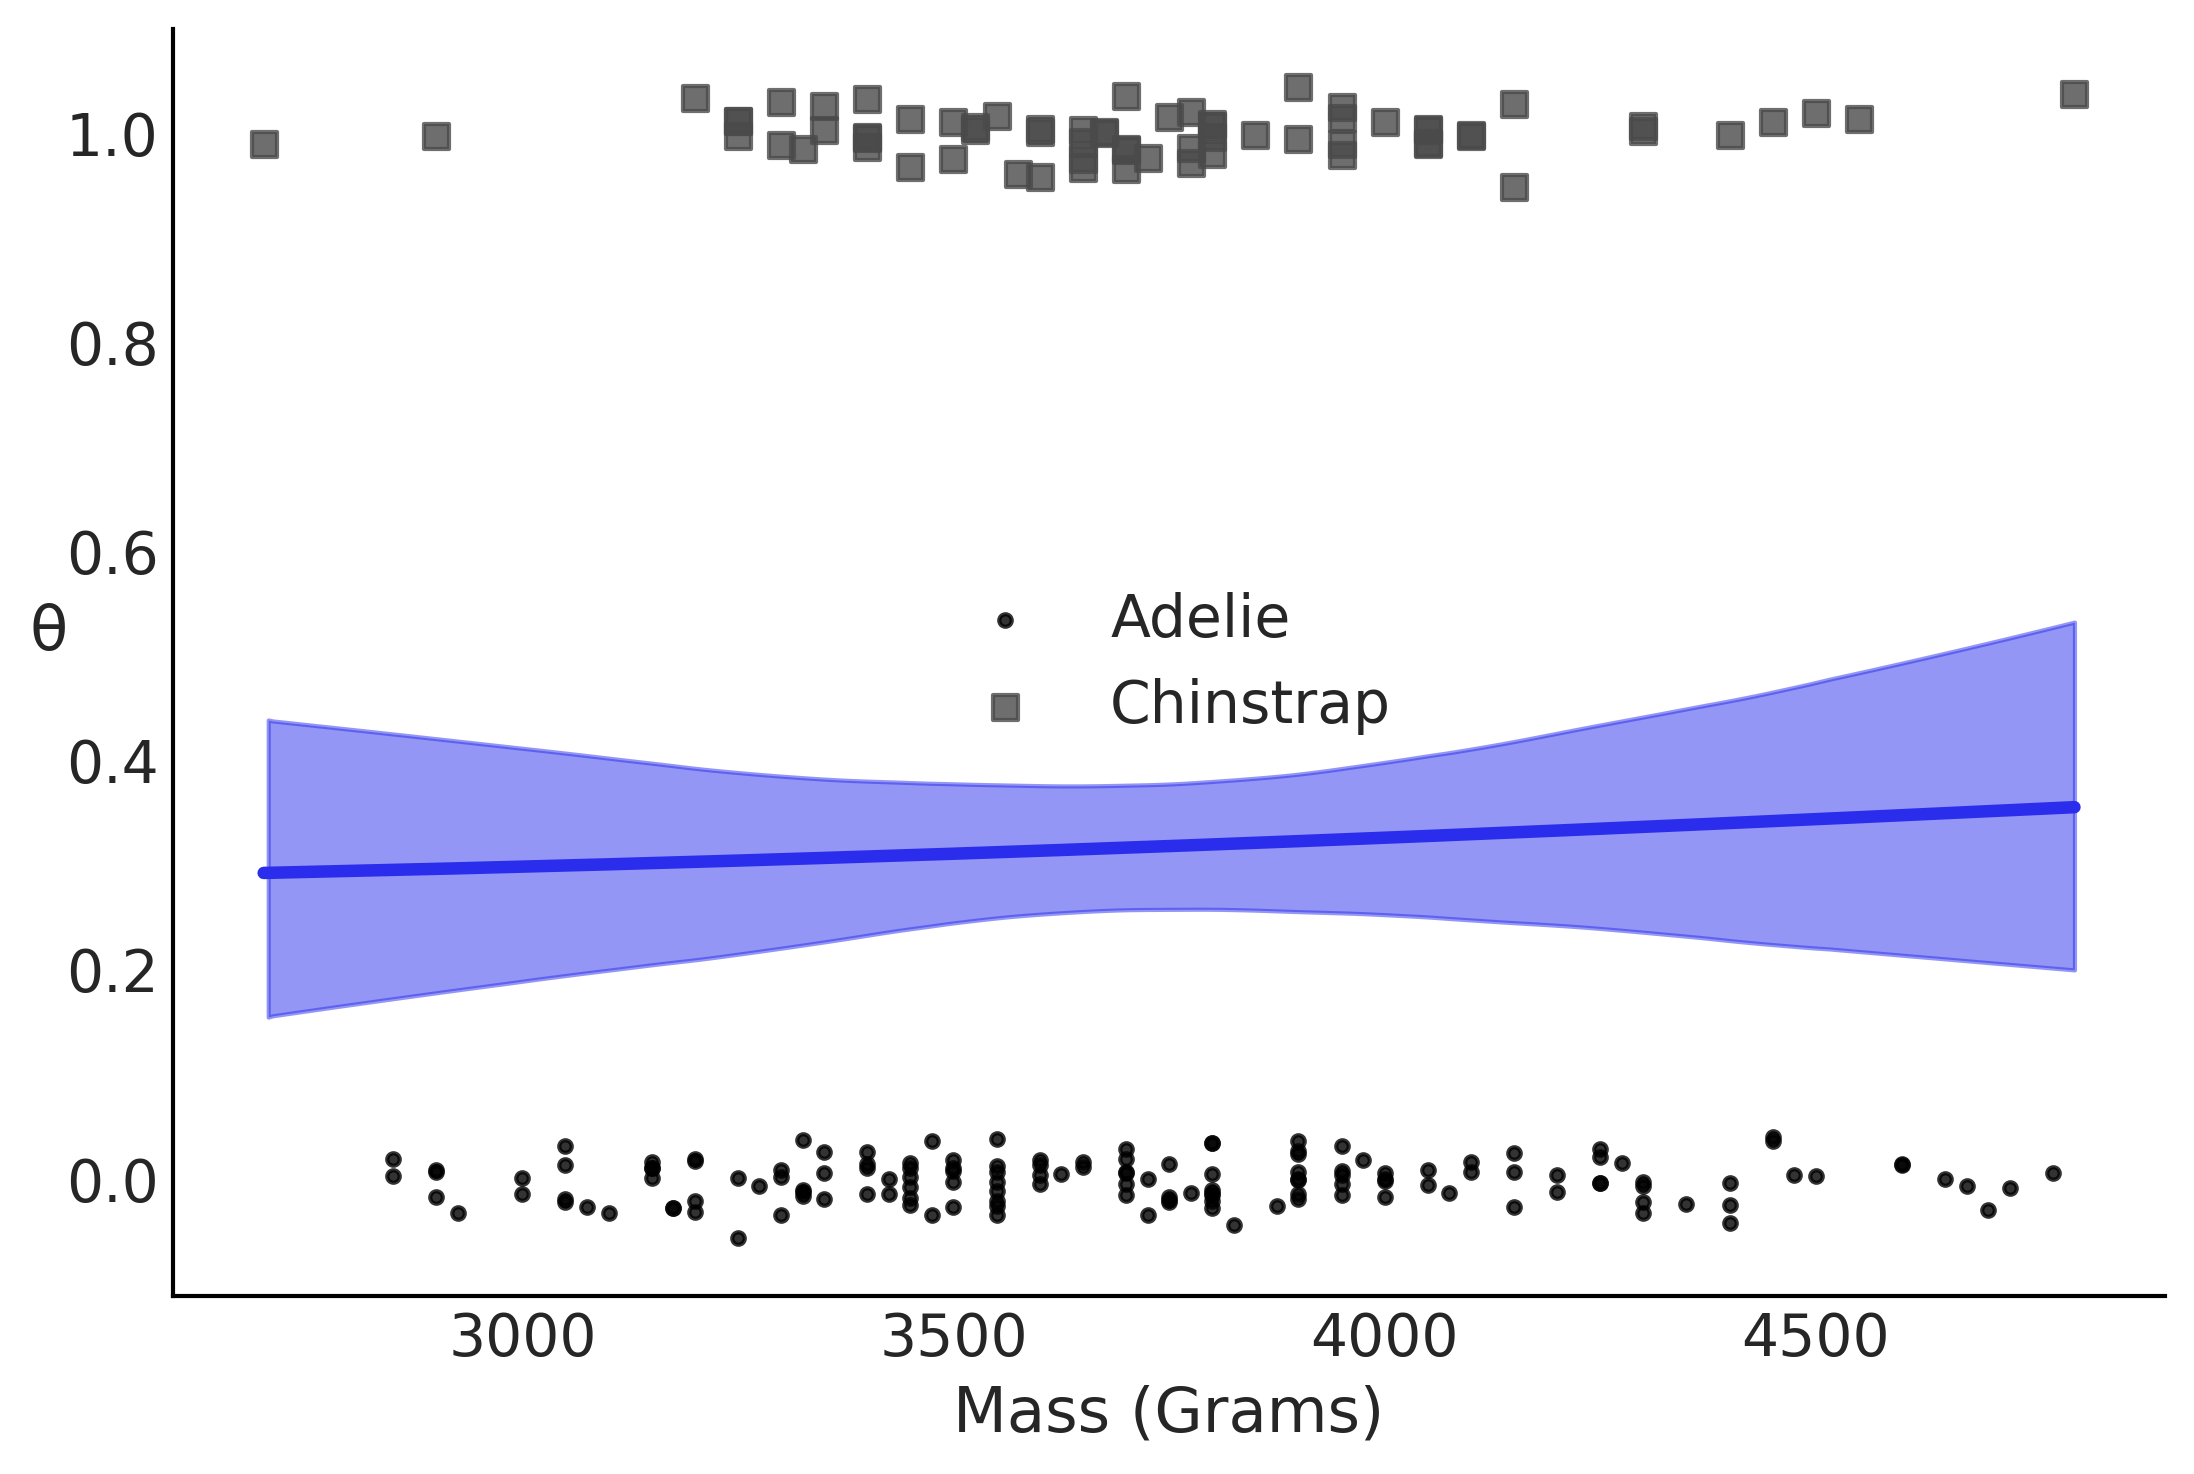

In [58]:
theta = inf_data_logistic_penguins_mass.posterior['θ'].values
bd = inf_data_logistic_penguins_mass.posterior['bd'].values


fig, ax = plt.subplots()
theta = theta.reshape(-1,214).mean(axis=0)
idx = np.argsort(mass_obs)

ax.plot(mass_obs[idx], theta[idx], color='C4', lw=3)
for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i)
    x = mass_obs[_filter]
    y = np.random.normal(i, 0.02, size=_filter.sum())
    ax.scatter(mass_obs[_filter], y, marker=marker, label=label, alpha=.8)

az.plot_hdi(mass_obs, inf_data_logistic_penguins_mass.posterior['θ'], color='C4', ax=ax)

ax.set_xlabel("Mass (Grams)")
ax.set_ylabel('θ', rotation=0)
plt.legend()

plt.savefig("img/chp03/logistic_mass.png")

### Code 3.24

In [59]:
X = penguins.loc[species_filter, ["bill_length_mm", "body_mass_g"]]

# Add a column of 1s for the intercept
X.insert(0,"Intercept", value=1)
X = X.values

with pm.Model() as model_logistic_penguins_bill_length_mass:
    β = pm.Normal("β", mu=0, sigma=20, shape=3)

    μ = pm.math.dot(X, β)  

    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β[0]/β[2] - β[1]/β[2] * X[:,1])
    
    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

#     inf_data_logistic_penguins_bill_length_mass = pm.sample(
#         1000,
#         return_inferencedata=True)

    trace_logistic_penguins_bill_length_mass = pm.sample(
        5000, random_seed=0, chains=2, target_accept=.9)
    posterior_predictive_logistic_penguins_bill_length_mass = pm.sample_posterior_predictive(
        trace_logistic_penguins_bill_length_mass)

    inf_data_logistic_penguins_bill_length_mass = az.from_pymc3(
        trace=trace_logistic_penguins_bill_length_mass,
        posterior_predictive=posterior_predictive_logistic_penguins_bill_length_mass)

/tmp/ipykernel_83821/3234872761.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_logistic_penguins_bill_length_mass = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 40 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


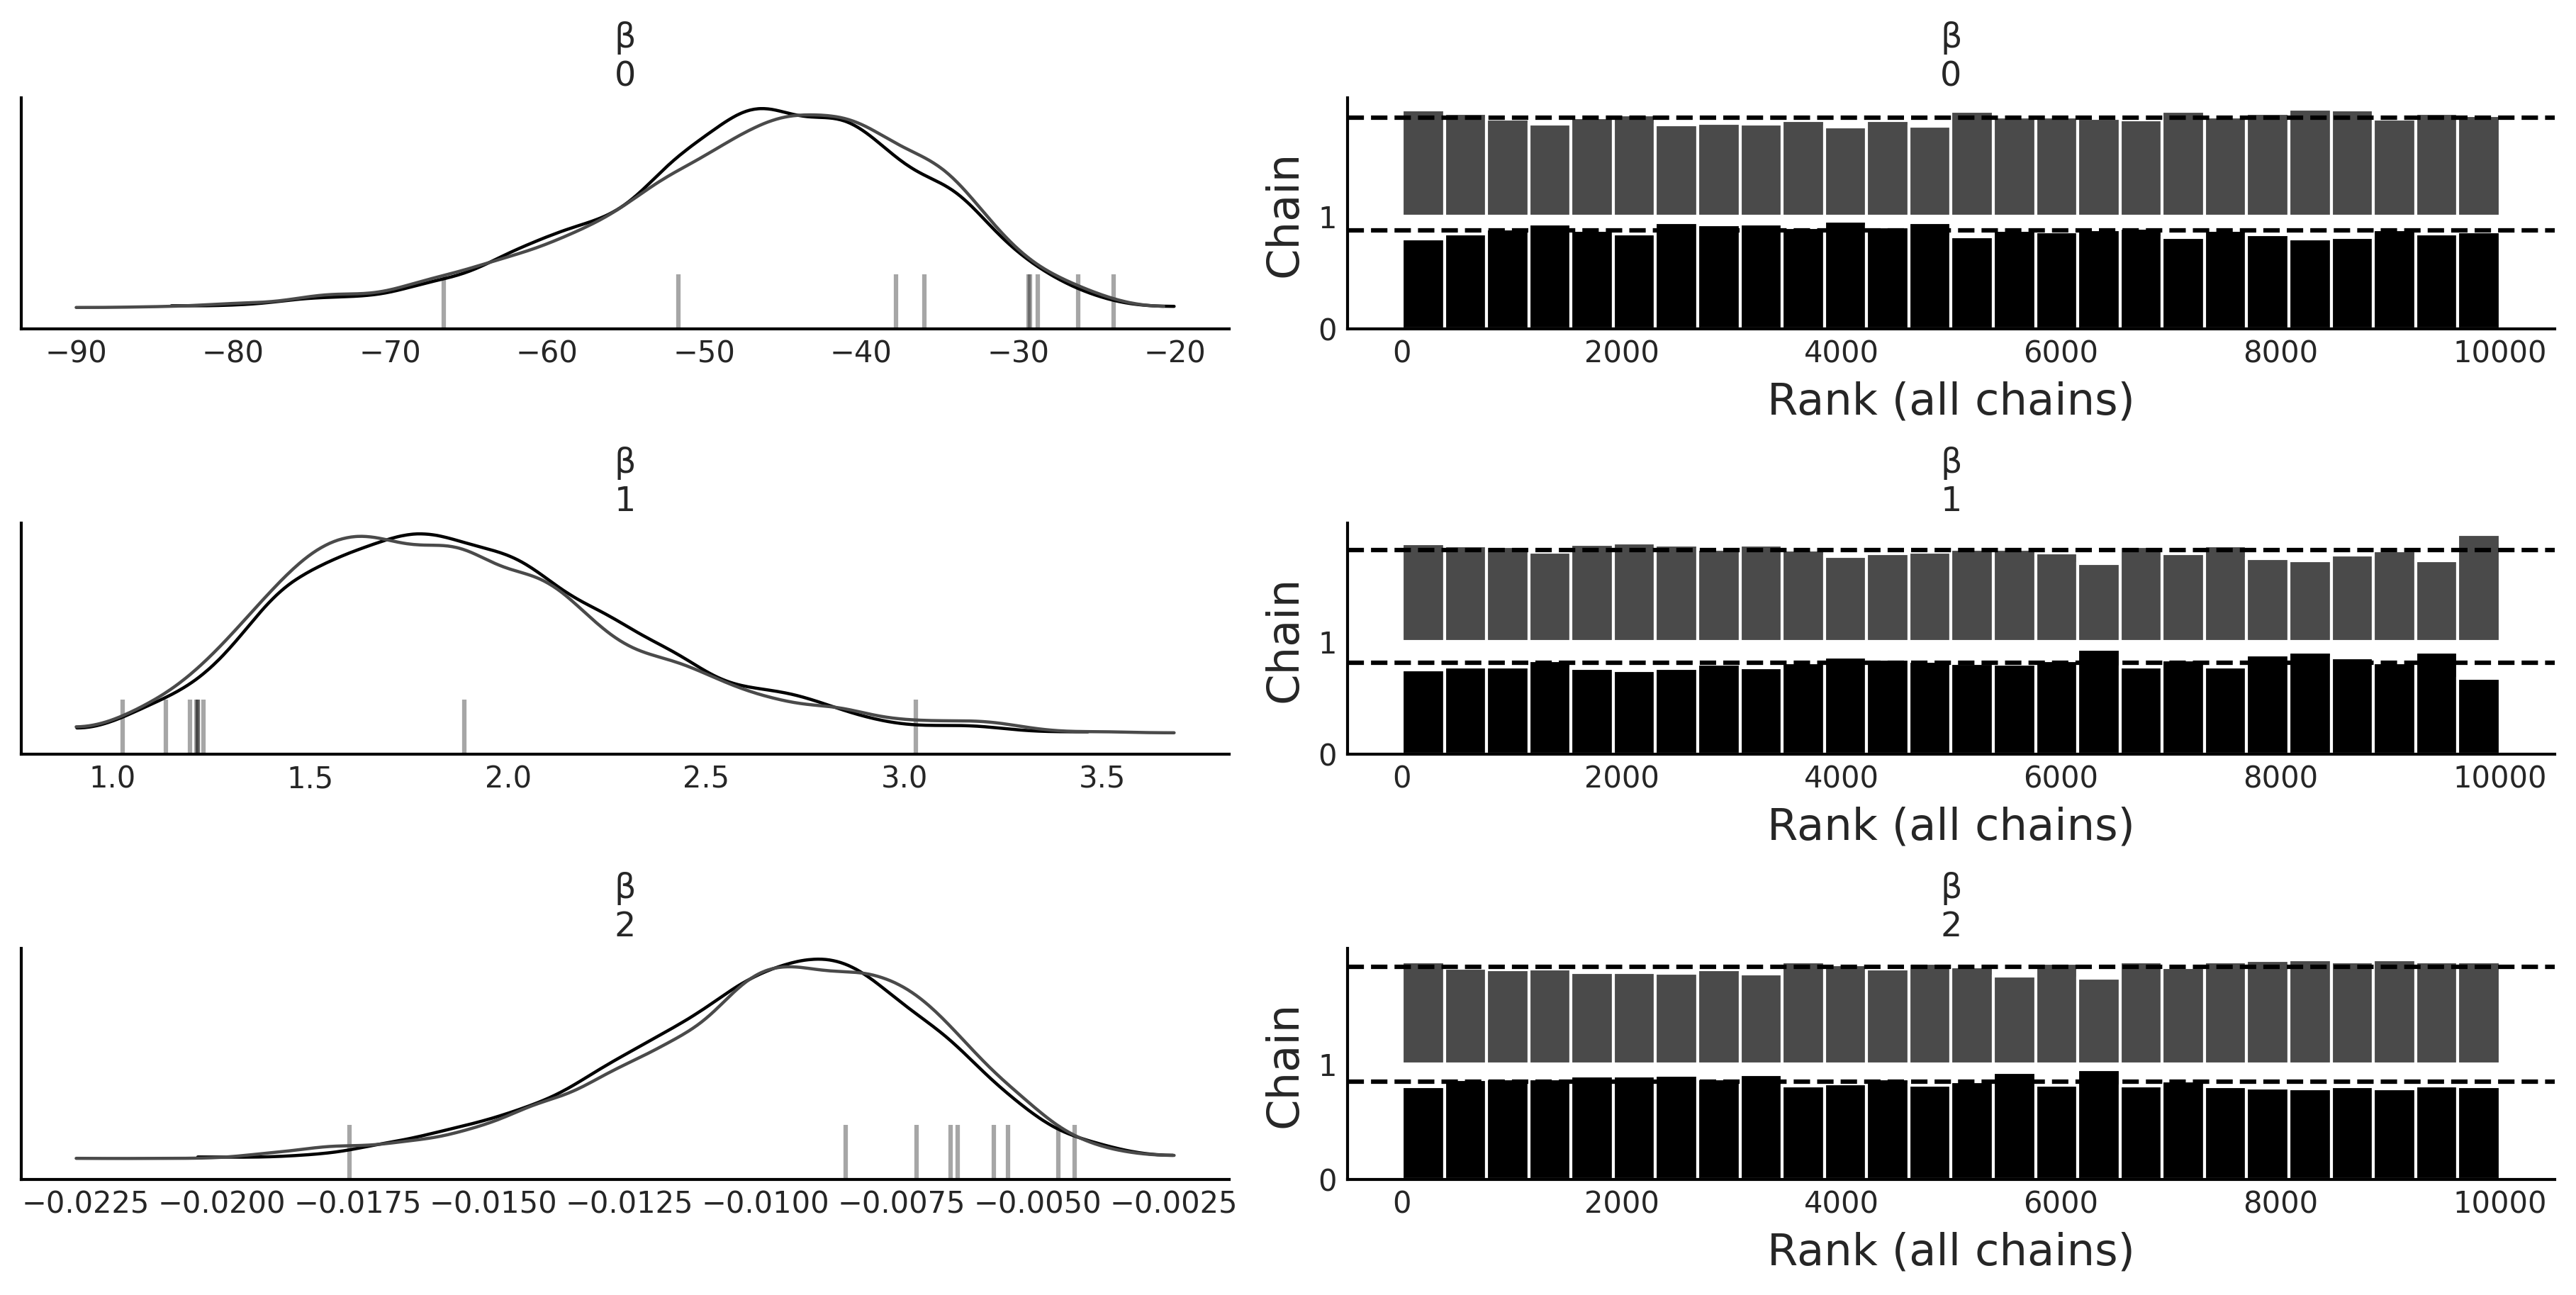

In [60]:
az.plot_trace(inf_data_logistic_penguins_bill_length_mass, compact=False, var_names=["β"], kind="rank_bars");

In [61]:
az.summary(inf_data_logistic_penguins_bill_length_mass, var_names=["β"])

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
β[0] -46.258  10.337 -66.077  -28.061      0.248    0.179    1797.0    1898.0   
β[1]   1.886   0.434   1.101    2.699      0.011    0.008    1614.0    1827.0   
β[2]  -0.010   0.003  -0.016   -0.005      0.000    0.000    1851.0    2348.0   

      r_hat  
β[0]    1.0  
β[1]    1.0  
β[2]    1.0

### Figure 3.21

/home/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


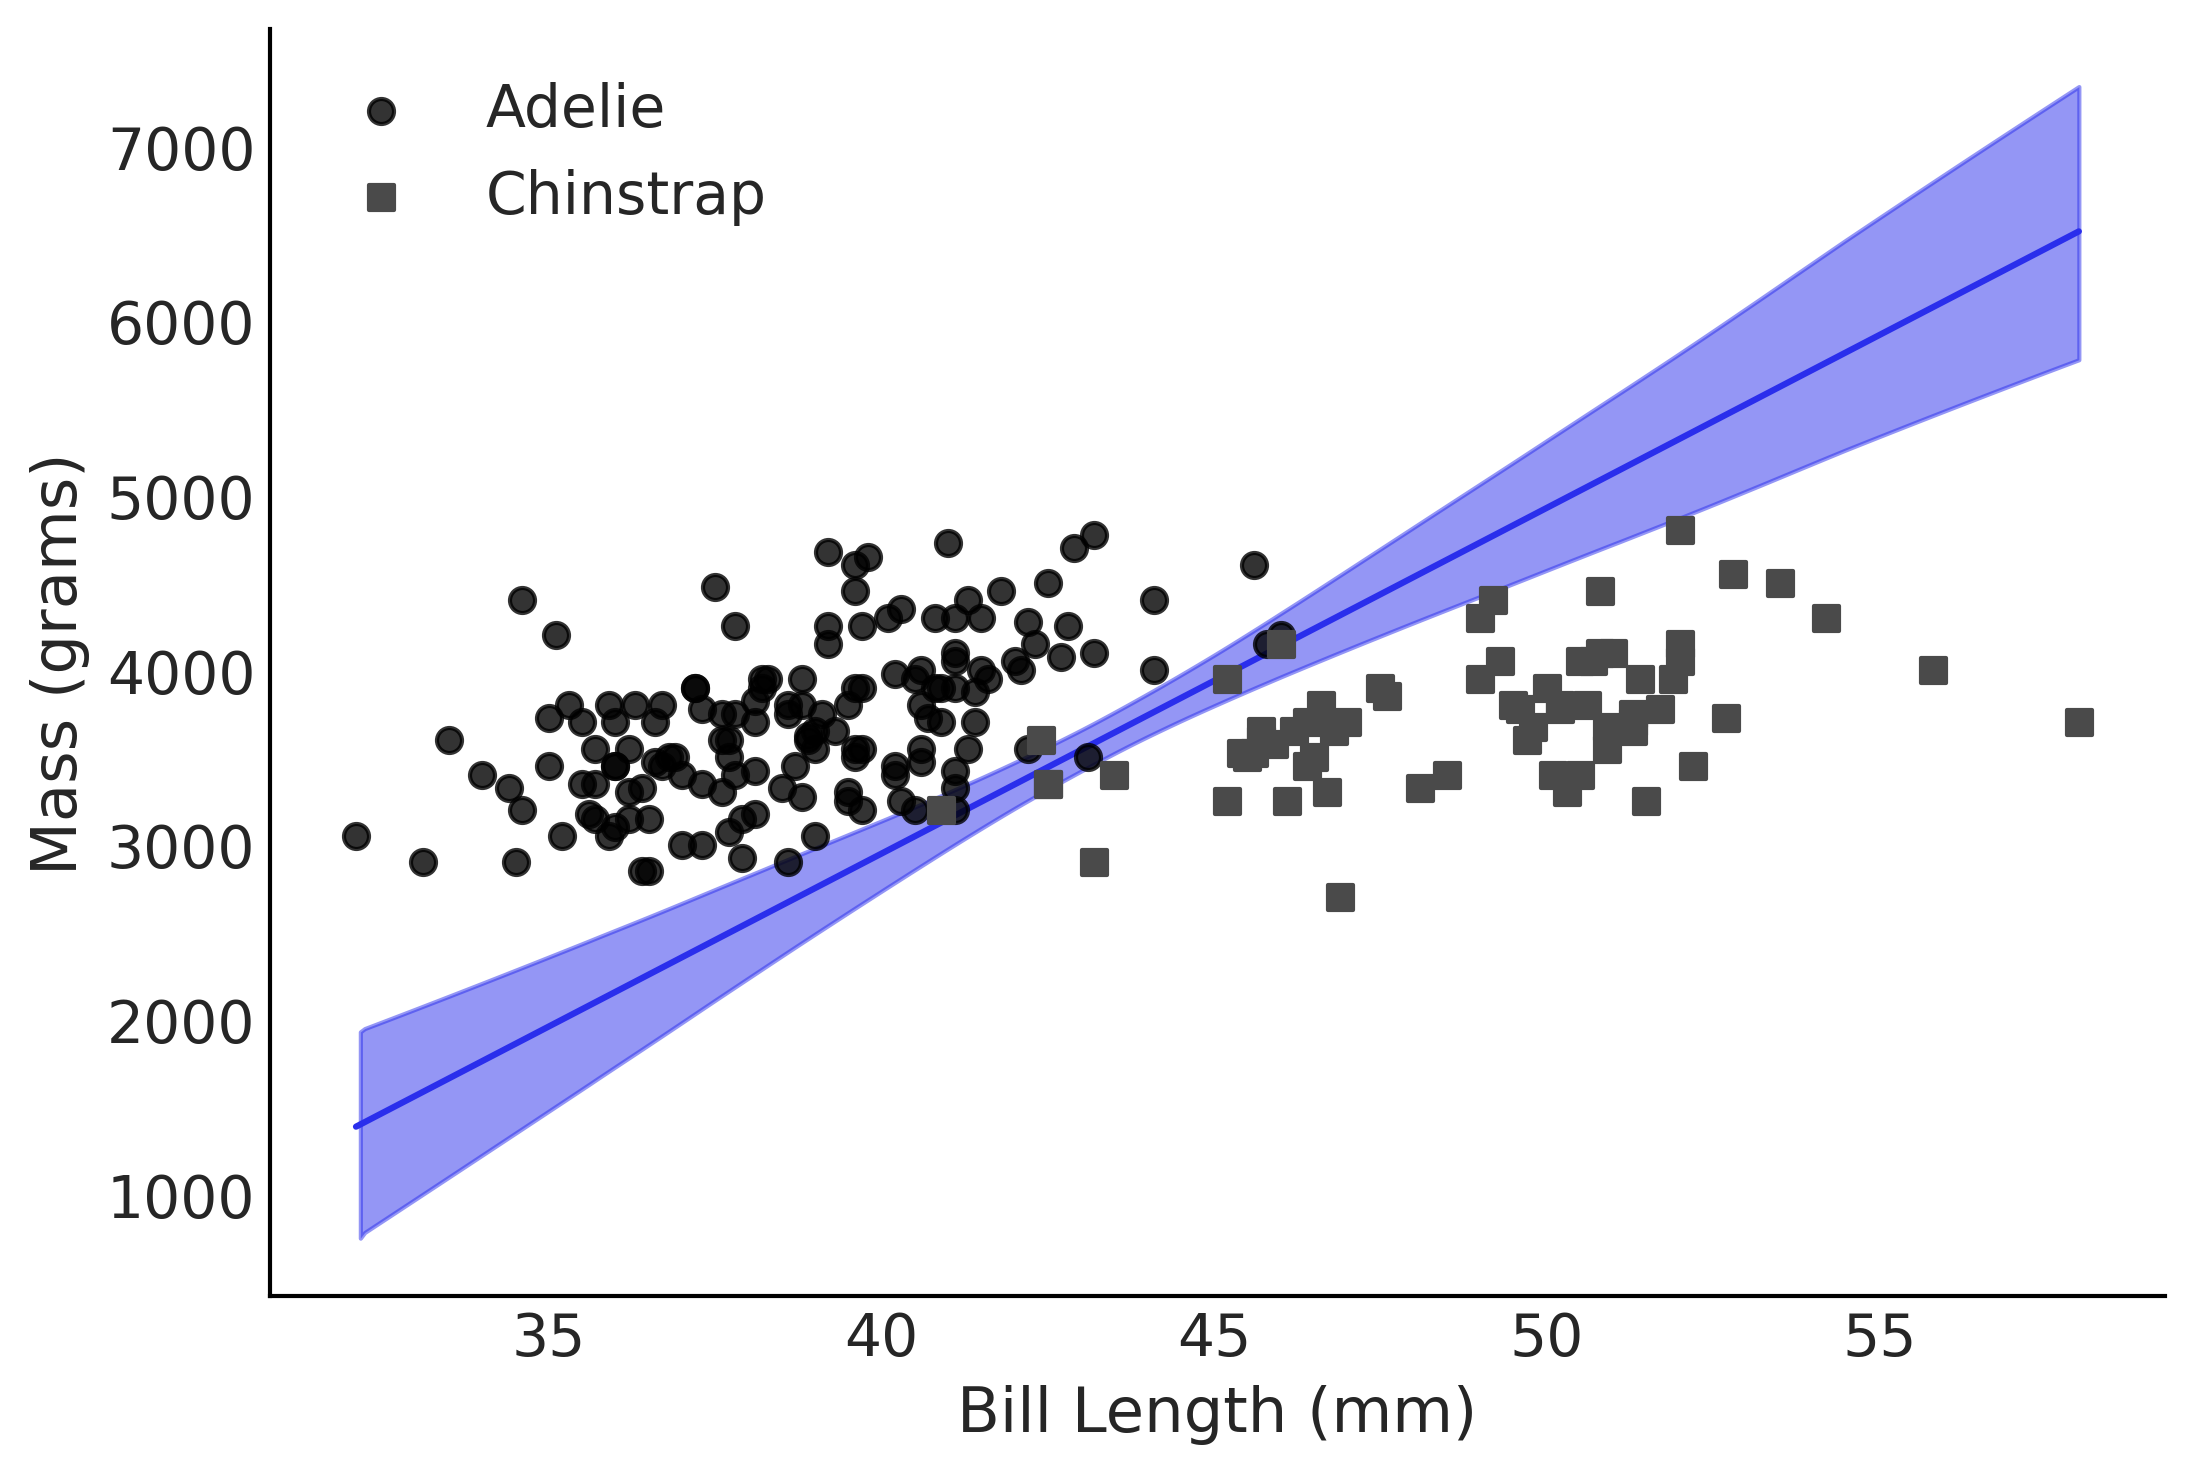

In [62]:
fig,ax  = plt.subplots()
idx = np.argsort(X[:,1]) 
bd = inf_data_logistic_penguins_bill_length_mass.posterior["bd"].values.reshape((-1,214)).mean(axis=0)[idx] 


species_filter = species.codes.astype(bool)

# Linear fit
ax.plot(X[:,1][idx], bd, color='C4'); 
az.plot_hdi(X[:,1], inf_data_logistic_penguins_bill_length_mass.posterior["bd"].values.reshape((-1,214)), color='C4', ax=ax)

# Scatter 
ax.scatter(X[~species_filter,1], X[~species_filter,2], alpha=.8,  label="Adelie", zorder=10)
ax.scatter(X[species_filter,1], X[species_filter,2], marker="s", label="Chinstrap", zorder=10)


ax.set_ylabel("Mass (grams)")
ax.set_xlabel("Bill Length (mm)")


ax.legend()
plt.savefig("img/chp03/decision_boundary_logistic_mass_bill_length.png");

### Code 3.26

In [63]:
az.compare({"mass": inf_data_logistic_penguins_mass,
            "bill": inf_data_logistic_penguins_bill_length, 
            "mass_bill": inf_data_logistic_penguins_bill_length_mass}).round(1)

/home/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank    loo  p_loo  d_loo  weight   se  dse  warning loo_scale
mass_bill     0  -11.3    1.6    0.0     1.0  3.1  0.0     True       log
bill          1  -28.0    1.0   16.7     0.0  5.0  3.9    False       log
mass          2 -135.7    2.0  124.4     0.0  5.3  5.8    False       log

### Code 3.25

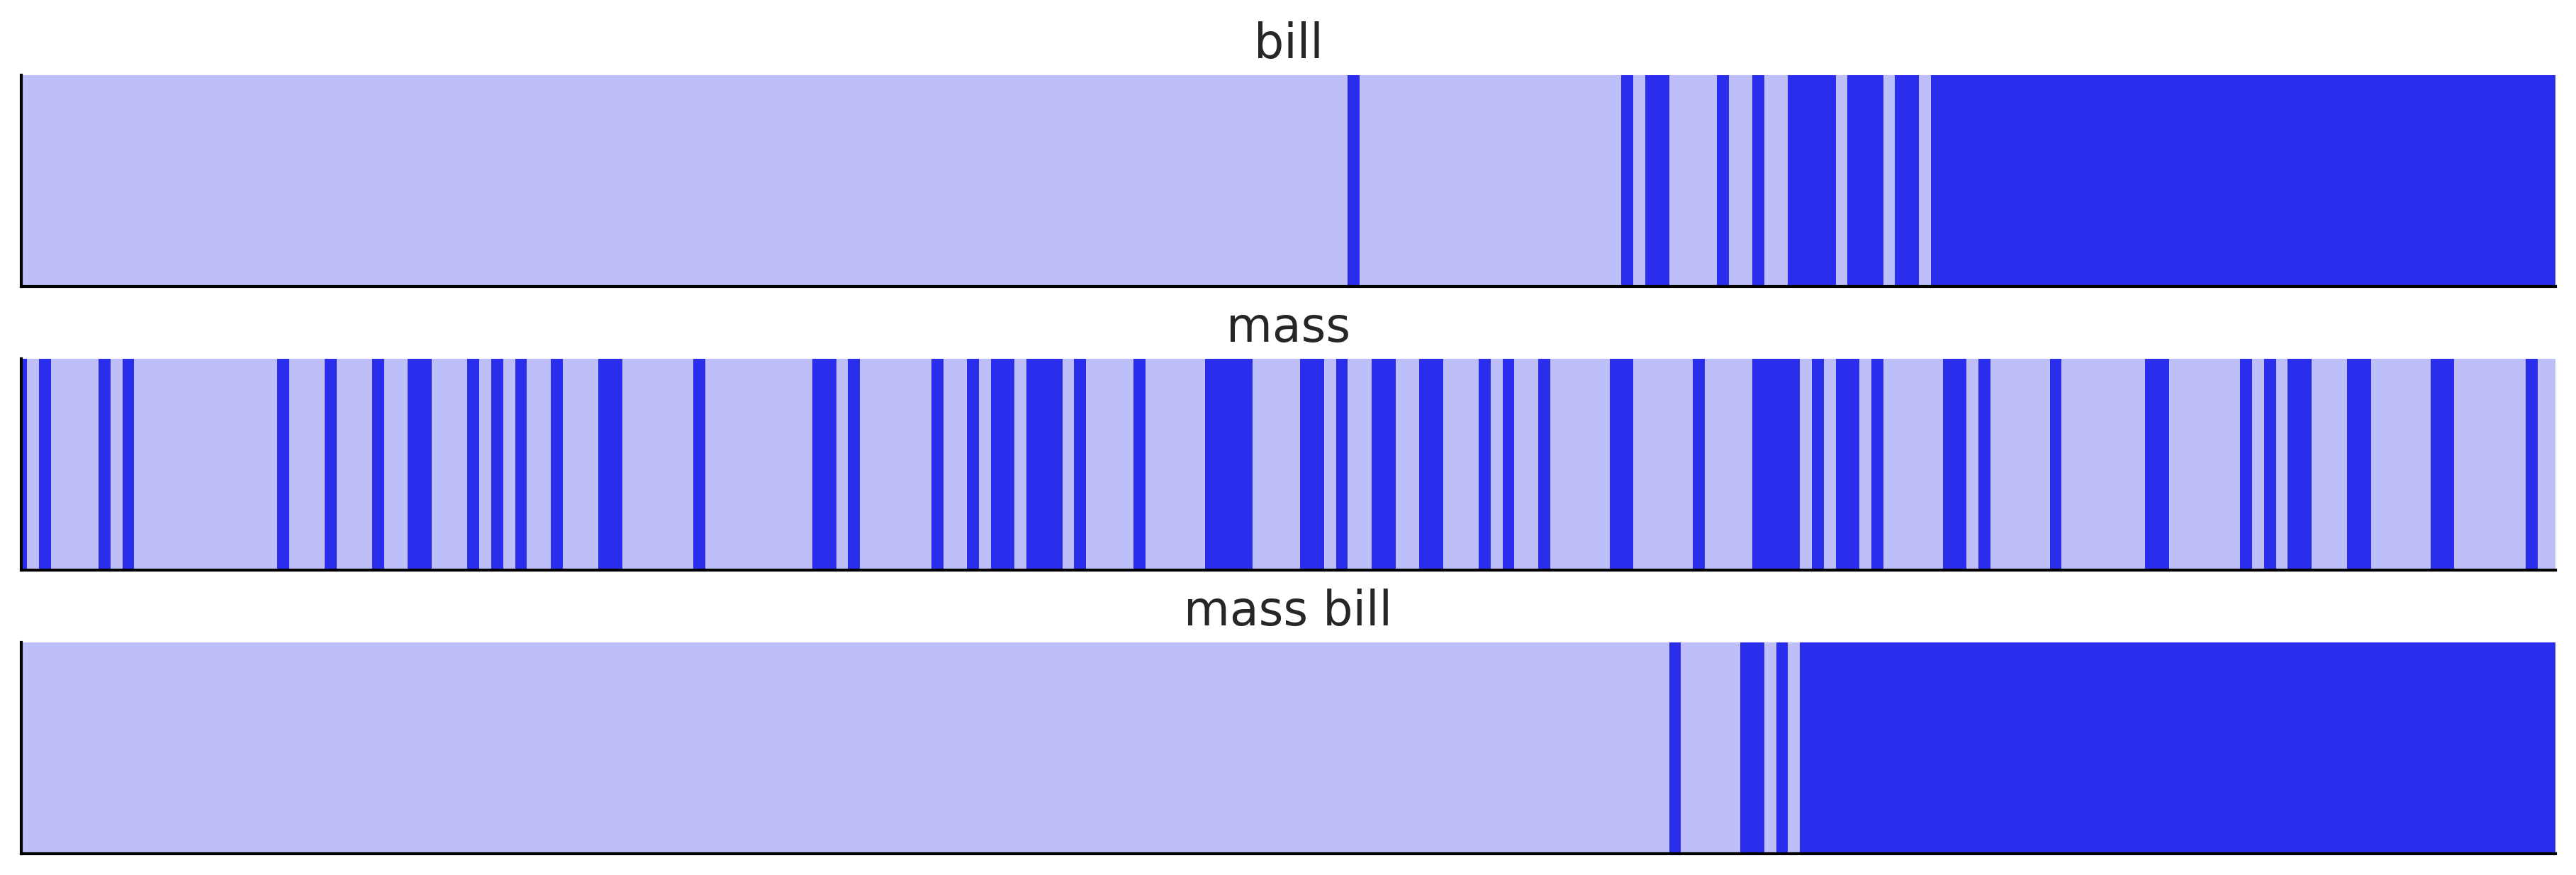

In [64]:
models = {"bill": inf_data_logistic_penguins_bill_length,
          "mass": inf_data_logistic_penguins_mass,
          "mass bill": inf_data_logistic_penguins_bill_length_mass}

_, axes = plt.subplots(3, 1, figsize=(12, 4), sharey=True)
for (label, model), ax in zip(models.items(), axes):
    az.plot_separation(model, "yl", ax=ax, color="C4")
    ax.set_title(label)
    
plt.savefig("img/chp03/penguins_separation_plot.png")

### Code 3.27

In [65]:
penguins.loc[:,"species"].value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64

In [66]:
counts = penguins["species"].value_counts()
adelie_count = counts["Adelie"],
chinstrap_count = counts["Chinstrap"]
adelie_count/(adelie_count+chinstrap_count)

array([0.68224299])

### Code 3.28

In [67]:
adelie_count/chinstrap_count

array([2.14705882])

In [68]:
inf_data_logistic_penguins_bill_length.posterior["β_0"].mean().values

array(-34.59583868)

In [69]:
β_0 = inf_data_logistic_penguins_bill_length.posterior["β_0"].mean().values
β_1 = inf_data_logistic_penguins_bill_length.posterior["β_1"].mean().values

In [70]:
β_0

array(-34.59583868)

In [71]:
β_1

array(0.7823039)

### Code 3.29

In [72]:
bill_length = 45
val_1 = β_0 + β_1*bill_length
val_2 = β_0 + β_1*(bill_length+1)

f"Class Probability change from 45mm Bill Length to 46mm: {(special.expit(val_2) - special.expit(val_1))*100:.0f}%"

'Class Probability change from 45mm Bill Length to 46mm: 15%'

In [73]:
bill_length = np.array([30, 45])
val_1 = β_0 + β_1*bill_length
val_2 = β_0 + β_1*(bill_length+1)

#f"Slope Change {(val_2 - val_1):.2f} Probability Change {(special.expit(val_2) - special.expit(val_1)):.2f}"

In [74]:
special.expit(val_2) - special.expit(val_1)

array([1.74572147e-05, 1.53167524e-01])

## Picking Priors in Regression Models

### Figure 3.23

In [75]:
x = np.arange(-2,3,1)
y = [50, 44, 50, 47, 56]

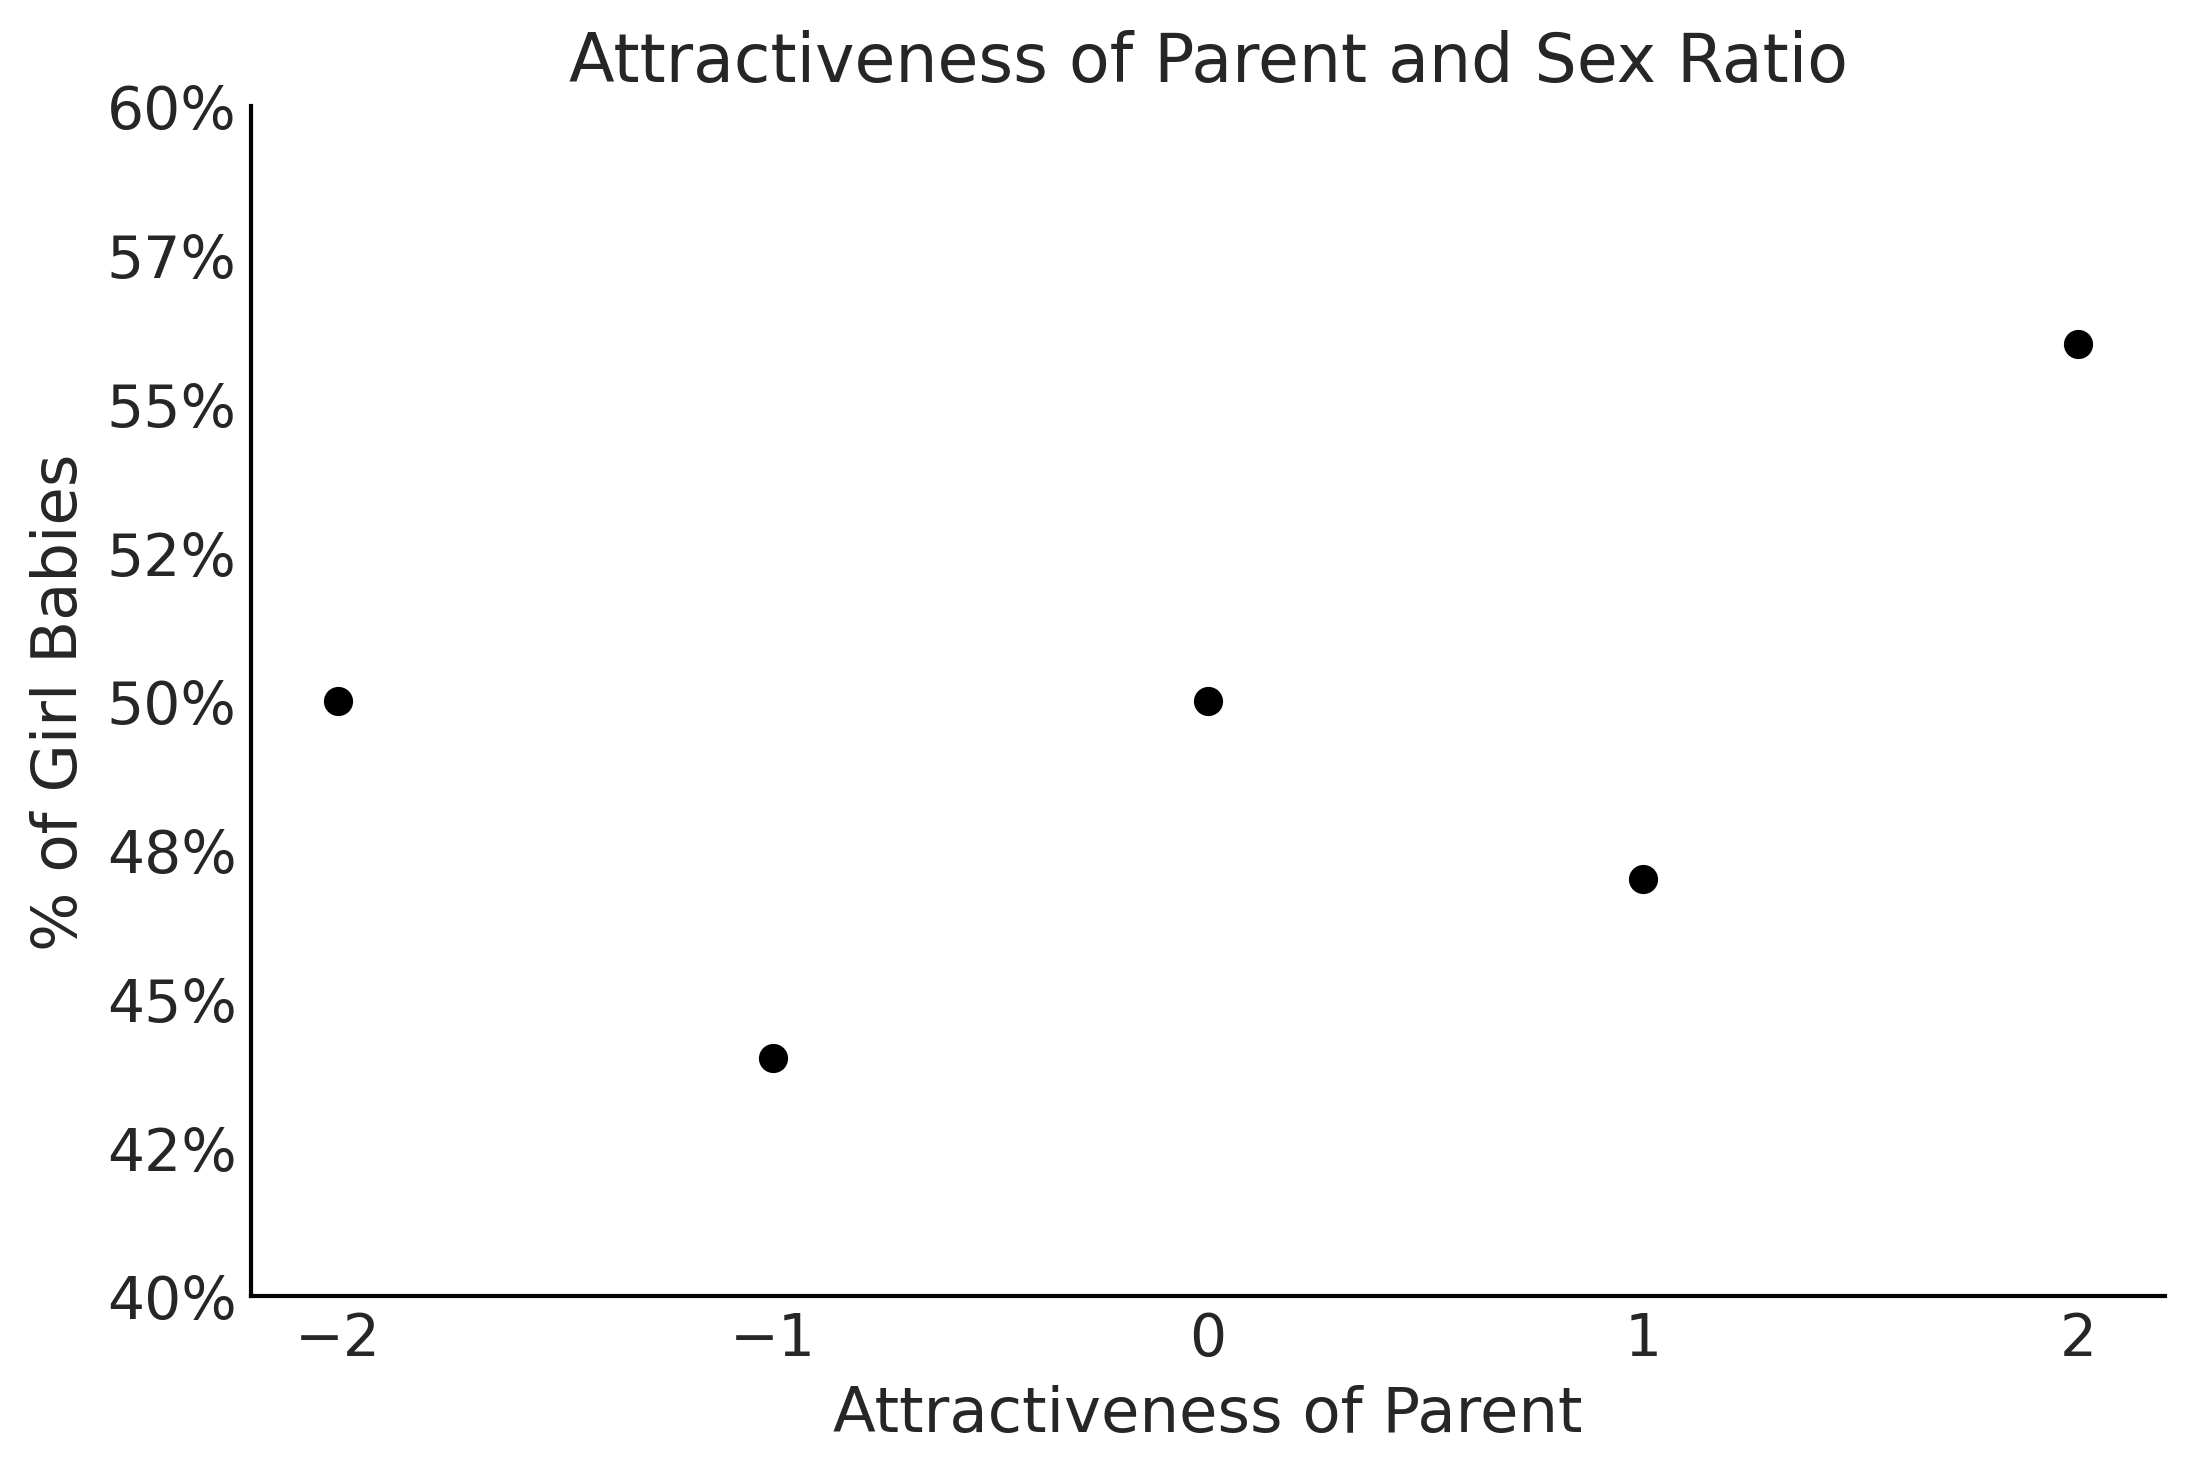

In [76]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots()

ax.scatter(x, y)
ax.set_xticks(x)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_ylim(40, 60)
ax.set_xlabel("Attractiveness of Parent")
ax.set_ylabel("% of Girl Babies")
ax.set_title("Attractiveness of Parent and Sex Ratio")
plt.savefig("img/chp03/beautyratio.png")

### Code 3.30

In [77]:
with pm.Model() as model_uninformative_prior_sex_ratio:
    σ = pm.Exponential("σ", .5)
    β_1 = pm.Normal("β_1", 0, 20)
    β_0 = pm.Normal("β_0", 50, 20)

    μ = pm.Deterministic("μ", β_0 + β_1 * x)
    
    ratio = pm.Normal("ratio", mu=μ, sigma=σ, observed=y)
    
    prior_predictive_uninformative_prior_sex_ratio = pm.sample_prior_predictive(
        samples=10000)
    trace_uninformative_prior_sex_ratio = pm.sample(random_seed=0)
    inf_data_uninformative_prior_sex_ratio = az.from_pymc3(
        trace=trace_uninformative_prior_sex_ratio,
        prior=prior_predictive_uninformative_prior_sex_ratio)

/tmp/ipykernel_83821/1163978236.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_uninformative_prior_sex_ratio = pm.sample(random_seed=0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_0, β_1, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


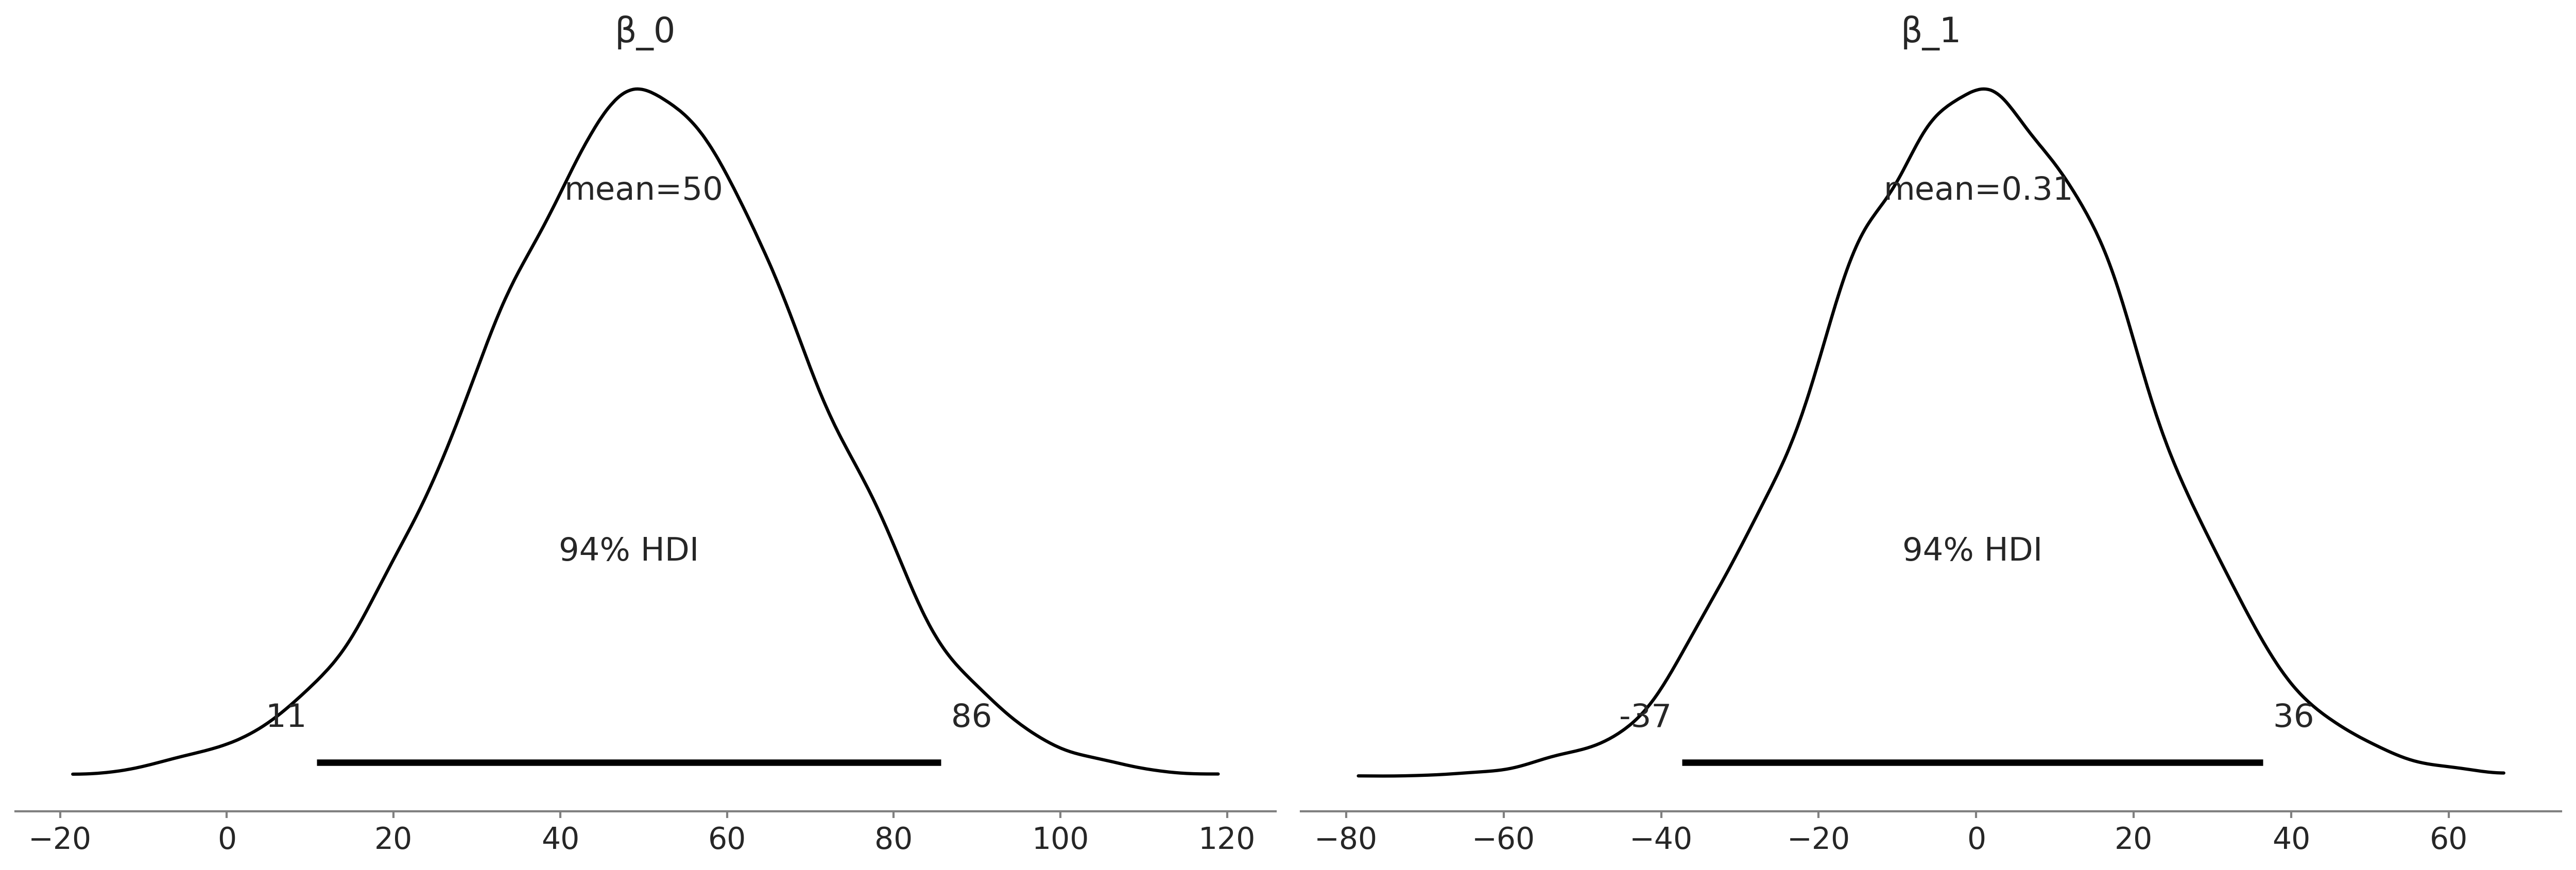

In [78]:
az.plot_posterior(inf_data_uninformative_prior_sex_ratio.prior, var_names=["β_0", "β_1"])
plt.savefig("img/chp03/priorpredictiveuninformativeKDE.png")

In [79]:
az.summary(inf_data_uninformative_prior_sex_ratio, var_names=["β_0", "β_1", "σ"], kind="stats")

mean     sd  hdi_3%  hdi_97%
β_0  49.331  1.913  45.539   52.663
β_1   1.478  1.394  -1.243    4.113
σ     4.208  1.440   2.094    6.869

### Figure 3.24

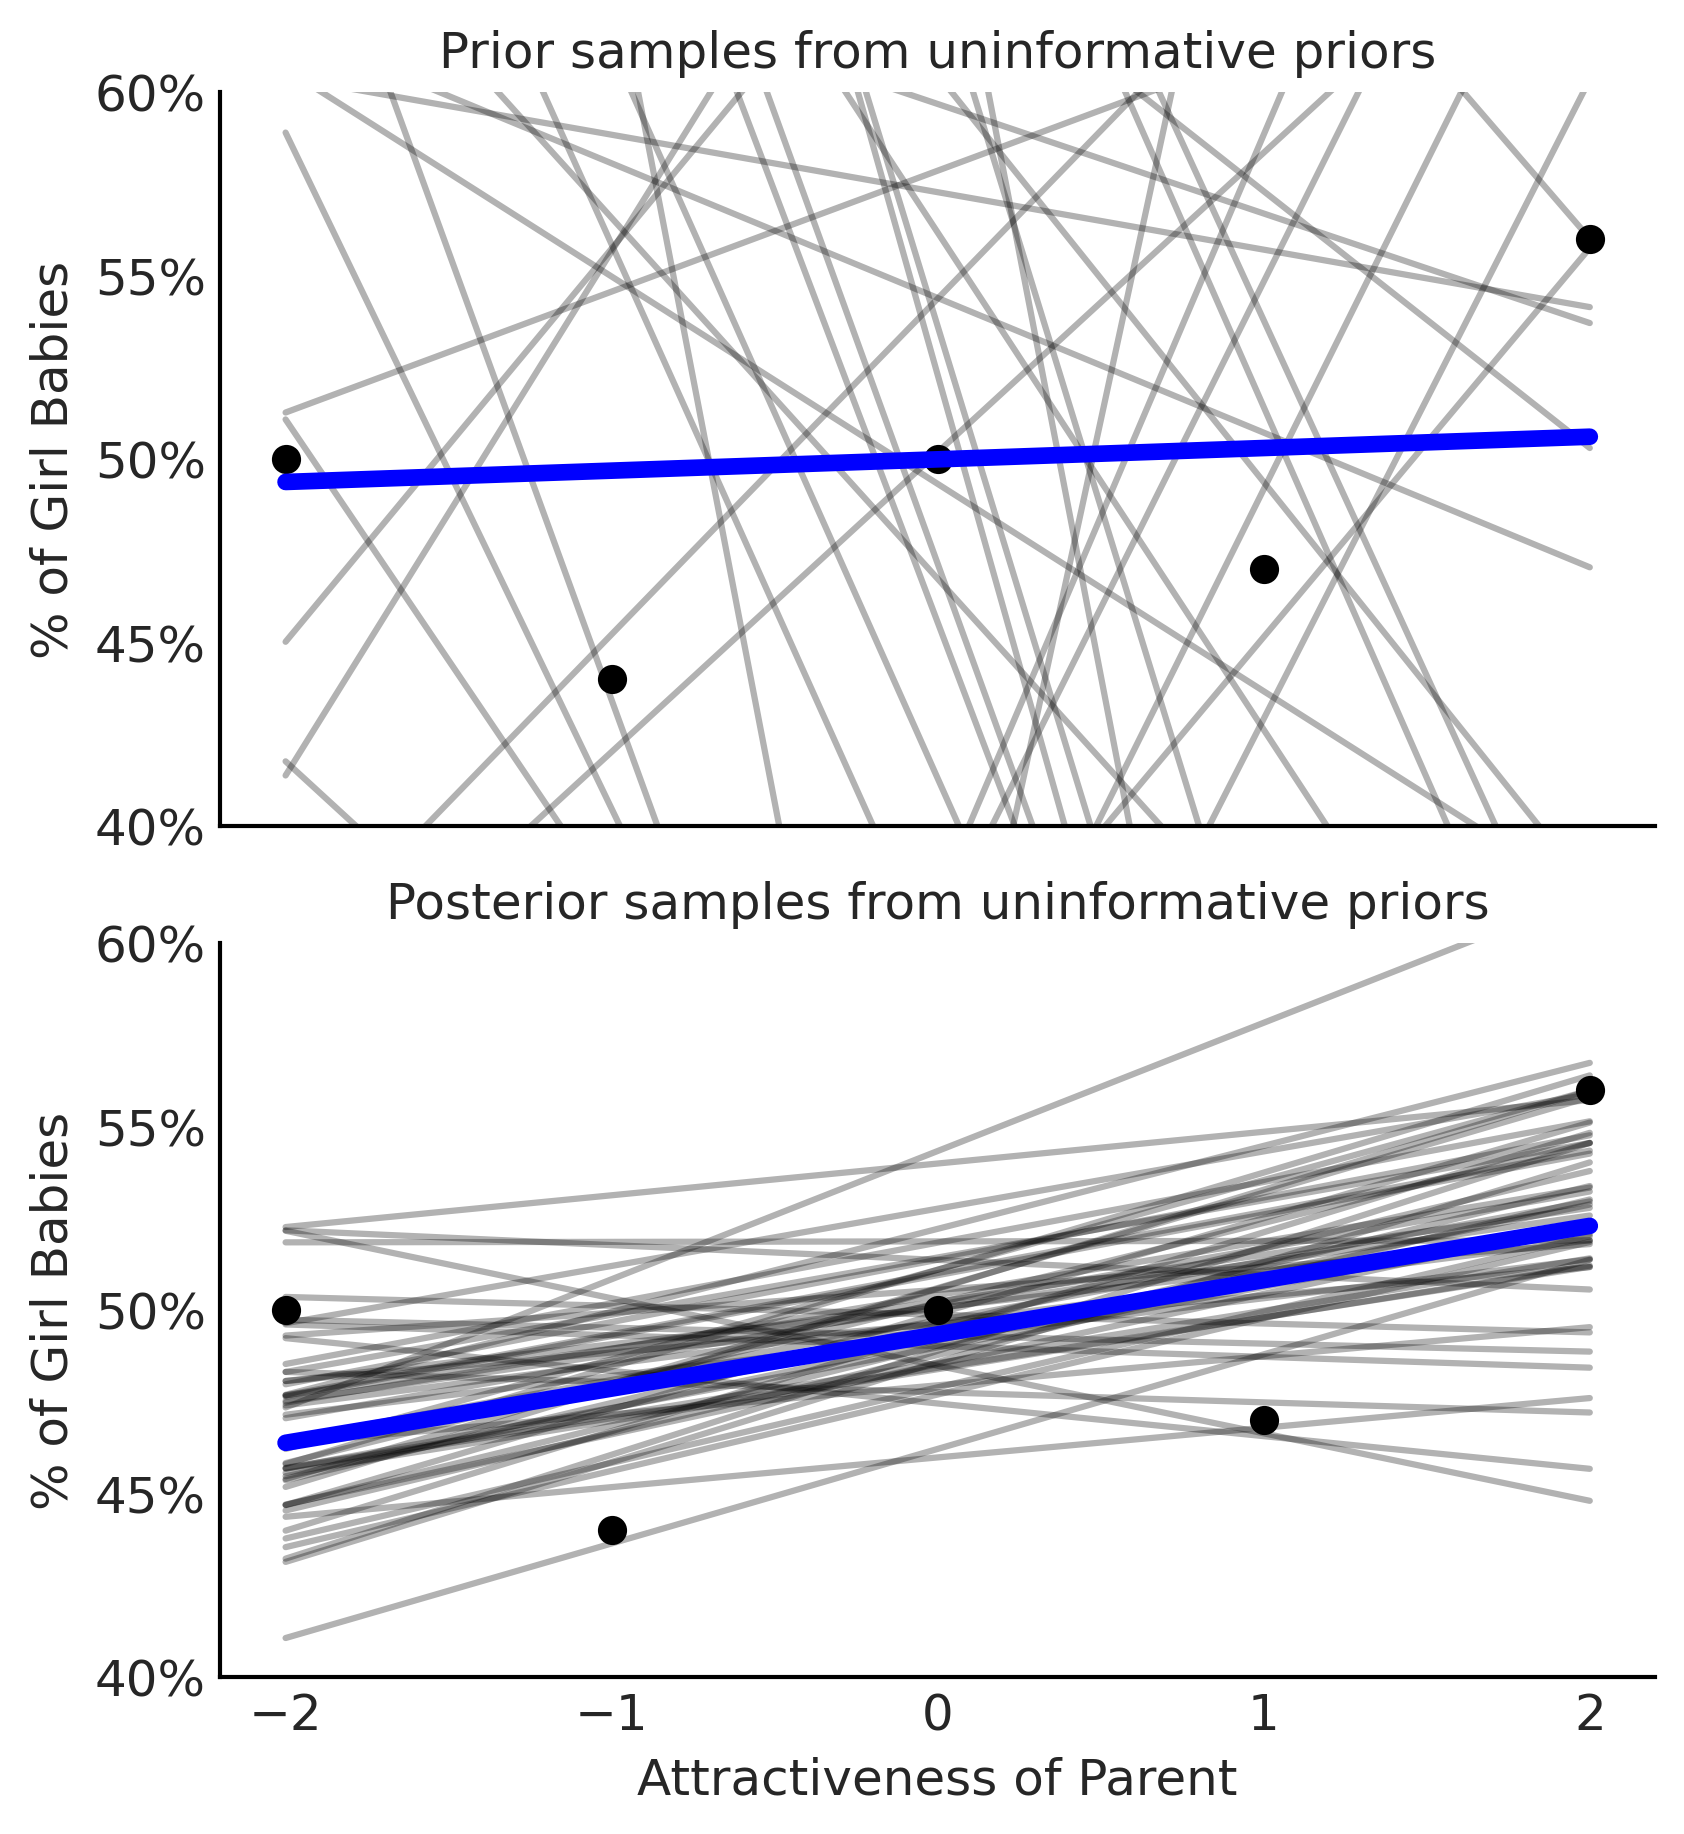

In [80]:
fig, axes = plt.subplots(2,1, figsize=(5.5, 6), sharex=True)

np.random.seed(0)
# Take 10 sample from posterior
num_samples = 50
chain_sample = inf_data_uninformative_prior_sex_ratio.prior.chain.to_series().sample(num_samples, replace=True)
draw_sample = inf_data_uninformative_prior_sex_ratio.prior.draw.to_series().sample(num_samples, replace=True)

for chain, draw in zip(chain_sample, draw_sample):
    b_0_draw = inf_data_uninformative_prior_sex_ratio.prior[{"draw":draw, "chain":chain}]["β_0"].values
    b_1_draw = inf_data_uninformative_prior_sex_ratio.prior[{"draw":draw, "chain":chain}]["β_1"].values
    
    # Plot Line
    axes[0].plot(x, b_0_draw+b_1_draw*x, c="black", alpha=.3)

# Add median line later
b_0_hat = inf_data_uninformative_prior_sex_ratio.prior["β_0"].values.mean()
b_1_hat = inf_data_uninformative_prior_sex_ratio.prior["β_1"].values.mean()

axes[0].plot(x, b_0_hat+b_1_hat*x, c="blue", linewidth=4)


# Add scatter plot
axes[0].scatter(x, y)
axes[0].set_xticks(x)
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[0].set_ylim(40, 60)
axes[0].set_ylabel("% of Girl Babies")
axes[0].set_title("Prior samples from uninformative priors")
b_0_hat, b_1_hat

np.random.seed(0)
# Take 10 sample from posterior
num_samples = 50
chain_sample = inf_data_uninformative_prior_sex_ratio.posterior.chain.to_series().sample(num_samples, replace=True)
draw_sample = inf_data_uninformative_prior_sex_ratio.posterior.draw.to_series().sample(num_samples, replace=True)

for chain, draw in zip(chain_sample, draw_sample):
    b_0_draw = inf_data_uninformative_prior_sex_ratio.posterior[{"draw":draw, "chain":chain}]["β_0"].values
    b_1_draw = inf_data_uninformative_prior_sex_ratio.posterior[{"draw":draw, "chain":chain}]["β_1"].values
    
    # Plot Line
    axes[1].plot(x, b_0_draw+b_1_draw*x, c="black", alpha=.3)

# Add median line later
b_0_hat = inf_data_uninformative_prior_sex_ratio.posterior["β_0"].values.mean()
b_1_hat = inf_data_uninformative_prior_sex_ratio.posterior["β_1"].values.mean()

axes[1].plot(x, b_0_hat+b_1_hat*x, c="blue", linewidth=4)


# Add scatter plot
axes[1].scatter(x, y)
axes[1].set_xticks(x)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[1].set_ylim(40, 60)
axes[1].set_xlabel("Attractiveness of Parent")
axes[1].set_ylabel("% of Girl Babies")
axes[1].set_title("Posterior samples from uninformative priors")
b_0_hat, b_1_hat

axes[1].title.set_fontsize(12)

for ax in axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

plt.savefig("img/chp03/posterioruninformativelinearregression.png")

### Code 3.31

In [81]:
with pm.Model() as model_informative_prior_sex_ratio:
    σ = pm.Exponential("σ", .5)
    β_1 = pm.Normal("β_1", 0, .5)
    β_0 = pm.Normal("β_0", 48.5, .5)

    μ = pm.Deterministic("μ", β_0 + β_1 * x)
    
    ratio = pm.Normal("ratio", mu=μ, sigma=σ, observed=y)
    
        
    prior_predictive_informative_prior_sex_ratio = pm.sample_prior_predictive(
        samples=10000)
    trace_informative_prior_sex_ratio = pm.sample(random_seed=0)
    inf_data_informative_prior_sex_ratio = az.from_pymc3(
        trace=trace_informative_prior_sex_ratio,
        prior=prior_predictive_informative_prior_sex_ratio)

/tmp/ipykernel_83821/4233814204.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_informative_prior_sex_ratio = pm.sample(random_seed=0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_0, β_1, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [82]:
az.summary(inf_data_informative_prior_sex_ratio, var_names=["β_0", "β_1", "σ"], kind="stats")

mean     sd  hdi_3%  hdi_97%
β_0  48.578  0.500  47.671   49.569
β_1   0.244  0.468  -0.630    1.082
σ     4.063  1.241   2.153    6.467

### Figure 3.25

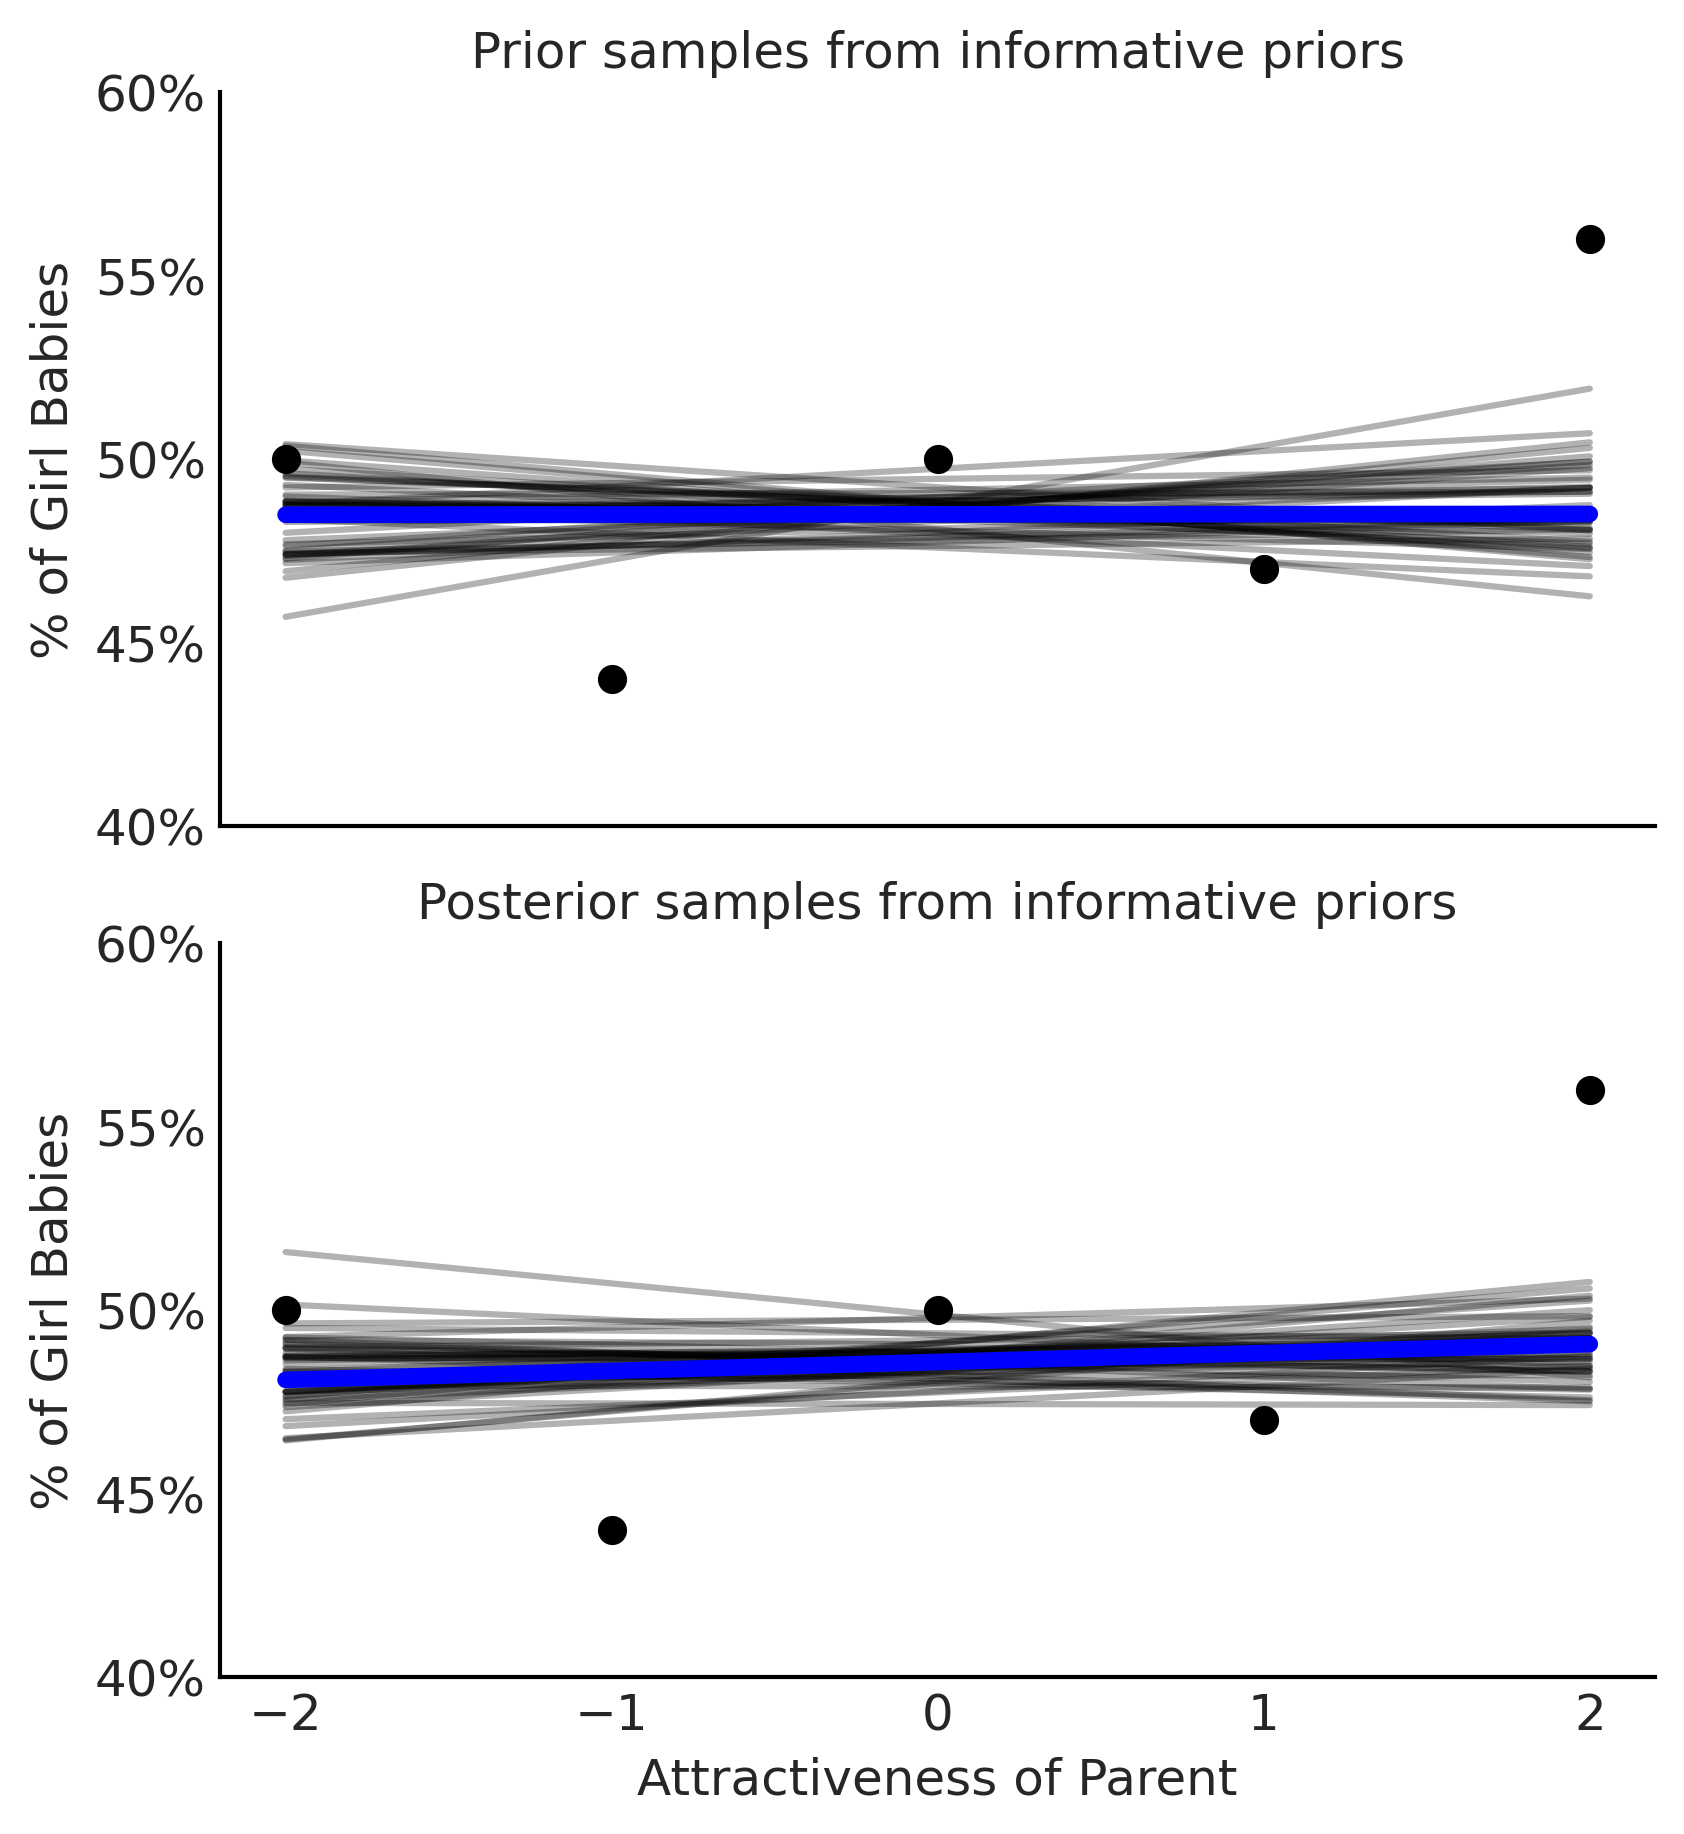

In [83]:
fig, axes = plt.subplots(2,1, figsize=(5.5, 6), sharex=True)

np.random.seed(0)
# Take 10 sample from posterior
num_samples = 50
chain_sample = inf_data_informative_prior_sex_ratio.prior.chain.to_series().sample(num_samples, replace=True)
draw_sample = inf_data_informative_prior_sex_ratio.prior.draw.to_series().sample(num_samples, replace=True)

for chain, draw in zip(chain_sample, draw_sample):
    b_0_draw = inf_data_informative_prior_sex_ratio.prior[{"draw":draw, "chain":chain}]["β_0"].values
    b_1_draw = inf_data_informative_prior_sex_ratio.prior[{"draw":draw, "chain":chain}]["β_1"].values
    
    # Plot Line
    axes[0].plot(x, b_0_draw+b_1_draw*x, c="black", alpha=.3)

# Add median line later
b_0_hat = inf_data_informative_prior_sex_ratio.prior["β_0"].values.mean()
b_1_hat = inf_data_informative_prior_sex_ratio.prior["β_1"].values.mean()

axes[0].plot(x, b_0_hat+b_1_hat*x, c="blue", linewidth=4)


# Add scatter plot
axes[0].scatter(x, y)
axes[0].set_xticks(x)
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[0].set_ylim(40, 60)
axes[0].set_ylabel("% of Girl Babies")
axes[0].set_title("Prior samples from informative priors");


np.random.seed(0)
num_samples = 50
chain_sample = inf_data_informative_prior_sex_ratio.posterior.chain.to_series().sample(num_samples, replace=True)
draw_sample = inf_data_informative_prior_sex_ratio.posterior.draw.to_series().sample(num_samples, replace=True)

for chain, draw in zip(chain_sample, draw_sample):
    b_0_draw = inf_data_informative_prior_sex_ratio.posterior[{"draw":draw, "chain":chain}]["β_0"].values
    b_1_draw = inf_data_informative_prior_sex_ratio.posterior[{"draw":draw, "chain":chain}]["β_1"].values
    
    # Plot Line
    axes[1].plot(x, b_0_draw+b_1_draw*x, c="black", alpha=.3)

# Add median line later
b_0_hat = inf_data_informative_prior_sex_ratio.posterior["β_0"].values.mean()
b_1_hat = inf_data_informative_prior_sex_ratio.posterior["β_1"].values.mean()

axes[1].plot(x, b_0_hat+b_1_hat*x, c="blue", linewidth=4)

# Add scatter plot
axes[1].scatter(x, y)
axes[1].set_xticks(x)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[1].set_ylim(40, 60)

axes[1].set_xlabel("Attractiveness of Parent")
axes[1].set_ylabel("% of Girl Babies")
axes[1].set_title("Posterior samples from informative priors")

for ax in axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

b_0_hat, b_1_hat
plt.savefig("img/chp03/posteriorinformativelinearregression.png")